In [1]:
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn import metrics
import scipy as sp
import logging
from sklearn.neighbors import NearestNeighbors
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
    
def run_lof(X, y, k=60):
    clf = LocalOutlierFactor(n_neighbors=k)
    clf.fit(X)
    lof_scores = -clf.negative_outlier_factor_
    return lof_scores

def get_predictions(scores, num_outliers = 400, method_name = 'LOF'):
    threshold = np.sort(scores)[::-1][num_outliers]
    # threshold, max_f1 = get_best_f1_score(y, lof_scores)
    predictions = np.array(scores > threshold)
    predictions = np.array([int(i) for i in predictions])
#     print('F1 for {} : {}'.format(method_name, metrics.f1_score(y, predictions)))
    return predictions, scores, metrics.f1_score(y, predictions)

def get_best_F1(scores):
    best_f1 = 0
    for i in range(np.shape(scores)[0]):
        threshold = np.sort(scores)[::-1][i]
        predictions = np.array(scores > threshold)
        predictions = np.array([int(i) for i in predictions])
        cur_f1 = metrics.f1_score(y, predictions)
        best_f1 = max(cur_f1, best_f1)
    return best_f1

def run_knn(X, y, k=60):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    knn_dists = neigh.kneighbors(X)[0][:,-1]
    return knn_dists

def run_isolation_forest(X, y, max_features = 1.0):
    # training the model
    clf = IsolationForest(random_state=42,max_features=max_features)
    clf.fit(X)
    # predictions
    sklearn_score_anomalies = clf.decision_function(X)
    if_scores = [-1*s + 0.5 for s in sklearn_score_anomalies]
    return if_scores

def mahalanobis(x):
    """Compute the Mahalanobis Distance between each row of x and the data
    """
    x_minus_mu = x - np.mean(x)
    cov = np.cov(x.T)
    det = np.linalg.det(cov)
    if det != 0:
        inv_covmat = sp.linalg.inv(cov)
    else:
        inv_covmat = sp.linalg.pinv(cov)
    results = []
    x_minus_mu = np.array(x_minus_mu)
    for i in range(np.shape(x)[0]):
        cur_data = x_minus_mu[i,:]
        results.append(np.dot(np.dot(x_minus_mu[i,:], inv_covmat), x_minus_mu[i,:].T))
    return np.array(results)
#     left_term = np.dot(x_minus_mu, inv_covmat)
#     mahal = np.dot(left_term, x_minus_mu.T)
#     print(mahal.diagonal())
#     return mahal.diagonal()

def run_mahalanobis(X, y):
    # training the model
    dist = mahalanobis(x=X)
    return dist

def load_dataset(filename):
    with open(filename, 'r') as f:
        data, meta = arff.loadarff(f)
    data = pd.DataFrame(data)
    X = data.drop(columns=['id', 'outlier'])
    # Map dataframe to encode values and put values into a numpy array
    y = data["outlier"].map(lambda x: 1 if x == b'yes' else 0).values
    return X, y

In [2]:
learning_rate = 0.01
log_interval = 10

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np
from torch.utils import data
import torch.optim as optim
from torch.autograd import Variable

torch.manual_seed(0)
class Net(nn.Module):
    def __init__(self, dim = 10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(dim, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100,50)
        self.fc4 = nn.Linear(50,2)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x)

def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def inference_NN(net, testing_X, testing_y = None):
    test_dataloader = data.DataLoader(data.TensorDataset(torch.tensor(testing_X), torch.tensor(testing_y)), 
                                      batch_size=100, shuffle=False) 
    net.eval()
    predict_proba = []
    for batch_idx, (input_data, target) in enumerate(test_dataloader):
        input_data = Variable(input_data)
        net_out = net(input_data.float())
        predict_proba.append(F.softmax(net_out, dim=1).data.numpy())
    return np.concatenate(predict_proba)

def run_NN(X,y, epochs = 3,  dim = 10):
    net = Net(dim)
    # create a stochastic gradient descent optimizer
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
    # create a loss function
    criterion = nn.NLLLoss()
    # create dataset
    tensor_x = torch.tensor(X) # transform to torch tensor
    tensor_y = torch.tensor(y,dtype=torch.long)
    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
#     class_sample_count = np.array([len(np.where(y == t)[0]) for t in np.unique(y)])
#     weight = 1. / class_sample_count
#     samples_weight = np.array([weight[t] for t in y])
#     samples_weight = torch.from_numpy(samples_weight)
#     samples_weight = samples_weight.double()
#     sampler = data.WeightedRandomSampler(samples_weight, len(samples_weight))
    train_dataloader = data.DataLoader(my_dataset, batch_size=100, shuffle = True) # create your dataloader
    
    # run the main training loop
    for epoch in range(epochs):
        net.train()
        for batch_idx, (input_data, target) in enumerate(train_dataloader):
            input_data, target = Variable(input_data), Variable(target)
            net_out = net(input_data.float())
            loss = criterion(net_out, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        net.eval()
        losses = AverageMeter()
        top1 = AverageMeter()
        top2 = AverageMeter()
    
    net.eval()
    losses = AverageMeter()
    top1 = AverageMeter()
    top2 = AverageMeter()
    loss_list = []
    for batch_idx, (input_data, target) in enumerate(data.DataLoader(my_dataset, batch_size=1, shuffle=False)):
        input_data, target = Variable(input_data), Variable(target)
        net_out = net(input_data.float())
#             print(F.softmax(net_out, dim=1))
        loss = criterion(net_out, target)
        prec = accuracy(net_out.data, target)
        losses.update(loss.data, input_data.size(0))
        loss_list.append(loss.data.numpy())
        top1.update(prec[0], input_data.size(0))
    print('Final Training Result: Loss {loss.avg:.8f}\t'
              'Prec @ 1 {top1.avg:.3f}%'.format(
               loss=losses, top1=top1))   
    return np.array(loss_list), net, losses.avg

In [4]:
# predict_proba = run_NN(X.values,y, 10, get_prediction = True, testing_X = X.values, testing_y = y)
# sum(predict_proba[:,1] > 0.5)

### Load SpamBase dataset

In [5]:
filename = './SpamBase_withoutdupl_norm_40.arff'
X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
K = 9
N = 1679
class_balance = [1- N/4207.0, N/4207.0]
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
# mahalanobis_N_range=[N]
mahalanobis_N_range = [1400, 1500, 1600, 1700, 1800, 1900]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range * 10) 
print(N/len(y))

(4207, 57) (4207,)
0.39909674352270025


### Load pageblock dataset

In [5]:
filename = './PageBlocks/PageBlocks_norm_10.arff'
X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
K = 80
N = 560
# num_outliers = [N, N, N, N]
class_balance = [0.9, 0.1]
# lof_krange = [55, 60, 65, 70, 75] 
# knn_krange = [55, 60, 65, 70, 75] 
# if_range = [0.5, 0.6,0.7, 0.8,0.9]
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
# lof_krange = range(70,90,4) 
# knn_krange = [60, 70, 80, 90, 100] 
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
# mahalanobis_N_range=[560]
mahalanobis_N_range = [300, 400, 500, 600, 700, 800]
# mahalanobis_N_range = [550, 560, 570, 580, 590, 600]
N_size = 6
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range * 10)

(5473, 10) (5473,)


### Load Pima dataset

In [40]:
filename = './Pima_withoutdupl_norm_35.arff'
X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
K = 100
N = 268
print(N/len(y))
num_outliers = [N, N, N, N]
class_balance = [1- N/768.0, N/768.0]
lof_krange = list(range(10,210,10)) * 6
knn_krange = list(range(10,210,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[N]
mahalanobis_N_range = [220,230,240,250,260,270]

if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range * 20)

(768, 8) (768,)
0.3489583333333333


### ALOI dataset

In [30]:
filename = './ALOI_withoutdupl_norm.arff'
X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
print(sum(y))
N = 1508
num_outliers = [N, N, N, N]
class_balance = [1- N/49534.0, N/49534.0]
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
# mahalanobis_N_range=[N]
mahalanobis_N_range=[1200, 1400, 1600, 1800, 2000, 2200]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

(49534, 27) (49534,)
1508


### Load InternetAds

In [1256]:
filename = './InternetAds_withoutdupl_norm_19.arff'
X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
print(sum(y))
N = 368
num_outliers = [N, N, N, N]
class_balance = [1- N/1966.0, N/1966.0]
lof_krange = list(range(5,55,5)) * 6
knn_krange = list(range(5,55,5)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
# mahalanobis_N_range=[N]
mahalanobis_N_range = [300, 350, 400, 450, 500, 550]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

(1966, 1555) (1966,)
368


### Load KDDCup 99 dataset

In [4]:
filename = './KDDCup99_withoutdupl_norm_catremoved.arff'
X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
print(sum(y))
N = 200
num_outliers = [N, N, N, N]
class_balance = [1- N/48113.0, N/48113.0]
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[500,1000,1500,2000,2500,3000]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

(48113, 40) (48113,)
200


In [5]:
filename='kdd99-unsupervised-ad.csv'
import pandas as pd
data = pd.read_csv(filename, header=None)
X = data.drop(columns=[29])
print(np.shape(np.array(X)))
# Map dataframe to encode values and put values into a numpy array
y = data[29].map(lambda x: 1 if x == 'o' else 0).values
print(sum(y))

lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[1000,1500,2000,2500,3000,3500]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

(620098, 29)
1052


### Load shuttle dataset

In [64]:
import hdf5storage
mat = hdf5storage.loadmat('shuttle.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[1000,1500,2000, 2500,3000, 3500]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)
print(np.shape(X))
# normalize
# from sklearn.preprocessing import Normalizer
# transformer = Normalizer().fit(X) 
# X = transformer.transform(X)

49097
0.0715114976475141
(49097, 9)


### Load mulcross dataset

In [28]:
filename = './mulcross.arff'

with open(filename, 'r') as f:
    data, meta = arff.loadarff(f)
data = pd.DataFrame(data)
X = data.drop(columns=['Target'])
y = data["Target"].map(lambda x: 1 if x == b'Anomaly' else 0).values
# X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
print(sum(y))
print(sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[20000, 22000, 24000, 26000, 28000, 30000]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

(262144, 4) (262144,)
26214
0.09999847412109375


### Load HTTP dataset

In [5]:
import hdf5storage
mat = hdf5storage.loadmat('http.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y))
print(np.sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
# mahalanobis_N_range=[1500, 2000, 2500, 3000, 3500, 4000]
mahalanobis_N_range=[5000, 10000, 15000,20000, 25000, 30000]
# mahalanobis_N_range=[10000, 15000, 20000, 25000, 30000, 35000]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

# # remove duplicates
# newdata = pd.DataFrame(np.concatenate((X,y), axis = 1)).drop_duplicates()
# X = newdata[[0,1,2]].values
# y = np.array([1 if i==1.0 else 0 for i in newdata[[3]].values])
# print('Remove duplicates: ', len(y))

# # normalize
# from sklearn.preprocessing import Normalizer
# transformer = Normalizer().fit(X) 
# X = transformer.transform(X)

567498
2211.0
0.003896048972859816


### Load ForestCover Dataset

In [6]:
import hdf5storage
import pickle
dataset = pickle.load(open("cover_dataset.pickle", "rb"))
X = dataset['X']
y = dataset['y']
print(np.sum(y))
print(len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[5000, 10000, 15000, 20000, 25000, 30000]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X_transformed = transformer.transform(X)

2747
286048


### Load Annthyroid dataset

In [185]:
filename = './Annthyroid_withoutdupl_norm_07.arff'
X, y = load_dataset(filename=filename)
print(np.shape(X), np.shape(y))
print(sum(y)/len(y))
N = 534
num_outliers = [N, N, N, N]
class_balance = [1- N/7129.0, N/7129.0]
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
# mahalanobis_N_range=[N]
mahalanobis_N_range=[300, 400,500,600,700,800]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

(7129, 21) (7129,)
0.07490531631364848


In [5]:
import hdf5storage
mat = hdf5storage.loadmat('smtp.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y))

lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
# mahalanobis_N_range=[20, 40, 60, 80, 100, 120]
mahalanobis_N_range = [30, 40, 50, 60, 70,80]
# mahalanobis_N_range = [200, 400, 600, 800, 1000, 1200]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)

95156
30.0


In [221]:
import hdf5storage
mat = hdf5storage.loadmat('cardio.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[150,200,250,300,350,400]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)
print(np.shape(X))

1831
0.0961223375204806
(1831, 21)


### Load Musk dataset

In [49]:
import hdf5storage
mat = hdf5storage.loadmat('musk.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y))
print(np.sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[100, 120, 140, 160, 180, 200]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)
print(np.shape(X))

3062
97.0
0.03167864141084259
(3062, 166)


### Load Satimage-2 dataset

In [67]:
import hdf5storage
mat = hdf5storage.loadmat('satimage-2.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y))
print(np.sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[60, 80, 100, 120, 140, 160]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)
print(np.shape(X))

5803
71.0
0.0122350508357746
(5803, 36)


### Load Pendigits Dataset

In [ ]:
import hdf5storage
mat = hdf5storage.loadmat('pendigits.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y))
print(np.sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[150,200,250,300,350,400]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)
print(np.shape(X))

In [97]:
import hdf5storage
mat = hdf5storage.loadmat('optdigits.mat')
X = mat['X']
y = mat['y']
print(len(y))
print(np.sum(y))
print(np.sum(y)/len(y))
lof_krange = list(range(10,110,10)) * 6
knn_krange = list(range(10,110,10)) * 6
if_range = [0.5, 0.6, 0.7, 0.8, 0.9] * 6
mahalanobis_N_range=[150,200,250,300,350,400]
# mahalanobis_N_range = [20, 40, 60,80, 100,120]
if_N_range = np.sort(mahalanobis_N_range * 5)
N_range = np.sort(mahalanobis_N_range *10)
print(np.shape(X))

5216
150.0
0.028757668711656442
(5216, 64)


In [6]:
all_results = []
all_scores = []
f1s = []

temp_lof_results = dict()
unique_lof_ks = list(set(lof_krange)) 
for k in unique_lof_ks:
#     print(k)
    lof_scores = run_lof(X, y, k=k)
    temp_lof_results[k] = lof_scores
for i in range(len(lof_krange)):
    lof_predictions, lof_scores, f1 = get_predictions(temp_lof_results[lof_krange[i]], num_outliers=N_range[i], method_name='LOF')
    all_results.append(lof_predictions)
    all_scores.append(lof_scores)
    f1s.append(f1)
# best_lof_f1 = 0
# for i in np.sort(unique_lof_ks):
#     temp_f1 = max(np.array(f1s[0:60])[np.where(np.array(lof_krange) == i)[0]])
#     print('LOF k = {}, best F-1 = {}'.format(i, temp_f1))
#     best_lof_f1 = max(best_lof_f1, temp_f1)
# print('Best LOF F-1 = {}'.format(best_lof_f1))

temp_knn_results = dict()
unique_knn_ks = list(set(knn_krange)) 
for k in unique_knn_ks:
    print(k)
    knn_scores = run_knn(X, y, k=k)
    temp_knn_results[k] = knn_scores
for i in range(len(knn_krange)):
    knn_predictions, knn_scores,f1 = get_predictions(temp_knn_results[knn_krange[i]], num_outliers=N_range[i], method_name='KNN')
    all_results.append(knn_predictions)
    all_scores.append(knn_scores)
    f1s.append(f1)
# best_knn_f1 = 0
# for i in np.sort(unique_knn_ks):
#     temp_f1 = max(np.array(f1s[60:120])[np.where(np.array(knn_krange) == i)[0]])
#     print('KNN k = {}, best F-1 = {}'.format(i, temp_f1))
#     best_knn_f1 = max(best_knn_f1, temp_f1)
# print('Best KNN F-1 = {}'.format(best_knn_f1))
    
temp_if_results = dict()
unique_if_features = list(set(if_range)) 
for k in unique_if_features:
    print(k)
    if_scores = run_isolation_forest(X, y, max_features=k)
    temp_if_results[k] = if_scores
for i in range(len(if_range)):
    if_predictions, if_scores,f1 = get_predictions(temp_if_results[if_range[i]], num_outliers=N_range[i], method_name='IF')
    all_results.append(if_predictions)
    all_scores.append(if_scores)
    f1s.append(f1)
# best_if_f1 = 0
# for i in np.sort(unique_if_features):
#     temp_f1 = max(np.array(f1s[120:150])[np.where(np.array(if_range) == i)[0]])
#     print('IF = {}, best F-1 = {}'.format(i, temp_f1))
#     best_if_f1 = max(best_if_f1, temp_f1)
# print('Best IF F-1 = {}'.format(best_if_f1))
    
mahalanobis_scores = run_mahalanobis(X, y)
best_mahala_f1 = 0
for i in range(len(mahalanobis_N_range)):
    mahalanobis_predictions,mahalanobis_scores,f1 = get_predictions(mahalanobis_scores, num_outliers=mahalanobis_N_range[i], method_name='mahala')
    all_results.append(mahalanobis_predictions)
    all_scores.append(mahalanobis_scores)
    best_mahala_f1 = max(best_mahala_f1, f1)
    f1s.append(f1)
# print('mahalanobis = {}'.format(max(np.array(f1s[150:]))))
print('Best Mahala F-1 = {}'.format(best_mahala_f1))
L = np.stack(all_results).T
scores = np.stack(all_scores).T

100
70
40
10
80
50
20
90
60
30
0.5
0.6
0.8
0.9
0.7
Best Mahala F-1 = 0


In [7]:
print(np.shape(L))
print(np.shape(scores))

(95156, 156)
(95156, 156)


### Majority Vote

In [8]:
mid = np.shape(L)[1]/2
predictions = np.full((len(y)), 0)
predictions[np.sum(L, axis = 1) > mid] = 1
print('F1 for MV:', metrics.f1_score(y, predictions))

F1 for MV: 0.3913043478260869


### Snorkel

In [11]:
from snorkel.labeling import LabelModel
label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L, seed=123, lr=0.001, n_epochs=5000, class_balance=[0.9,0.1])
probs_train = label_model.predict_proba(L=L)

In [12]:
threshold = 0.1
predictions = np.full((len(y)), 0)
predictions[probs_train[:,1] > threshold] = 1
print('F1 for snorkel: ', metrics.f1_score(y, predictions))

F1 for snorkel:  0.11267605633802817


In [11]:
snorkel_predictions = predictions

### Save and load pickles

In [10]:
import pickle
dataset_results = {'L': L, 'scores': scores, 'f1s': f1s}
pickle.dump(dataset_results, open("aloi.pickle", "wb" ))

In [42]:
import pickle
dataset_results = pickle.load(open("cover.pickle", "rb"))
L = dataset_results['L']
scores = dataset_results['scores']
f1s = dataset_results['f1s']

In [9]:
L_prev = L
scores_prev = scores

In [10]:
L = L_prev
scores = scores_prev

In [11]:
print(max(f1s)) 
print(np.shape(L))
y = y.reshape(-1)

0.6666666666666666
(95156, 156)


In [12]:
prediction_result_list = []
classifier_result_list = []
prediction_list = []
cur_f1_scores = []
prediction_high_conf_outliers = np.array([])
prediction_high_conf_inliers = np.array([])
prediction_classifier_disagree = np.array([])

In [13]:
index_range = np.array([[0, 60], [60, 120], [120, 150], [150, 156]])
coef_index_range = np.array([[0, 10], [10, 20], [20, 25], [25, 26]])
coef_remain_index = range(156)

In [14]:
# for i in range(60):
#     scores[scores[:,i] > 100,i] = 100

In [15]:
# index_range = np.array([[0, 120], [120, 240], [240, 270], [270, 276]])
# coef_index_range = np.array([[0, 20], [20, 40], [40, 45], [45, 46]])
# coef_remain_index = range(276)

In [16]:
# new_scores = []
# for i in range(np.shape(scores)[1]):
#     new_scores.append(np.argsort(np.argsort(scores[:,i]))/len(scores[:,i]))
# scores = np.stack(new_scores).T

In [17]:
scores_for_training_indexes = []
for i in range(len(index_range)):
    start=index_range[i][0]
    temp_range = coef_index_range[i][1]-coef_index_range[i][0]
    scores_for_training_indexes  = scores_for_training_indexes + list(range(start, start+temp_range))
print(scores_for_training_indexes) 
scores_for_training = scores[:, np.array(scores_for_training_indexes)]
print(np.shape(scores_for_training))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 120, 121, 122, 123, 124, 150]
(95156, 26)


In [18]:
def generate_coef_proba(coef):
    # weights --> ranking
    pos_ranking = np.argsort(np.argsort(coef)) + 1
#     print(pos_ranking)

    # ranking --> u_k
    num_coefs = len(coef)
    normalize_factor = np.sum([max(0, np.log(num_coefs + 1) - np.log(j)) for j in range(1, num_coefs + 1)])
    u_k = [max(0, np.log(num_coefs + 1) - np.log(j))/normalize_factor - 1/num_coefs for j in pos_ranking]
    
    # normalize u_k
    normalized_u_k = (u_k-min(u_k))/(max(u_k)-min(u_k))
#     print(normalized_u_k)

    # u_k to probabilities
    import scipy.stats
    pdfs = np.array([scipy.stats.norm(0, np.std(normalized_u_k)).pdf(j) for j in normalized_u_k])
#     preservation_rate = 0.8
#     probabilities = pdfs * preservation_rate * num_coefs/np.sum(pdfs)
    probabilities = (pdfs-min(pdfs))/(max(pdfs)-min(pdfs))
#     probabilities = pdfs
    print(probabilities)
    return probabilities

def filter_update_list(R, value_list):
    P = 2
    prediction = 0
    for new_value in value_list:
        K = P / (P + R)
        prediction = prediction + K * (new_value - prediction)
        P = (1 - K) * P
    return prediction

def get_kf_results(proba_list):
    results = []
    for i in range(np.shape(proba_list)[1]):
        results.append(filter_update_list(0.1, proba_list[:, i]))
    return np.array(results)

def generate_decision_on_proba(probabilities):
    return np.array([np.random.binomial(n=1, p = min(1, proba)) for proba in probabilities])
    

### Iterative train LR and classifier(SVM)

In [19]:
# Working solution: Prune points using NN, add good prediction results back
from sklearn.metrics import roc_auc_score

last_training_data_indexes = []
counter = 0

ratio_to_remove = 0.05
dim = np.shape(X)[1]
remain_points = np.array(range(len(y)))

mid = np.shape(L)[1]/2
label_of_point = np.full((len(y)), 0)
label_of_point[np.sum(L, axis = 1) > mid] = 1
# label_of_point = snorkel_predictions.copy()

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X_transformed = transformer.transform(X)

prev_loss = 10000
early_loss_list = []
converge_loss_list = []
f1_score_list = []

for i_range in range(0, 50):
    print("##################################################################")
    print('Iteration = {}'.format(i_range))
    print('F1 for training data:', metrics.f1_score(y[remain_points], label_of_point[remain_points]))
    print('accuracy for training data:', metrics.accuracy_score(y[remain_points], label_of_point[remain_points]))
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y[remain_points], label_of_point[remain_points]))

    if((i_range  + 1) % 1 == 0):
        from sklearn.svm import SVC
        clf_X = SVC(gamma='auto', probability=True, random_state=0)
        clf_X.fit(X_transformed[remain_points], label_of_point[remain_points])
        clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]

        SVM_threshold = 0.5
        print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        SVM_threshold = np.sort(clf_predict_proba_X)[::-1][int(np.sum(y))]
        print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        f1_score_list.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))

    counter = 0
#     while(counter < 5):
    temp_remain_points = remain_points.copy()
    # start pruning points
    counter = counter + 1
    loss_list, model, avg_train_loss = run_NN(X_transformed[temp_remain_points],label_of_point[temp_remain_points], 3, dim = dim)
#     loss_threshold = np.sort(loss_list)[::-1][int(ratio_to_remove * len(loss_list))]
#     print(min(loss_list), max(loss_list), loss_threshold, np.mean(loss_list)+ np.std(loss_list))
#     loss_threshold = np.mean(loss_list)+ np.std(loss_list)
#     print('Number of points to change: ', sum((loss_list > loss_threshold)))
#     points_to_remove = temp_remain_points[(loss_list > loss_threshold)]

    inlier_labels = np.where(label_of_point[temp_remain_points] == 0)[0]
    loss_threshold = np.sort(loss_list[inlier_labels])[::-1][int(ratio_to_remove * len(loss_list[inlier_labels]))]
    loss_threshold = np.mean(loss_list[inlier_labels])+ np.std(loss_list[inlier_labels])
    print('Number of inliers to change: ', sum(loss_list[inlier_labels] > loss_threshold))
    points_to_remove = temp_remain_points[inlier_labels][(loss_list[inlier_labels] > loss_threshold)]

    outlier_labels = np.where(label_of_point[temp_remain_points] == 1)[0]
    loss_threshold = np.sort(loss_list[outlier_labels])[::-1][int(ratio_to_remove * len(loss_list[outlier_labels]))]
    loss_threshold = np.mean(loss_list[outlier_labels])+ np.std(loss_list[outlier_labels])
    print('Number of outliers to change: ', sum(loss_list[outlier_labels] > loss_threshold))
    points_to_remove = np.append(points_to_remove, temp_remain_points[outlier_labels][(loss_list[outlier_labels] > loss_threshold)])

    loss_list, model, avg_train_loss = run_NN(X_transformed[temp_remain_points],label_of_point[temp_remain_points],10, dim = dim)
    converge_loss_list.append(avg_train_loss)
    predict_proba = inference_NN(model, X_transformed, y)[:,1]
    print("F-1 score from NN:",metrics.f1_score(y, np.array([int(i) for i in predict_proba > 0.5])))
    print('Number of outliers by NN:', sum(np.array([int(i) for i in predict_proba > 0.5])))

    print('Number of points to remove: ', len(points_to_remove))
    temp_remain_points = np.setdiff1d(np.array(temp_remain_points), points_to_remove)

    predict_outlier_indexes = np.where(predict_proba > 0.9)[0]
    new_outlier_indexes = np.setdiff1d(predict_outlier_indexes, temp_remain_points)
#     new_outlier_indexes = new_outlier_indexes[label_of_point[new_outlier_indexes]==0]
    print('Number of new points with confidence > 0.99', len(new_outlier_indexes))
    print(label_of_point[new_outlier_indexes])
    print(y[new_outlier_indexes])
    if(len(new_outlier_indexes) > 0):
        print('F-1 before: ', metrics.f1_score(y[new_outlier_indexes], label_of_point[new_outlier_indexes]))
        label_of_point[new_outlier_indexes] = 1
        print('F-1 after: ', metrics.f1_score(y[new_outlier_indexes], label_of_point[new_outlier_indexes]))
        temp_remain_points = np.union1d(temp_remain_points, predict_outlier_indexes)

    predict_inlier_indexes = np.where(predict_proba < 0.00001)[0]
    new_inlier_indexes = np.setdiff1d(predict_inlier_indexes, temp_remain_points)
#     new_inlier_indexes = new_inlier_indexes[label_of_point[new_inlier_indexes]==1]
    print('Number of points with confidence < 0.01', len(new_inlier_indexes))
    print(label_of_point[new_inlier_indexes])
    print(y[new_inlier_indexes])
    if(len(new_inlier_indexes) > 0):
        label_of_point[new_inlier_indexes] = 0
        temp_remain_points = np.union1d(temp_remain_points, predict_inlier_indexes)
#         if(len(new_outlier_indexes) <= len(points_to_remove)):
    
    if(len(new_outlier_indexes) + len(new_inlier_indexes) > len(points_to_remove) or len(remain_points) < np.shape(L)[0]/3):  # 
        from sklearn.svm import SVC
        clf_X = SVC(gamma='auto', probability=True, random_state=0)
        clf_X.fit(X_transformed[remain_points], label_of_point[remain_points])
        clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]

        SVM_threshold = 0.5
        print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        SVM_threshold = np.sort(clf_predict_proba_X)[::-1][int(np.sum(y))]
        print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        f1_score_list.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))
        break
    else:
        remain_points = temp_remain_points
    
#             break
#     if(counter == 5):
#         break


##################################################################
Iteration = 0
F1 for training data: 0.3913043478260869
accuracy for training data: 0.9997057463533566
[[95119     7]
 [   21     9]]
F-1 score from SVM: 0.3913043478260869
Number of outliers by SVM: 16
F-1 score from SVM: 0.36666666666666664
Number of outliers by SVM: 30
AUROC from SVM: 0.7507800180812816


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00132846	Prec @ 1 99.985%
Number of inliers to change:  123
Number of outliers to change:  1
Final Training Result: Loss 0.00075954	Prec @ 1 99.989%
F-1 score from NN: 0.0
Number of outliers by NN: 6
Number of points to remove:  124
Number of new points with confidence > 0.99 0
[]
[]
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 1
F1 for training data: 0.5294117647058824
accuracy for training data: 0.9998316356595673
[[95007     6]
 [   10     9]]
F-1 score from SVM: 0.588235294117647
Number of outliers by SVM: 21
F-1 score from SVM: 0.6666666666666666
Number of outliers by SVM: 30
AUROC from SVM: 0.8223202208999993


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00020365	Prec @ 1 99.992%
Number of inliers to change:  2904
Number of outliers to change:  4
Final Training Result: Loss 0.00004440	Prec @ 1 100.000%
F-1 score from NN: 0.6557377049180327
Number of outliers by NN: 31
Number of points to remove:  2908
Number of new points with confidence > 0.99 19
[0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0.]
F-1 before:  0.4210526315789474
F-1 after:  0.8823529411764706
Number of points with confidence < 0.01 1
[1]
[0.]
##################################################################
Iteration = 2
F1 for training data: 0.6666666666666666
accuracy for training data: 0.9997829484285466
[[92104    10]
 [   10    20]]
F-1 score from SVM: 0.6557377049180327
Number of outliers by SVM: 31
F-1 score from SVM: 0.6440677966101694
Number of outliers by SVM: 29
AUROC from SVM: 0.8295448492876116


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00007579	Prec @ 1 100.000%
Number of inliers to change:  3664
Number of outliers to change:  7
Final Training Result: Loss 0.00003287	Prec @ 1 100.000%
F-1 score from NN: 0.625
Number of outliers by NN: 34
Number of points to remove:  3671
Number of new points with confidence > 0.99 10
[1 1 1 0 1 1 0 1 1 0]
[1. 1. 1. 0. 1. 1. 0. 1. 1. 0.]
F-1 before:  1.0
F-1 after:  0.8235294117647058
Number of points with confidence < 0.01 26
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
##################################################################
Iteration = 3
F1 for training data: 0.6349206349206349
accuracy for training data: 0.9997401394208498
[[88466    13]
 [   10    20]]
F-1 score from SVM: 0.625
Number of outliers by SVM: 34
F-1 score from SVM: 0.6
Number of outliers by SVM: 30
AUROC from SVM: 0.8404601966514588


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00007320	Prec @ 1 100.000%
Number of inliers to change:  12413
Number of outliers to change:  3
Final Training Result: Loss 0.00003500	Prec @ 1 100.000%
F-1 score from NN: 0.5263157894736841
Number of outliers by NN: 46
Number of points to remove:  12416
Number of new points with confidence > 0.99 4
[1 1 1 0]
[1. 0. 0. 0.]
F-1 before:  0.5
F-1 after:  0.4
Number of points with confidence < 0.01 391
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00009203	Prec @ 1 100.000%
Number of inliers to change:  8303
Number of outliers to change:  4
Final Training Result: Loss 0.00003866	Prec @ 1 100.000%
F-1 score from NN: 0.547945205479452
Number of outliers by NN: 43
Number of points to remove:  8307
Number of new points with confidence > 0.99 4
[1 1 1 1]
[1. 0. 0. 0.]
F-1 before:  0.4
F-1 after:  0.4
Number of points with confidence < 0.01 2
[0 0]
[0. 0.]
##################################################################
Iteration = 5
F1 for training data: 0.625
accuracy for training data: 0.999648026749967
[[68143    14]
 [   10    20]]
F-1 score from SVM: 0.625
Number of outliers by SVM: 34
F-1 score from SVM: 0.5666666666666667
Number of outliers by SVM: 30
AUROC from SVM: 0.8132480429465481


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00009700	Prec @ 1 100.000%
Number of inliers to change:  12052
Number of outliers to change:  4
Final Training Result: Loss 0.00004080	Prec @ 1 100.000%
F-1 score from NN: 0.25806451612903225
Number of outliers by NN: 125
Number of points to remove:  12056
Number of new points with confidence > 0.99 5
[1 1 1 0 1]
[1. 0. 0. 0. 0.]
F-1 before:  0.4
F-1 after:  0.33333333333333337
Number of points with confidence < 0.01 5
[0 0 0 0 0]
[0. 0. 0. 0. 0.]
##################################################################
Iteration = 6
F1 for training data: 0.6153846153846153
accuracy for training data: 0.9995546926488662
[[56096    15]
 [   10    20]]
F-1 score from SVM: 0.5970149253731343
Number of outliers by SVM: 37
F-1 score from SVM: 0.5666666666666667
Number of outliers by SVM: 30
AUROC from SVM: 0.8046715233830218


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00011564	Prec @ 1 100.000%
Number of inliers to change:  8220
Number of outliers to change:  4
Final Training Result: Loss 0.00003776	Prec @ 1 100.000%
F-1 score from NN: 0.23668639053254437
Number of outliers by NN: 139
Number of points to remove:  8224
Number of new points with confidence > 0.99 6
[1 1 0 0 1 1]
[0. 0. 0. 0. 0. 0.]
F-1 before:  0.0
F-1 after:  0.0
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 7
F1 for training data: 0.5970149253731343
accuracy for training data: 0.9994365962064145


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


[[47876    17]
 [   10    20]]
F-1 score from SVM: 0.5970149253731343
Number of outliers by SVM: 37


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


F-1 score from SVM: 0.0
Number of outliers by SVM: 0
AUROC from SVM: 0.7861203386385776


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00014222	Prec @ 1 100.000%
Number of inliers to change:  7251
Number of outliers to change:  3
Final Training Result: Loss 0.00005331	Prec @ 1 100.000%
F-1 score from NN: 0.2380952380952381
Number of outliers by NN: 138
Number of points to remove:  7254
Number of new points with confidence > 0.99 3
[1 1 1]
[0. 0. 0.]
F-1 before:  0.0
F-1 after:  0.0
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 8
F1 for training data: 0.5970149253731343
accuracy for training data: 0.99933615263572
[[40625    17]
 [   10    20]]


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


F-1 score from SVM: 0.5970149253731343
Number of outliers by SVM: 37
F-1 score from SVM: 0.5666666666666667
Number of outliers by SVM: 30
AUROC from SVM: 0.762537932146136


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.00015739	Prec @ 1 100.000%
Number of inliers to change:  7551
Number of outliers to change:  3
Final Training Result: Loss 0.00005030	Prec @ 1 100.000%
F-1 score from NN: 0.0761904761904762
Number of outliers by NN: 495
Number of points to remove:  7554
Number of new points with confidence > 0.99 9
[0 0 0 0 0 0 1 1 1]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
F-1 before:  0.0
F-1 after:  0.0
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 9
F1 for training data: 0.547945205479452
accuracy for training data: 0.9990038337307936
[[33074    23]
 [   10    20]]


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


F-1 score from SVM: 0.2484472049689441
Number of outliers by SVM: 131
F-1 score from SVM: 0.0


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Number of outliers by SVM: 0
AUROC from SVM: 0.7423667907126688
Final Training Result: Loss 0.00025426	Prec @ 1 100.000%
Number of inliers to change:  1321
Number of outliers to change:  6
Final Training Result: Loss 0.00006715	Prec @ 1 100.000%
F-1 score from NN: 0.01360081604896294
Number of outliers by NN: 2911
Number of points to remove:  1327
Number of new points with confidence > 0.99 101
[0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.]
F-1 before:  0.0
F-1 after:  0.0
Number of points with confidence < 0.01 6
[0 0 0 0 0 0

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


F-1 score from SVM: 0.2380952380952381
Number of outliers by SVM: 138
F-1 score from SVM: 0.0


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Number of outliers by SVM: 0
AUROC from SVM: 0.7336746350454484
Final Training Result: Loss 0.00019589	Prec @ 1 100.000%
Number of inliers to change:  4531
Number of outliers to change:  17
Final Training Result: Loss 0.00005647	Prec @ 1 100.000%
F-1 score from NN: 0.012202562538133009
Number of outliers by NN: 3248
Number of points to remove:  4548
Number of new points with confidence > 0.99 3018
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
F-1 before:  0.0
F-1 after:  0.0
Number of points with confidence < 0.01 6
[0 0 0 0 0 0]
[0. 0. 0. 0. 0. 0.]
##################################################################
Iteration = 11
F1 for training data: 0.012622278321236984
accuracy for training data: 0.8970147780008557
[[27234  3119]
 [   10    20]]


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


F-1 score from SVM: 0.012330456226880395
Number of outliers by SVM: 3214
F-1 score from SVM: 0.0


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Number of outliers by SVM: 0
AUROC from SVM: 0.7118257188711113
Final Training Result: Loss 0.00020104	Prec @ 1 100.000%
Number of inliers to change:  4628
Number of outliers to change:  178
Final Training Result: Loss 0.00005899	Prec @ 1 100.000%
F-1 score from NN: 0.011383039271485488
Number of outliers by NN: 3484
Number of points to remove:  4806
Number of new points with confidence > 0.99 391
[1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1
 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 0
 0 1 0 0 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1
 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1

/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


F-1 score from SVM: 0.012330456226880395
Number of outliers by SVM: 3214
F-1 score from SVM: 0.0
Number of outliers by SVM: 0
AUROC from SVM: 0.7118257188711113


/usr/local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
from sklearn.metrics import roc_auc_score

last_training_data_indexes = []
counter = 0

ratio_to_remove = 0.05

remain_points = np.array(range(len(y)))

mid = np.shape(L)[1]/2
label_of_point = np.full((len(y)), 0)
label_of_point[np.sum(L, axis = 1) > mid] = 1

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X_transformed = transformer.transform(X)

for i_range in range(0, 20):
    print("##################################################################")
    print('Iteration = {}'.format(i_range))
    print('F1 for training data:', metrics.f1_score(y[remain_points], label_of_point[remain_points]))
    print('accuracy for training data:', metrics.accuracy_score(y[remain_points], label_of_point[remain_points]))
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y[remain_points], label_of_point[remain_points]))

    from sklearn.svm import SVC
    clf_X = SVC(gamma='auto', probability=True, random_state=0)
    clf_X.fit(X_transformed[remain_points], label_of_point[remain_points])
    clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]

    SVM_threshold = 0.1
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    SVM_threshold = np.sort(clf_predict_proba_X)[::-1][600]
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))
    
    # start pruning points
    loss_list, model = run_NN(X_transformed[remain_points],label_of_point[remain_points],3, dim = 10)
    
    loss_threshold = np.sort(loss_list)[::-1][int(ratio_to_remove * len(loss_list))]
    print('Number of points to change: ', int(ratio_to_remove * len(loss_list)))
    points_to_remove = remain_points[(loss_list > loss_threshold)]
    
#     inlier_labels = np.where(label_of_point[remain_points] == 0)[0]
#     loss_threshold = np.sort(loss_list[inlier_labels])[::-1][int(ratio_to_remove * len(loss_list[inlier_labels]))]
#     print('Number of inliers to change: ', int(ratio_to_remove * len(loss_list[inlier_labels])))
#     points_to_remove = remain_points[inlier_labels][(loss_list[inlier_labels] > loss_threshold)]
    
#     outlier_labels = np.where(label_of_point[remain_points] == 1)[0]
#     loss_threshold = np.sort(loss_list[outlier_labels])[::-1][int(ratio_to_remove * len(loss_list[outlier_labels]))]
#     print('Number of outliers to change: ', int(ratio_to_remove * len(loss_list[outlier_labels])))
#     points_to_remove = np.append(points_to_remove, remain_points[outlier_labels][(loss_list[outlier_labels] > loss_threshold)])

    
    loss_list, model = run_NN(X_transformed[remain_points],label_of_point[remain_points],10, dim = 10)
    predict_proba = inference_NN(model, X_transformed, y)[:,1]
    print("F-1 score from NN:",metrics.f1_score(y, np.array([int(i) for i in predict_proba > 0.5])))
    print('Number of outliers by NN:', sum(np.array([int(i) for i in predict_proba > 0.5])))
    
    print('Number of points to remove: ', len(points_to_remove))
    remain_points = np.setdiff1d(np.array(remain_points), points_to_remove)
    
    predict_outlier_indexes = np.where(predict_proba > 0.99999)[0]
    new_outlier_indexes = np.setdiff1d(predict_outlier_indexes, remain_points)
    new_outlier_indexes = new_outlier_indexes[label_of_point[new_outlier_indexes] != 1]
    print('Number of new points with confidence > 0.99', len(new_outlier_indexes))
    print(label_of_point[new_outlier_indexes])
    print(y[new_outlier_indexes])
    if(len(new_outlier_indexes) > 0):
        print('F-1 before: ', metrics.f1_score(y[new_outlier_indexes], label_of_point[new_outlier_indexes]))
        label_of_point[new_outlier_indexes] = 1
        print('F-1 after: ', metrics.f1_score(y[new_outlier_indexes], label_of_point[new_outlier_indexes]))
        remain_points = np.union1d(remain_points, predict_outlier_indexes)

    predict_inlier_indexes = np.where(predict_proba < 0.00001)[0]
    new_inlier_indexes = np.setdiff1d(predict_inlier_indexes, remain_points)
    new_inlier_indexes = new_inlier_indexes[label_of_point[new_inlier_indexes] != 0]
    print('Number of points with confidence < 0.01', len(new_inlier_indexes))
    print(label_of_point[new_inlier_indexes])
    print(y[new_inlier_indexes])
    if(len(new_inlier_indexes) > 0):
        label_of_point[new_inlier_indexes] = 0
        remain_points = np.union1d(remain_points, predict_inlier_indexes)

    
    

##################################################################
Iteration = 0
F1 for training data: 0.43640124095139604
accuracy for training data: 0.9004202448382971
[[4717  196]
 [ 349  211]]
F-1 score from SVM: 0.45901639344262296
Number of outliers by SVM: 416
F-1 score from SVM: 0.5155172413793103
Number of outliers by SVM: 600
AUROC from SVM: 0.8983416809630427


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.1014	Prec @ 1 96.327%
Number of points to change:  273
Final Training Result: Loss 0.0473	Prec @ 1 98.228%
F-1 score from NN: 0.43227091633466136
Number of outliers by NN: 444
Number of points to remove:  273
Number of new points with confidence > 0.99 0
[]
[]
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 1
F1 for training data: 0.4262820512820512
accuracy for training data: 0.9311538461538461
[[4709   22]
 [ 336  133]]
F-1 score from SVM: 0.44907407407407407
Number of outliers by SVM: 304
F-1 score from SVM: 0.5362068965517242
Number of outliers by SVM: 600
AUROC from SVM: 0.9139555043470674


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0177	Prec @ 1 99.346%
Number of points to change:  260
Final Training Result: Loss 0.0002	Prec @ 1 100.000%
F-1 score from NN: 0.4339869281045752
Number of outliers by NN: 205
Number of points to remove:  260
Number of new points with confidence > 0.99 0
[]
[]
Number of points with confidence < 0.01 37
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
##################################################################
Iteration = 2
F1 for training data: 0.5283018867924528
accuracy for training data: 0.9547920433996383
[[4626   20]
 [ 205  126]]
F-1 score from SVM: 0.5758157389635317
Number of outliers by SVM: 482
F-1 score from SVM: 0.5913793103448277
Number of outliers by SVM: 600
AUROC from SVM: 0.9226271044750078


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0001	Prec @ 1 100.000%
Number of points to change:  248
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.5249406175771971
Number of outliers by NN: 282
Number of points to remove:  248
Number of new points with confidence > 0.99 5
[0 0 0 0 0]
[1 1 1 1 1]
F-1 before:  0.0
F-1 after:  1.0
Number of points with confidence < 0.01 3
[1 1 1]
[0 0 0]
##################################################################
Iteration = 3
F1 for training data: 0.6341463414634146
accuracy for training data: 0.9652923853596971
[[4446   18]
 [ 147  143]]
F-1 score from SVM: 0.62882096069869
Number of outliers by SVM: 585
F-1 score from SVM: 0.6293103448275862
Number of outliers by SVM: 600
AUROC from SVM: 0.9220419223052543


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0001	Prec @ 1 100.000%
Number of points to change:  237
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.5127582017010935
Number of outliers by NN: 263
Number of points to remove:  237
Number of new points with confidence > 0.99 0
[]
[]
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 4
F1 for training data: 0.7017543859649124
accuracy for training data: 0.9736550808058446
[[4258   18]
 [ 101  140]]
F-1 score from SVM: 0.6384039900249376
Number of outliers by SVM: 643
F-1 score from SVM: 0.639655172413793
Number of outliers by SVM: 600
AUROC from SVM: 0.9301901296850922


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0005	Prec @ 1 100.000%
Number of points to change:  225
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.5603644646924829
Number of outliers by NN: 318
Number of points to remove:  225
Number of new points with confidence > 0.99 7
[0 0 0 0 0 0 0]
[1 1 1 0 0 1 0]
F-1 before:  0.0
F-1 after:  0.7272727272727273
Number of points with confidence < 0.01 6
[1 1 1 1 1 1]
[0 0 0 0 0 0]
##################################################################
Iteration = 5
F1 for training data: 0.7608695652173912
accuracy for training data: 0.979676674364896
[[4102   16]
 [  72  140]]
F-1 score from SVM: 0.6017964071856288
Number of outliers by SVM: 776
F-1 score from SVM: 0.6206896551724138
Number of outliers by SVM: 600
AUROC from SVM: 0.9280167776453141


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0003	Prec @ 1 100.000%
Number of points to change:  216
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.578021978021978
Number of outliers by NN: 350
Number of points to remove:  216
Number of new points with confidence > 0.99 12
[0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 1 1 1 1 0 0 1 0]
F-1 before:  0.0
F-1 after:  0.8
Number of points with confidence < 0.01 16
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
##################################################################
Iteration = 6
F1 for training data: 0.8342541436464088
accuracy for training data: 0.9856149604411412
[[3960   16]
 [  44  151]]
F-1 score from SVM: 0.6242299794661191
Number of outliers by SVM: 901
F-1 score from SVM: 0.6574154379878577
Number of outliers by SVM: 593
AUROC from SVM: 0.9383179829025036


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0003	Prec @ 1 100.000%
Number of points to change:  208
Final Training Result: Loss 0.0002	Prec @ 1 100.000%
F-1 score from NN: 0.6466466466466466
Number of outliers by NN: 439
Number of points to remove:  207
Number of new points with confidence > 0.99 18
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 1 0]
F-1 before:  0.0
F-1 after:  0.7586206896551725
Number of points with confidence < 0.01 5
[1 1 1 1 1]
[0 0 0 0 0]
##################################################################
Iteration = 7
F1 for training data: 0.856396866840731
accuracy for training data: 0.9862671660424469
[[3786   24]
 [  31  164]]
F-1 score from SVM: 0.5761067313523348
Number of outliers by SVM: 1089
F-1 score from SVM: 0.6465517241379309
Number of outliers by SVM: 600
AUROC from SVM: 0.9420015411008694


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0001	Prec @ 1 100.000%
Number of points to change:  200
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.5717439293598234
Number of outliers by NN: 346
Number of points to remove:  200
Number of new points with confidence > 0.99 6
[0 0 0 0 0 0]
[1 1 0 1 1 1]
F-1 before:  0.0
F-1 after:  0.9090909090909091
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 8
F1 for training data: 0.8390804597701148
accuracy for training data: 0.985378590078329
[[3628   25]
 [  31  146]]
F-1 score from SVM: 0.573134328358209
Number of outliers by SVM: 1115
F-1 score from SVM: 0.6448275862068964
Number of outliers by SVM: 600
AUROC from SVM: 0.9397142420982233


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0001	Prec @ 1 100.000%
Number of points to change:  191
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.6107977437550363
Number of outliers by NN: 681
Number of points to remove:  191
Number of new points with confidence > 0.99 39
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
[1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 1 1]
F-1 before:  0.0
F-1 after:  0.7812500000000001
Number of points with confidence < 0.01 43
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
[1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0
 0 1 1 1 1 1]
##################################################################
Iteration = 9
F1 for training data: 0.7556390977443609
accuracy for training data: 0.9663822084303078
[[3536   69]
 [  61  201]]
F-1 score from SVM: 0.5683544303797468
Number of outliers by SVM: 1020
F-1 score from 

/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0000	Prec @ 1 100.000%
Number of points to change:  193
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.5769585253456221
Number of outliers by NN: 525
Number of points to remove:  193
Number of new points with confidence > 0.99 2
[0 0]
[1 1]
F-1 before:  0.0
F-1 after:  1.0
Number of points with confidence < 0.01 4
[1 1 1 1]
[1 0 1 1]
##################################################################
Iteration = 10
F1 for training data: 0.7441016333938293
accuracy for training data: 0.9629044988161011
[[3455   74]
 [  67  205]]
F-1 score from SVM: 0.5937291527685123
Number of outliers by SVM: 939
F-1 score from SVM: 0.6258620689655171
Number of outliers by SVM: 600
AUROC from SVM: 0.9313286906458085


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0000	Prec @ 1 100.000%
Number of points to change:  190
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.5783132530120482
Number of outliers by NN: 602
Number of points to remove:  188
Number of new points with confidence > 0.99 11
[0 0 0 0 0 0 0 0 0 0 0]
[1 0 0 1 1 1 1 1 1 0 0]
F-1 before:  0.0
F-1 after:  0.7777777777777778
Number of points with confidence < 0.01 3
[1 1 1]
[0 0 0]
##################################################################
Iteration = 11
F1 for training data: 0.7281879194630873
accuracy for training data: 0.9561332250203087
[[3314   84]
 [  78  217]]
F-1 score from SVM: 0.5900962861072903
Number of outliers by SVM: 894
F-1 score from SVM: 0.6206896551724138
Number of outliers by SVM: 600
AUROC from SVM: 0.9239201389898519


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0000	Prec @ 1 100.000%
Number of points to change:  184
Final Training Result: Loss 0.0002	Prec @ 1 100.000%
F-1 score from NN: 0.5779036827195467
Number of outliers by NN: 852
Number of points to remove:  183
Number of new points with confidence > 0.99 89
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1
 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 1 1 0 0 1 1 1 0 0 1 1 0 0 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1]
F-1 before:  0.0
F-1 after:  0.6515151515151515
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 12
F1 for training data: 0.7245590230664858
accuracy for training data: 0.9438295517432208
[[3144  138]
 [  65  267]]
F-1 score from SVM: 0.5731147540983607
Number of outlier

/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0003	Prec @ 1 100.000%
Number of points to change:  180
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.560500695410292
Number of outliers by NN: 878
Number of points to remove:  180
Number of new points with confidence > 0.99 2
[0 0]
[0 0]
F-1 before:  0.0
F-1 after:  0.0
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 13
F1 for training data: 0.7388888888888889
accuracy for training data: 0.9454439930354034
[[2992  149]
 [  39  266]]


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1511: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F-1 score from SVM: 0.5580246913580248
Number of outliers by SVM: 1060
F-1 score from SVM: 0.6172413793103448
Number of outliers by SVM: 600
AUROC from SVM: 0.9110463129888634


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0000	Prec @ 1 100.000%
Number of points to change:  172
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.5435494433529798
Number of outliers by NN: 967
Number of points to remove:  172
Number of new points with confidence > 0.99 49
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 0
 1 1 1 0 1 1 0 0 0 1 0 1]
F-1 before:  0.0
F-1 after:  0.7435897435897436
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 14
F1 for training data: 0.7305389221556885
accuracy for training data: 0.9328558639212176
[[2821  187]
 [  38  305]]
F-1 score from SVM: 0.5556223692122669
Number of outliers by SVM: 1103
F-1 score from SVM: 0.6212251941328731
Number of outliers by SVM: 599
AUROC from SVM: 0.9117639789479807


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0000	Prec @ 1 100.000%
Number of points to change:  167
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.5529411764705882
Number of outliers by NN: 970
Number of points to remove:  167
Number of new points with confidence > 0.99 99
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 0 0 0 0 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0
 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 1 1 0 1 1 0 1]
F-1 before:  0.0
F-1 after:  0.4651162790697675
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 15
F1 for training data: 0.6962809917355373
accuracy for training data: 0.9105295191722459
[[2655  257]
 [  37  337]]
F-1 score from S

/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0045	Prec @ 1 99.878%
Number of points to change:  164
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.5029115934356803
Number of outliers by NN: 1329
Number of points to remove:  164
Number of new points with confidence > 0.99 396
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0001	Prec @ 1 100.000%
Number of points to change:  177
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.4952178533475027
Number of outliers by NN: 1322
Number of points to remove:  177
Number of new points with confidence > 0.99 3
[0 0 0]
[0 0 0]
F-1 before:  0.0
F-1 after:  0.0
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 17
F1 for training data: 0.5850066934404284
accuracy for training data: 0.816350710900474
[[2319  587]
 [  33  437]]


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/metrics/_classification.py:1511: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


F-1 score from SVM: 0.49541284403669733
Number of outliers by SVM: 1402
F-1 score from SVM: 0.2741379310344828
Number of outliers by SVM: 600
AUROC from SVM: 0.8621301721380592


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0377	Prec @ 1 99.733%
Number of points to change:  168
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.4792719919110212
Number of outliers by NN: 1418
Number of points to remove:  168
Number of new points with confidence > 0.99 41
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
[0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
F-1 before:  0.0
F-1 after:  0.17777777777777776
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 18
F1 for training data: 0.5753604193971166
accuracy for training data: 0.8018954448180985
[[2184  615]
 [  33  439]]
F-1 score from SVM: 0.4580223880597015
Number of outliers by SVM: 1584
F-1 score from SVM: 0.2534482758620689
Number of outliers by SVM: 600
AUROC from SVM: 0.852723459626065


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0000	Prec @ 1 100.000%
Number of points to change:  163
Final Training Result: Loss 0.0001	Prec @ 1 100.000%
F-1 score from NN: 0.4767616191904048
Number of outliers by NN: 1441
Number of points to remove:  162
Number of new points with confidence > 0.99 18
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 1 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0]
F-1 before:  0.0
F-1 after:  0.3636363636363636
Number of points with confidence < 0.01 0
[]
[]
##################################################################
Iteration = 19
F1 for training data: 0.5723514211886305
accuracy for training data: 0.7882954908858331
[[2022  629]
 [  33  443]]
F-1 score from SVM: 0.44145356662180346
Number of outliers by SVM: 1669
F-1 score from SVM: 0.2517241379310345
Number of outliers by SVM: 600
AUROC from SVM: 0.8468376537466197


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0000	Prec @ 1 100.000%
Number of points to change:  156
Final Training Result: Loss 0.0000	Prec @ 1 100.000%
F-1 score from NN: 0.45957446808510644
Number of outliers by NN: 1555
Number of points to remove:  156
Number of new points with confidence > 0.99 99
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
F-1 before:  0.0
F-1 after:  0.24778761061946902
Number of points with confidence < 0.01 0
[]
[]


In [52]:
# Prune inlier and outlier separately
from sklearn.metrics import roc_auc_score

last_training_data_indexes = []
counter = 0

ratio_to_remove = 0.02

flipped = np.zeros(len(y))
remain_points = np.array(range(len(y)))

mid = np.shape(L)[1]/2
label_of_point = np.full((len(y)), 0)
label_of_point[np.sum(L, axis = 1) > mid] = 1

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X_transformed = transformer.transform(X)

for i_range in range(0, 20):
    print("##################################################################")
    print('Iteration = {}'.format(i_range))
    print('F1 for training data:', metrics.f1_score(y[remain_points], label_of_point[remain_points]))
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y[remain_points], label_of_point[remain_points]))

    from sklearn.svm import SVC
    clf_X = SVC(gamma='auto', probability=True, random_state=0)
    clf_X.fit(X_transformed[remain_points], label_of_point[remain_points])
    clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]

    SVM_threshold = 0.5
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
    print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    SVM_threshold = 0
    print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))
    
    # start pruning points
    loss_list, model = run_NN(X_transformed[remain_points],label_of_point[remain_points],1, dim = 10)
    
    inlier_labels = np.where(label_of_point[remain_points] == 0)[0]
    loss_threshold = np.sort(loss_list[inlier_labels])[::-1][int(ratio_to_remove * len(loss_list[inlier_labels]))]
    print('Number of inliers to change: ', int(ratio_to_remove * len(loss_list[inlier_labels])))
    points_to_remove = remain_points[inlier_labels][(loss_list[inlier_labels] > loss_threshold)]
    
    outlier_labels = np.where(label_of_point[remain_points] == 1)[0]
    loss_threshold = np.sort(loss_list[outlier_labels])[::-1][int(ratio_to_remove * len(loss_list[outlier_labels]))]
    print('Number of outliers to change: ', int(ratio_to_remove * len(loss_list[outlier_labels])))
    points_to_remove = np.append(points_to_remove, remain_points[outlier_labels][(loss_list[outlier_labels] > loss_threshold)])
    
    print('Number of points to remove: ', len(points_to_remove))
    remain_points = np.setdiff1d(np.array(remain_points), points_to_remove)
    

##################################################################
Iteration = 0
F1 for training data: 0.43640124095139604
[[4717  196]
 [ 349  211]]
F-1 score from SVM: 0.4546424759871932
Number of outliers by SVM: 377
AUROC from SVM: 0.8983416809630427


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.1149	Prec @ 1 95.286%
Number of inliers to change:  101
Number of outliers to change:  8
Number of points to remove:  109
##################################################################
Iteration = 1
F1 for training data: 0.4385026737967915
[[4634  194]
 [ 331  205]]
F-1 score from SVM: 0.4482758620689656
Number of outliers by SVM: 426
AUROC from SVM: 0.9059877584251694


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0687	Prec @ 1 97.260%
Number of inliers to change:  99
Number of outliers to change:  7
Number of points to remove:  106
##################################################################
Iteration = 2
F1 for training data: 0.4466230936819172
[[4545  187]
 [ 321  205]]
F-1 score from SVM: 0.42124212421242124
Number of outliers by SVM: 551
AUROC from SVM: 0.897724695414498


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0457	Prec @ 1 98.345%
Number of inliers to change:  97
Number of outliers to change:  7
Number of points to remove:  104
##################################################################
Iteration = 3
F1 for training data: 0.45240761478163494
[[4463  183]
 [ 306  202]]
F-1 score from SVM: 0.4095157179269329
Number of outliers by SVM: 617
AUROC from SVM: 0.8687223764938501


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0266	Prec @ 1 99.146%
Number of inliers to change:  95
Number of outliers to change:  7
Number of points to remove:  102
##################################################################
Iteration = 4
F1 for training data: 0.47251461988304094
[[4399  176]
 [ 275  202]]
F-1 score from SVM: 0.4236610711430855
Number of outliers by SVM: 691
AUROC from SVM: 0.8599700866505772


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0144	Prec @ 1 99.565%
Number of inliers to change:  93
Number of outliers to change:  7
Number of points to remove:  100
##################################################################
Iteration = 5
F1 for training data: 0.48969696969696974
[[4329  169]
 [ 252  202]]
F-1 score from SVM: 0.4388318863456984
Number of outliers by SVM: 707
AUROC from SVM: 0.8736464481986566


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0074	Prec @ 1 99.960%
Number of inliers to change:  91
Number of outliers to change:  7
Number of points to remove:  98
##################################################################
Iteration = 6
F1 for training data: 0.5018820577164367
[[4257  164]
 [ 233  200]]
F-1 score from SVM: 0.4417177914110429
Number of outliers by SVM: 744
AUROC from SVM: 0.8735797519699922


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0044	Prec @ 1 100.000%
Number of inliers to change:  89
Number of outliers to change:  7
Number of points to remove:  96
##################################################################
Iteration = 7
F1 for training data: 0.5215123859191656
[[4191  157]
 [ 210  200]]
F-1 score from SVM: 0.47022900763358777
Number of outliers by SVM: 750
AUROC from SVM: 0.8835124015003927


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0013	Prec @ 1 100.000%
Number of inliers to change:  88
Number of outliers to change:  7
Number of points to remove:  95
##################################################################
Iteration = 8
F1 for training data: 0.5278514588859415
[[4108  151]
 [ 205  199]]
F-1 score from SVM: 0.4668674698795181
Number of outliers by SVM: 768
AUROC from SVM: 0.8721711348899421


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0013	Prec @ 1 100.000%
Number of inliers to change:  86
Number of outliers to change:  7
Number of points to remove:  93
##################################################################
Iteration = 9
F1 for training data: 0.5271739130434783
[[4028  149]
 [ 199  194]]
F-1 score from SVM: 0.46053584359160027
Number of outliers by SVM: 821
AUROC from SVM: 0.8820367247244919


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0122	Prec @ 1 99.847%
Number of inliers to change:  84
Number of outliers to change:  6
Number of points to remove:  90
##################################################################
Iteration = 10
F1 for training data: 0.5193370165745858
[[3944  149]
 [ 199  188]]
F-1 score from SVM: 0.41230366492146603
Number of outliers by SVM: 968
AUROC from SVM: 0.8702934634061238


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0004	Prec @ 1 100.000%
Number of inliers to change:  82
Number of outliers to change:  6
Number of points to remove:  88
##################################################################
Iteration = 11
F1 for training data: 0.5318246110325318
[[3873  143]
 [ 188  188]]
F-1 score from SVM: 0.4113475177304965
Number of outliers by SVM: 991
AUROC from SVM: 0.8644861664388939


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0005	Prec @ 1 100.000%
Number of inliers to change:  81
Number of outliers to change:  6
Number of points to remove:  87
##################################################################
Iteration = 12
F1 for training data: 0.5441389290882779
[[3802  137]
 [ 178  188]]
F-1 score from SVM: 0.4059222702035781
Number of outliers by SVM: 1061
AUROC from SVM: 0.8635973074350847


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0005	Prec @ 1 100.000%
Number of inliers to change:  79
Number of outliers to change:  6
Number of points to remove:  85
##################################################################
Iteration = 13
F1 for training data: 0.556390977443609
[[3740  134]
 [ 161  185]]
F-1 score from SVM: 0.40483383685800606
Number of outliers by SVM: 1095
AUROC from SVM: 0.8563265098426913


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0012	Prec @ 1 99.976%
Number of inliers to change:  78
Number of outliers to change:  6
Number of points to remove:  84
##################################################################
Iteration = 14
F1 for training data: 0.5548780487804879
[[3662  131]
 [ 161  182]]
F-1 score from SVM: 0.39504716981132076
Number of outliers by SVM: 1136
AUROC from SVM: 0.8509650053793144


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0003	Prec @ 1 100.000%
Number of inliers to change:  76
Number of outliers to change:  6
Number of points to remove:  82
##################################################################
Iteration = 15
F1 for training data: 0.5510835913312694
[[3586  129]
 [ 161  178]]
F-1 score from SVM: 0.39155920281359907
Number of outliers by SVM: 1146
AUROC from SVM: 0.8462791864150504


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0032	Prec @ 1 99.926%
Number of inliers to change:  74
Number of outliers to change:  6
Number of points to remove:  80
##################################################################
Iteration = 16
F1 for training data: 0.5751211631663974
[[3533  123]
 [ 140  178]]
F-1 score from SVM: 0.4089347079037801
Number of outliers by SVM: 1186
AUROC from SVM: 0.847098986653485


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0002	Prec @ 1 100.000%
Number of inliers to change:  73
Number of outliers to change:  6
Number of points to remove:  79
##################################################################
Iteration = 17
F1 for training data: 0.5700164744645798
[[3461  122]
 [ 139  173]]
F-1 score from SVM: 0.4
Number of outliers by SVM: 1225
AUROC from SVM: 0.8422185310110203


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0002	Prec @ 1 100.000%
Number of inliers to change:  72
Number of outliers to change:  5
Number of points to remove:  77
##################################################################
Iteration = 18
F1 for training data: 0.574750830564784
[[3389  117]
 [ 139  173]]
F-1 score from SVM: 0.39688715953307396
Number of outliers by SVM: 1239
AUROC from SVM: 0.840631996743334


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0003	Prec @ 1 100.000%
Number of inliers to change:  70
Number of outliers to change:  5
Number of points to remove:  75
##################################################################
Iteration = 19
F1 for training data: 0.5864406779661017
[[3326  112]
 [ 132  173]]
F-1 score from SVM: 0.39473684210526316
Number of outliers by SVM: 1264
AUROC from SVM: 0.8380695530807478


/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0001	Prec @ 1 100.000%
Number of inliers to change:  69
Number of outliers to change:  5
Number of points to remove:  74


In [ ]:
# Prune inliers only
from sklearn.metrics import roc_auc_score

last_training_data_indexes = []
counter = 0

ratio_to_remove = 0.02

flipped = np.zeros(len(y))
remain_points = np.array(range(len(y)))

mid = np.shape(L)[1]/2
label_of_point = np.full((len(y)), 0)
label_of_point[np.sum(L, axis = 1) > mid] = 1

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(X)
X_transformed = transformer.transform(X)

for i_range in range(0, 20):
    print("##################################################################")
    print('Iteration = {}'.format(i_range))
    print('F1 for training data:', metrics.f1_score(y[remain_points], label_of_point[remain_points]))
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y[remain_points], label_of_point[remain_points]))

    from sklearn.svm import SVC
    clf_X = SVC(gamma='auto', probability=True, random_state=0)
    clf_X.fit(X_transformed[remain_points], label_of_point[remain_points])
    clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]

    SVM_threshold = 0.5
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))
    print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    
    # start pruning points
    loss_list = run_NN(X_transformed[remain_points],label_of_point[remain_points],2, dim = 9)
    inlier_labels = np.where(label_of_point[remain_points] == 0)[0]
    loss_threshold = np.sort(loss_list[inlier_labels])[::-1][int(ratio_to_remove * len(loss_list[inlier_labels]))]
    print('Number of points to change: ', int(ratio_to_remove * len(loss_list[inlier_labels])))
    
    points_to_change = (loss_list[inlier_labels] > loss_threshold)
    points_to_remove = []
    for i in remain_points[inlier_labels][points_to_change]:
#         if(flipped[i] == False):
#             label_of_point[i] = (0 if label_of_point[i] == 1 else 1) 
#             flipped[i] ==  True
#         else:
            points_to_remove.append(i)
    print('Number of points to remove: ', len(points_to_remove))
    remain_points = np.setdiff1d(np.array(remain_points), points_to_remove)
    

### NOT WORKING: Prune points using LR, add good prediction results back

In [45]:
# Prune points using LR, add good prediction results back
from sklearn.metrics import roc_auc_score

last_training_data_indexes = []
counter = 0

ratio_to_remove = 0.05

remain_points = np.array(range(len(y)))

mid = np.shape(L)[1]/2
label_of_point = np.full((len(y)), 0)
label_of_point[np.sum(L, axis = 1) > mid] = 1

from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(np.concatenate((X, scores_for_training), axis = 1))
X_transformed = transformer.transform(np.concatenate((X, scores_for_training), axis = 1))

for i_range in range(0, 20):
    print("##################################################################")
    print('Iteration = {}'.format(i_range))
    print('F1 for training data:', metrics.f1_score(y[remain_points], label_of_point[remain_points]))
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y[remain_points], label_of_point[remain_points]))

    from sklearn.svm import SVC
    clf_X = SVC(gamma='auto', probability=True, random_state=0)
    clf_X.fit(X_transformed[remain_points], label_of_point[remain_points])
    clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]

    SVM_threshold = 0.1
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    SVM_threshold = np.sort(clf_predict_proba_X)[::-1][600]
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))
    
    # start pruning points
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0, penalty='l2', max_iter=5).fit(X_transformed[remain_points], label_of_point[remain_points]) 
    clf_predict_proba = clf.predict_proba(X_transformed[remain_points])
    from sklearn.metrics import log_loss
    loss_list = []
    for y_true, y_pred in zip(label_of_point[remain_points], clf_predict_proba):
        loss_list.append(log_loss(np.array([y_true]), np.array(y_pred.reshape(1,2)), labels =np.array([0,1])))
    
    loss_threshold = np.sort(loss_list)[::-1][int(ratio_to_remove * len(loss_list))]
    print('Number of points to change: ', int(ratio_to_remove * len(loss_list)))
    points_to_remove = remain_points[(loss_list > loss_threshold)]
    
#     inlier_labels = np.where(label_of_point[remain_points] == 0)[0]
#     loss_threshold = np.sort(loss_list[inlier_labels])[::-1][int(ratio_to_remove * len(loss_list[inlier_labels]))]
#     print('Number of inliers to change: ', int(ratio_to_remove * len(loss_list[inlier_labels])))
#     points_to_remove = remain_points[inlier_labels][(loss_list[inlier_labels] > loss_threshold)]
    
#     outlier_labels = np.where(label_of_point[remain_points] == 1)[0]
#     loss_threshold = np.sort(loss_list[outlier_labels])[::-1][int(ratio_to_remove * len(loss_list[outlier_labels]))]
#     print('Number of outliers to change: ', int(ratio_to_remove * len(loss_list[outlier_labels])))
#     points_to_remove = np.append(points_to_remove, remain_points[outlier_labels][(loss_list[outlier_labels] > loss_threshold)])
    
    print('Number of points to remove: ', len(points_to_remove))
    remain_points = np.setdiff1d(np.array(remain_points), points_to_remove)
    
    predict_proba = clf_predict_proba_X
   
    print('Number of points with confidence > 0.99', sum(predict_proba > 0.999))
    predict_outlier_indexes = np.where(predict_proba > 0.999)[0]
    label_of_point[np.setdiff1d(predict_outlier_indexes, remain_points)] = 1
    remain_points = np.union1d(remain_points, predict_outlier_indexes)
    
    print('Number of points with confidence < 0.01', sum(predict_proba < 0.001))
    predict_inlier_indexes = np.where(predict_proba < 0.001)[0]
    label_of_point[np.setdiff1d(predict_inlier_indexes, remain_points)] = 0
    remain_points = np.union1d(remain_points, predict_inlier_indexes)

##################################################################
Iteration = 0
F1 for training data: 0.43640124095139604
[[4717  196]
 [ 349  211]]
F-1 score from SVM: 0.43782117163412126
Number of outliers by SVM: 413
F-1 score from SVM: 0.5482758620689656
Number of outliers by SVM: 600
AUROC from SVM: 0.8152416329853741


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)

KeyboardInterrupt



In [302]:
from sklearn.metrics import roc_auc_score
# stable version - V1: Use LR and SVM. finally use NN
high_confidence_threshold = 0.99
low_confidence_threshold = 0.01
LR_threshold = 0.5
max_iter = 100
union_inliers = False
remain_params_tracking = np.array(range(0,np.max(coef_index_range)))
training_data_F1 = []
two_prediction_corr = []

min_max_diff = []
N_size = 6

last_training_data_indexes = []
counter = 0

start_training_cleaning=False
ratio_to_remove = 0.05
times_to_remove = 3


for i_range in range(0, 50):
    print("##################################################################")
    print('Iteration = {}, L shape = {}'.format(i_range, np.shape(L)))
    num_methods = np.shape(L)[1]
    
    agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
#     print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    agree_inlier_indexes = np.sum(L,axis=1)==0
#     print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]
    
#     all_inlier_indexes = np.where(agree_inlier_indexes)[0]
    all_inlier_indexes = np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers)
    if len(prediction_high_conf_inliers) >0:
        if union_inliers:
            all_inlier_indexes = np.union1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
        else:
            all_inlier_indexes = np.intersect1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
    print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)

#     if(len(np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 0 and
#       (len(np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 2000)):
#         all_outlier_indexes = np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     else:
    all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     if(len(all_outlier_indexes) > 1000):
#         all_outlier_indexes = np.random.RandomState(1).permutation(all_outlier_indexes)[:1000]
        
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    all_inlier_indexes = np.setdiff1d(all_inlier_indexes, prediction_classifier_disagree)
    
    self_agree_index_list = []
    if((len(all_outlier_indexes) == 0) or (len(all_inlier_indexes)/ len(all_outlier_indexes) > 1000)):
        for i in range(0, len(index_range)):
            if(index_range[i,1]-index_range[i,0] <= 6):
                continue
            temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
            self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
        self_agree_index_list = [int(i) for i in self_agree_index_list]
#     self_agree_index_list = np.random.RandomState(1).permutation(self_agree_index_list)[:500]
    all_outlier_indexes = np.union1d(all_outlier_indexes, self_agree_index_list)
    all_outlier_indexes = np.setdiff1d(all_outlier_indexes, prediction_classifier_disagree)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    
    
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
    data_indexes = np.array([int(i) for i in data_indexes])
    labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
    transformer = RobustScaler().fit(scores_for_training)
    scores_transformed = transformer.transform(scores_for_training)
    training_data = scores_transformed[data_indexes]
    print('Training data shape: ', np.shape(training_data))
    training_data_F1.append(metrics.f1_score(y[data_indexes], labels))
    print('Training data F-1', metrics.f1_score(y[data_indexes], labels))
    accurate_training = (np.array(y[data_indexes]) == np.array(labels))
    print('Training data accuracy:', sum(accurate_training)/len(labels))
    print('Training data outlier precision:', sum(y[data_indexes][-int(sum(labels)):])/sum(labels))
    from sklearn.metrics import confusion_matrix
    print(confusion_matrix(y[data_indexes], labels))
    
    transformer = RobustScaler().fit(X)
    X_transformed = transformer.transform(X)
    X_training_data = X_transformed[data_indexes]
    print(np.shape(X_training_data))
    print(np.shape(labels))
    
    if(start_training_cleaning):
        for i in range(times_to_remove):
            loss_list = run_NN(X_training_data,labels)
            loss_threshold = np.sort(loss_list[:-int(sum(labels))])[::-1][int(ratio_to_remove * len(loss_list[:-int(sum(labels))]))]
            print('Number of points to remove: ', int(ratio_to_remove * len(loss_list)))
    #         print('Number of outliers to remove: ', sum((loss_list > loss_threshold)[-int(sum(labels)):]))
    #         print('Number of inliers to remove: ', sum((loss_list > loss_threshold)[:-int(sum(labels))]))
            points_left = (loss_list <= loss_threshold)
            points_left[-int(sum(labels)):] = True
            data_indexes = data_indexes[points_left]
            labels = labels[points_left]
            training_data_F1.append(metrics.f1_score(y[data_indexes], labels))
            print('Training data F-1', metrics.f1_score(y[data_indexes], labels))
            
            accurate_training = (np.array(y[data_indexes]) == np.array(labels))
            print('Training data accuracy:', sum(accurate_training)/len(labels))
            print('Training data outlier precision:', sum(y[data_indexes][-int(sum(labels)):])/sum(labels))
            from sklearn.metrics import confusion_matrix
            print(confusion_matrix(y[data_indexes], labels))
            X_training_data = X_transformed[data_indexes]
        from sklearn.svm import SVC
        clf_X = SVC(gamma='auto', probability=True, random_state=0)
        clf_X.fit(X_training_data, labels)
        clf_predictions_X = clf_X.predict(X_transformed)
        clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]
        
        SVM_threshold = 0.5
        print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        cur_f1_scores.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))
        print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
        break
        
    training_data = scores_transformed[data_indexes]
#     from sklearn import svm
#     from sklearn.kernel_approximation import Nystroem
    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(training_data, labels) 
    clf_predictions = clf.predict(scores_transformed)
    clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
#     LR_threshold = np.array(np.sort(clf_predict_proba)[::-1])[int(sum(clf_predictions_X))]
    print("F-1 score from LR:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba > LR_threshold])))
    print('AUROC from LR:', roc_auc_score(y, clf_predict_proba))
    print('Number of outliers by LR: ', sum(np.array([int(i) for i in clf_predict_proba > LR_threshold])))
    
#     from sklearn.calibration import CalibratedClassifierCV
#     feature_map_nystroem = Nystroem(random_state=0)
#     X_nystroem_transformed = feature_map_nystroem.fit_transform(X_transformed)
#     X_training_data_transformed = X_nystroem_transformed[data_indexes]
#     clf_predict_proba_X = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(X_training_data_transformed, labels).predict_proba(X_nystroem_transformed)[:,1]
#     clf_X = svm.LinearSVC(random_state = 0)#.fit(X_training_data_transformed, labels)
#     clf_XX = CalibratedClassifierCV(clf_X) 
#     clf_XX.fit(X_training_data_transformed, labels)
#     clf_predict_proba_X = clf_XX.predict_proba(X_nystroem_transformed)[:,1]
#     from sklearn.neural_network import MLPClassifier
#     clf_X = MLPClassifier(random_state = 0, hidden_layer_sizes = (500,100))
#     clf_X.fit(X_training_data, labels)
#     clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]
    from sklearn.svm import SVC
    clf_X = SVC(gamma='auto', probability=True, random_state=0)
    clf_X.fit(X_training_data, labels)
    clf_predictions_X = clf_X.predict(X_transformed)
    clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]
    
    SVM_threshold = 0.5
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('AUROC from SVM:', roc_auc_score(y, clf_predict_proba_X))
    cur_f1_scores.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    print('Number of outliers by SVM:', sum(np.array([int(i) for i in clf_predict_proba_X > SVM_threshold])))
    
    agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
    agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]
        
    prediction_result_list.append(clf_predict_proba)
    classifier_result_list.append(clf_predict_proba_X)
    
    prediction_list.append(np.array([int(i) for i in clf_predictions]))
    
    prediction_high_conf_outliers = np.intersect1d(np.where(prediction_result_list[-1] > high_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] > high_confidence_threshold)[0])
#     print('length of prediction_high_conf_outliers:' , len(prediction_high_conf_outliers))
    prediction_high_conf_inliers = np.intersect1d(np.where(prediction_result_list[-1] < low_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] < low_confidence_threshold)[0])
#     print('length of prediction high conf inliers: ', len(prediction_high_conf_inliers))
    
    temp_prediction = np.array([int(i) for i in prediction_result_list[-1] > LR_threshold])
    temp_classifier = np.array([int(i) for i in classifier_result_list[-1] > SVM_threshold])
    prediction_classifier_disagree = np.where(temp_prediction != temp_classifier)[0]
#     print('length of prediction-classifier disagree: {}'.format(len(prediction_classifier_disagree)))
#     print('length of prediction-classifier disagree in training: {}'.format(len(np.where(temp_prediction[data_indexes] != temp_classifier[data_indexes])[0])))
    print(np.corrcoef(clf_predict_proba,clf_predict_proba_X))
    two_prediction_corr.append(np.corrcoef(clf_predict_proba,clf_predict_proba_X)[0,1])

    if np.max(coef_index_range) >= 2:
        if(len(prediction_high_conf_outliers) > 0 and len(prediction_high_conf_inliers) > 0):
            new_data_indexes = np.concatenate((prediction_high_conf_outliers, prediction_high_conf_inliers), axis = 0)
            new_data_indexes = np.array([int(i) for i in new_data_indexes])
            new_labels = np.concatenate((np.ones(len(prediction_high_conf_outliers)), np.zeros(len(prediction_high_conf_inliers))), axis = 0)
            clf_prune_2 = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(scores_transformed[new_data_indexes], new_labels) 
#             print("F-1 score from both LR and SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_prune_2.predict_proba(scores_transformed)[:,1] > 0.5])))
#             print('Coef from both LR and SVM: ', clf_prune_2.coef_[0])
            combined_coef = clf_prune_2.coef_[0]  
        else:
#             print('Coef from normal training: ', clf.coef_[0])
            combined_coef = clf.coef_[0]
#             print('Combined Coef: ',  combined_coef)

        if(np.max(coef_index_range) >= 2 or 
           ((np.max(combined_coef)/np.min(combined_coef) >= 1.1) and np.max(coef_index_range) >= 2)):
            if(len(set(combined_coef)) > 1):
                cur_clf_coef = combined_coef 
                cutoff = max(max(0, np.mean(combined_coef)-np.std(combined_coef)),min(combined_coef))
#                 print(cutoff)

                remain_indexes_after_cond = (cur_clf_coef > cutoff) #np.logical_and(cur_clf_coef > cutoff, abs(cur_clf_coef) > 0.01) # # 
                remain_params_tracking = remain_params_tracking[remain_indexes_after_cond]
                print(remain_params_tracking)
                remain_indexes_after_cond_expanded = []
                for i in range(0, len(coef_index_range)): #
                    s_e_range = coef_index_range[i,1]-coef_index_range[i,0]
                    s1, e1 = coef_index_range[i,0], coef_index_range[i,1]
                    s2, e2 = index_range[i,0], index_range[i,1]
                    saved_indexes = np.where(cur_clf_coef[s1:e1] > cutoff)[0]
                    for j in range(N_size):
                        remain_indexes_after_cond_expanded.extend(np.array(saved_indexes) + j * s_e_range + s2)

                new_coef_index_range_seq = []
                for i in range(0, len(coef_index_range)): #
                    s, e = coef_index_range[i,0], coef_index_range[i,1]
                    new_coef_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

                coef_index_range = []
                index_range = []
                cur_sum = 0
                for i in range(0, len(new_coef_index_range_seq)):
                    coef_index_range.append([cur_sum, cur_sum + new_coef_index_range_seq[i]])
                    index_range.append([cur_sum * 6, 6 * (cur_sum + new_coef_index_range_seq[i])])
                    cur_sum += new_coef_index_range_seq[i]

                coef_index_range = np.array(coef_index_range)
                index_range = np.array(index_range)
                print(coef_index_range)
#                 print(index_range)

                L=L[:,remain_indexes_after_cond_expanded]
                scores_for_training = scores_for_training[:, remain_indexes_after_cond]
    if((len(last_training_data_indexes) == len(data_indexes)) and 
       (sum(last_training_data_indexes == data_indexes) == len(data_indexes)) and 
       (np.max(coef_index_range) < 2)):
        counter =  counter + 1
    else:
        counter = 0
    if(counter > 3):
        start_training_cleaning = True
    last_training_data_indexes = data_indexes

##################################################################
Iteration = 0, L shape = (5473, 156)
num of inliers = 3788
num of outliers = 55
num of outliers = 55
Training data shape:  (3843, 26)
Training data F-1 0.48
Training data accuracy: 0.9797033567525371
Training data outlier precision: 0.6545454545454545
[[3729   19]
 [  59   36]]
(3843, 10)
(3843,)
F-1 score from LR: 0.38451612903225807
AUROC from LR: 0.8899748480707163
Number of outliers by LR:  215
F-1 score from SVM: 0.48945147679324896
AUROC from SVM: 0.9172523334593353
Number of outliers by SVM: 625
[[1.         0.62135705]
 [0.62135705 1.        ]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25]
[[ 0 10]
 [10 20]
 [20 24]
 [24 25]]
##################################################################
Iteration = 1, L shape = (5473, 150)
num of inliers = 3787
num of outliers = 57
num of outliers = 57
Training data shape:  (3844, 25)
Training data F-1 0.48684210526315785
Training data accura

F-1 score from LR: 0.42372881355932207
AUROC from LR: 0.8943600796720071
Number of outliers by LR:  266
F-1 score from SVM: 0.49581239530988275
AUROC from SVM: 0.913093905382222
Number of outliers by SVM: 634
[[1.        0.6317891]
 [0.6317891 1.       ]]
[ 1  3  4  5  6  7  8  9 10 25]
[[ 0  8]
 [ 8  9]
 [ 9  9]
 [ 9 10]]
##################################################################
Iteration = 12, L shape = (5473, 60)
num of inliers = 3958
num of outliers = 108
num of outliers = 108
Training data shape:  (4066, 10)
Training data F-1 0.5224489795918367
Training data accuracy: 0.971224790949336
Training data outlier precision: 0.5925925925925926
[[3885   44]
 [  73   64]]
(4066, 10)
(4066,)
F-1 score from LR: 0.4359281437125749
AUROC from LR: 0.8961843214794568
Number of outliers by LR:  275
F-1 score from SVM: 0.5008403361344538
AUROC from SVM: 0.9118677488296356
Number of outliers by SVM: 630
[[1.       0.630547]
 [0.630547 1.      ]]
[ 3  4  5  6  7  8  9 25]
[[0 7]
 [7 7]
 [7 

F-1 score from SVM: 0.6141607000795545
AUROC from SVM: 0.912348434183362
Number of outliers by SVM: 697
[[1.         0.70308214]
 [0.70308214 1.        ]]
##################################################################
Iteration = 25, L shape = (5473, 6)
num of inliers = 4363
num of outliers = 300
num of outliers = 281
Training data shape:  (4644, 1)
Training data F-1 0.65625
Training data accuracy: 0.9573643410852714
Training data outlier precision: 0.6725978647686833
[[4257   92]
 [ 106  189]]
(4644, 10)
(4644,)
F-1 score from LR: 0.5015608740894901
AUROC from LR: 0.8182976650867959
Number of outliers by LR:  401
F-1 score from SVM: 0.6195826645264847
AUROC from SVM: 0.9122154051932192
Number of outliers by SVM: 686
[[1.         0.71113561]
 [0.71113561 1.        ]]
##################################################################
Iteration = 26, L shape = (5473, 6)
num of inliers = 4386
num of outliers = 300
num of outliers = 281
Training data shape:  (4667, 1)
Training data F-1

/home/yizhouyan/ENV3/lib/python3.5/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Final Training Result: Loss 0.0055	Prec @ 1 99.979%
Number of points to remove:  234
Training data F-1 0.7213740458015269
Training data accuracy: 0.9673888764797856
Training data outlier precision: 0.6725978647686833
[[4142   92]
 [  54  189]]
Final Training Result: Loss 0.0011	Prec @ 1 100.000%
Number of points to remove:  223
Training data F-1 0.7411764705882352
Training data accuracy: 0.9690721649484536
Training data outlier precision: 0.6725978647686833
[[3947   92]
 [  40  189]]
Final Training Result: Loss 0.0008	Prec @ 1 100.000%
Number of points to remove:  213
Training data F-1 0.7514910536779325
Training data accuracy: 0.9692799213565987
Training data outlier precision: 0.6725978647686833
[[3755   92]
 [  33  189]]
F-1 score from SVM: 0.6357702349869452
AUROC from SVM: 0.9367617981448635
Number of outliers by SVM: 972


In [112]:
index_range = np.array([[0, 60], [60, 120], [120, 150], [150, 156]])
coef_index_range = np.array([[0, 10], [10, 20], [20, 25], [25, 26]])
coef_remain_index = range(156)

scores_for_training_indexes = []
for i in range(len(index_range)):
    start=index_range[i][0]
    temp_range = coef_index_range[i][1]-coef_index_range[i][0]
    scores_for_training_indexes  = scores_for_training_indexes + list(range(start, start+temp_range))
print(scores_for_training_indexes) 
scores_for_training = scores[:, np.array(scores_for_training_indexes)]
print(np.shape(scores_for_training))

transformer = RobustScaler().fit(scores_for_training)
scores_transformed = transformer.transform(scores_for_training)
training_data = scores_transformed[data_indexes]
print('Training data shape: ', np.shape(training_data))
training_data_F1.append(metrics.f1_score(y[data_indexes], labels))
print('Training data F-1', metrics.f1_score(y[data_indexes], labels))

transformer = RobustScaler().fit(X)
X_transformed = transformer.transform(X)
X_training_data = X_transformed[data_indexes]
print(np.shape(X_training_data))
print(np.shape(labels))

from sklearn import svm
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
feature_map_nystroem = Nystroem(random_state=0)
X_nystroem_transformed = feature_map_nystroem.fit_transform(X_transformed)
X_training_data_transformed = X_nystroem_transformed[data_indexes]
clf_predict_proba_X = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(X_training_data_transformed, labels).predict_proba(X_nystroem_transformed)[:,1]
clf_X = svm.LinearSVC(random_state = 0)#.fit(X_training_data_transformed, labels)
clf_XX = CalibratedClassifierCV(clf_X) 
clf_XX.fit(X_training_data_transformed, labels)
clf_predict_proba_X = clf_XX.predict_proba(X_nystroem_transformed)[:,1]

#     clf_X = SVC(gamma='auto', probability=True, random_state=0)
#     clf_X.fit(X_training_data, labels)
#     clf_predictions_X = clf_X.predict(X_transformed)
#     clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]
print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
cur_f1_scores.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
clf = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(training_data, labels) 
clf_predictions = clf.predict(scores_transformed)
clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
# LR_threshold = np.array(np.sort(clf_predict_proba)[::-1])[int(sum(clf_predictions_X))]
print("F-1 score from LR:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba > LR_threshold])))
print('Number of outliers by LR: ', sum(np.array([int(i) for i in clf_predict_proba > LR_threshold])))


agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]

prediction_result_list.append(clf_predict_proba)
classifier_result_list.append(clf_predict_proba_X)

prediction_list.append(np.array([int(i) for i in clf_predictions]))

prediction_high_conf_outliers = np.intersect1d(np.where(prediction_result_list[-1] > high_confidence_threshold)[0],
                                               np.where(classifier_result_list[-1] > high_confidence_threshold)[0])
print('length of prediction_high_conf_outliers:' , len(prediction_high_conf_outliers))
prediction_high_conf_inliers = np.intersect1d(np.where(prediction_result_list[-1] < low_confidence_threshold)[0],
                                               np.where(classifier_result_list[-1] < low_confidence_threshold)[0])
print('length of prediction high conf inliers: ', len(prediction_high_conf_inliers))

temp_prediction = np.array([int(i) for i in prediction_result_list[-1] > LR_threshold])
temp_classifier = np.array([int(i) for i in classifier_result_list[-1] > 0.5])
prediction_classifier_disagree = np.where(temp_prediction != temp_classifier)[0]
print(np.corrcoef(clf_predict_proba,clf_predict_proba_X))

L = L_prev
remain_params_tracking = np.array(range(0,np.max(coef_index_range)))

if np.max(coef_index_range) >= 2:
    if(len(prediction_high_conf_outliers) > 0 and len(prediction_high_conf_inliers) > 0):
        new_data_indexes = np.concatenate((prediction_high_conf_outliers, prediction_high_conf_inliers), axis = 0)
        new_data_indexes = np.array([int(i) for i in new_data_indexes])
        new_labels = np.concatenate((np.ones(len(prediction_high_conf_outliers)), np.zeros(len(prediction_high_conf_inliers))), axis = 0)
        clf_prune_2 = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(scores_transformed[new_data_indexes], new_labels) 
        print("F-1 score from both LR and SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_prune_2.predict_proba(scores_transformed)[:,1] > 0.5])))
        print('Coef from both LR and SVM: ', clf_prune_2.coef_[0])
        combined_coef = clf_prune_2.coef_[0]  
    else:
        print('Coef from normal training: ', clf.coef_[0])
        combined_coef = clf.coef_[0]
        print('Combined Coef: ',  combined_coef)

    if(np.max(coef_index_range) > 2 or 
       ((np.max(combined_coef)/np.min(combined_coef) >= 1.1) and np.max(coef_index_range) >= 2)):
        if(len(set(combined_coef)) > 1):
            cur_clf_coef = combined_coef 
            cutoff = max(max(0, np.mean(combined_coef)-np.std(combined_coef)),min(combined_coef))
            print(cutoff)

            remain_indexes_after_cond = (cur_clf_coef > cutoff) #np.logical_and(cur_clf_coef > cutoff, abs(cur_clf_coef) > 0.01) # # 
            remain_params_tracking = remain_params_tracking[remain_indexes_after_cond]
            print(remain_params_tracking)
            remain_indexes_after_cond_expanded = []
            for i in range(0, len(coef_index_range)): #
                s_e_range = coef_index_range[i,1]-coef_index_range[i,0]
                s1, e1 = coef_index_range[i,0], coef_index_range[i,1]
                s2, e2 = index_range[i,0], index_range[i,1]
                saved_indexes = np.where(cur_clf_coef[s1:e1] > cutoff)[0]
                for j in range(N_size):
                    remain_indexes_after_cond_expanded.extend(np.array(saved_indexes) + j * s_e_range + s2)

            new_coef_index_range_seq = []
            for i in range(0, len(coef_index_range)): #
                s, e = coef_index_range[i,0], coef_index_range[i,1]
                new_coef_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

            coef_index_range = []
            index_range = []
            cur_sum = 0
            for i in range(0, len(new_coef_index_range_seq)):
                coef_index_range.append([cur_sum, cur_sum + new_coef_index_range_seq[i]])
                index_range.append([cur_sum * 6, 6 * (cur_sum + new_coef_index_range_seq[i])])
                cur_sum += new_coef_index_range_seq[i]

            coef_index_range = np.array(coef_index_range)
            index_range = np.array(index_range)
            print(coef_index_range)
            print(index_range)

            L=L[:,remain_indexes_after_cond_expanded]
            scores_for_training = scores_for_training[:, remain_indexes_after_cond]



[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 120, 121, 122, 123, 124, 150]
(5473, 26)
Training data shape:  (3844, 26)
Training data F-1 0.48684210526315785
(3844, 10)
(3844,)
F-1 score from SVM: 0.5163934426229508
F-1 score from LR: 0.38451612903225807
Number of outliers by LR:  215
length of prediction_high_conf_outliers: 0
length of prediction high conf inliers:  4451
[[1.         0.59827539]
 [0.59827539 1.        ]]
Coef from normal training:  [0.12980633 0.14992153 0.12103794 0.12403997 0.12121649 0.12758978
 0.12355261 0.1211296  0.12026376 0.12217489 0.1416179  0.1210424
 0.10718062 0.10467596 0.0998384  0.09805611 0.09470999 0.09329764
 0.09198757 0.09022005 0.07473925 0.07813622 0.07733447 0.08746685
 0.08085779 0.22716684]
Combined Coef:  [0.12980633 0.14992153 0.12103794 0.12403997 0.12121649 0.12758978
 0.12355261 0.1211296  0.12026376 0.12217489 0.1416179  0.1210424
 0.10718062 0.10467596 0.0998384  0.09805611 0.09470999 0.09329764
 0.09198757 0.

In [91]:
last_training_data_indexes = []
counter = 0

for i_range in range(0, 50):
    print("##################################################################")
    print('Iteration = {}, L shape = {}'.format(i_range, np.shape(L)))
    num_methods = np.shape(L)[1]

#     agree_outlier_indexes = (np.sum(L,axis=1)==np.shape(L)[1])
#     print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
#     agree_inlier_indexes = (np.sum(L,axis=1)==0)
#     print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

#     all_inlier_indexes = np.union1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
#     print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))

#     disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]

    ########################################################################

    agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
#     print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    agree_inlier_indexes = np.sum(L,axis=1)==0
#     print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]
    # print('Number of disagreed points = {}'.format(len(disagree_indexes)))
    # print('Number of disagreed points (true outliers) = {}'.format(sum(y[disagree_indexes] == 1)))
    # print('Number of disagreed points (true inliers) = {}'.format(sum(y[disagree_indexes] == 0)))

#     all_inlier_indexes = np.where(agree_inlier_indexes)[0]
    all_inlier_indexes = np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers)
    if len(prediction_high_conf_inliers) >0:
        all_inlier_indexes = np.intersect1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
#     print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)

#     if(len(np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 0 and
#       (len(np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 2000)):
#         all_outlier_indexes = np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     else:
    all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     if(len(all_outlier_indexes) > 1000):
#         all_outlier_indexes = np.random.RandomState(1).permutation(all_outlier_indexes)[:1000]
        
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    all_inlier_indexes = np.setdiff1d(all_inlier_indexes, prediction_classifier_disagree)
    
    self_agree_index_list = []
    if((len(all_outlier_indexes) == 0) or (len(all_inlier_indexes)/ len(all_outlier_indexes) > 1000)):
        for i in range(0, len(index_range)):
            if(index_range[i,1]-index_range[i,0] <= 6):
                continue
            temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
            self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
        self_agree_index_list = [int(i) for i in self_agree_index_list]
#     self_agree_index_list = np.random.RandomState(1).permutation(self_agree_index_list)[:500]
    all_outlier_indexes = np.union1d(all_outlier_indexes, self_agree_index_list)
    all_outlier_indexes = np.setdiff1d(all_outlier_indexes, prediction_classifier_disagree)
#     print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    
    
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
    data_indexes = np.array([int(i) for i in data_indexes])
    labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
    transformer = RobustScaler().fit(scores_for_training)
    scores_transformed = transformer.transform(scores_for_training)
    training_data = scores_transformed[data_indexes]
#     print('Training data shape: ', np.shape(training_data))
    training_data_F1.append(metrics.f1_score(y[data_indexes], labels))
#     print('Training data F-1', metrics.f1_score(y[data_indexes], labels))
    
    transformer = RobustScaler().fit(X)
    X_transformed = transformer.transform(X)
    X_training_data = X_transformed[data_indexes]
    print(np.shape(X_training_data))
    print(np.shape(labels))

    from sklearn import svm
    from sklearn.kernel_approximation import Nystroem
    from sklearn.linear_model import LogisticRegression
    from sklearn.calibration import CalibratedClassifierCV
    feature_map_nystroem = Nystroem(random_state=0)
    X_nystroem_transformed = feature_map_nystroem.fit_transform(X_transformed)
    X_training_data_transformed = X_nystroem_transformed[data_indexes]
    clf_predict_proba_X = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(X_training_data_transformed, labels).predict_proba(X_nystroem_transformed)[:,1]
    clf_X = svm.LinearSVC(random_state = 0)#.fit(X_training_data_transformed, labels)
    clf_XX = CalibratedClassifierCV(clf_X) 
    clf_XX.fit(X_training_data_transformed, labels)
    clf_predict_proba_X = clf_XX.predict_proba(X_nystroem_transformed)[:,1]
    
#     clf_X = SVC(gamma='auto', probability=True, random_state=0)
#     clf_X.fit(X_training_data, labels)
#     clf_predictions_X = clf_X.predict(X_transformed)
#     clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]

    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
    cur_f1_scores.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
    clf = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(training_data, labels) 
    clf_predictions = clf.predict(scores_transformed)
    clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
    LR_threshold = np.array(np.sort(clf_predict_proba)[::-1])[int(sum(clf_predictions_X))]
    print("F-1 score from LR:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba > LR_threshold])))
    print('Number of outliers by LR: ', sum(np.array([int(i) for i in clf_predict_proba > LR_threshold])))
    
    
    agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
    agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]
        
    prediction_result_list.append(clf_predict_proba)
    classifier_result_list.append(clf_predict_proba_X)
    
    prediction_list.append(np.array([int(i) for i in clf_predictions]))
    print(np.corrcoef(clf_predict_proba,clf_predict_proba_X))
    
    prediction_high_conf_outliers = np.intersect1d(np.where(prediction_result_list[-1] > high_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] > high_confidence_threshold)[0])
#     print('length of prediction_high_conf_outliers:' , len(prediction_high_conf_outliers))
    prediction_high_conf_inliers = np.intersect1d(np.where(prediction_result_list[-1] < low_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] < low_confidence_threshold)[0])
#     print('length of prediction high conf inliers: ', len(prediction_high_conf_inliers))
    
    temp_prediction = np.array([int(i) for i in prediction_result_list[-1] > LR_threshold])
    temp_classifier = np.array([int(i) for i in classifier_result_list[-1] > 0.5])
    prediction_classifier_disagree = np.where(temp_prediction != temp_classifier)[0]
    
    if np.max(coef_index_range) >= 2:
        if(len(prediction_high_conf_outliers) > 0 and len(prediction_high_conf_inliers) > 0):
            new_data_indexes = np.concatenate((prediction_high_conf_outliers, prediction_high_conf_inliers), axis = 0)
            new_data_indexes = np.array([int(i) for i in new_data_indexes])
            new_labels = np.concatenate((np.ones(len(prediction_high_conf_outliers)), np.zeros(len(prediction_high_conf_inliers))), axis = 0)
            clf_prune_2 = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(scores_transformed[new_data_indexes], new_labels) 
#             print("F-1 score from both LR and SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_prune_2.predict_proba(scores_transformed)[:,1] > 0.5])))
#             print('Coef from both LR and SVM: ', clf_prune_2.coef_[0])
            combined_coef = clf_prune_2.coef_[0]  
        else:
#             print('Coef from normal training: ', clf.coef_[0])
            combined_coef = clf.coef_[0]
#             print('Combined Coef: ',  combined_coef)

        if(np.max(coef_index_range) >= 2 or 
           ((np.max(combined_coef)/np.min(combined_coef) >= 1.1) and np.max(coef_index_range) >= 2)):
            if(len(set(combined_coef)) > 1):
                cur_clf_coef = combined_coef 
                cutoff = max(max(0, np.mean(combined_coef)-np.std(combined_coef)),min(combined_coef))
#                 print(cutoff)

                remain_indexes_after_cond = (cur_clf_coef > cutoff) #np.logical_and(cur_clf_coef > cutoff, abs(cur_clf_coef) > 0.01) # # 
                remain_params_tracking = remain_params_tracking[remain_indexes_after_cond]
                print(remain_params_tracking)
                remain_indexes_after_cond_expanded = []
                for i in range(0, len(coef_index_range)): #
                    s_e_range = coef_index_range[i,1]-coef_index_range[i,0]
                    s1, e1 = coef_index_range[i,0], coef_index_range[i,1]
                    s2, e2 = index_range[i,0], index_range[i,1]
                    saved_indexes = np.where(cur_clf_coef[s1:e1] > cutoff)[0]
                    for j in range(N_size):
                        remain_indexes_after_cond_expanded.extend(np.array(saved_indexes) + j * s_e_range + s2)

                new_coef_index_range_seq = []
                for i in range(0, len(coef_index_range)): #
                    s, e = coef_index_range[i,0], coef_index_range[i,1]
                    new_coef_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

                coef_index_range = []
                index_range = []
                cur_sum = 0
                for i in range(0, len(new_coef_index_range_seq)):
                    coef_index_range.append([cur_sum, cur_sum + new_coef_index_range_seq[i]])
                    index_range.append([cur_sum * 6, 6 * (cur_sum + new_coef_index_range_seq[i])])
                    cur_sum += new_coef_index_range_seq[i]

                coef_index_range = np.array(coef_index_range)
                index_range = np.array(index_range)
                print(coef_index_range)
#                 print(index_range)

                L=L[:,remain_indexes_after_cond_expanded]
                scores_for_training = scores_for_training[:, remain_indexes_after_cond]
    if((len(last_training_data_indexes) == len(data_indexes)) and 
       (sum(last_training_data_indexes == data_indexes) == len(data_indexes)) and 
       (np.max(coef_index_range) < 2)):
        counter =  counter + 1
    else:
        counter = 0
    if(counter > 3):
        break
    last_training_data_indexes = data_indexes

##################################################################
Iteration = 0, L shape = (5473, 132)
(3736, 10)
(3736,)
F-1 score from SVM: 0.5404624277456647
F-1 score from LR: 0.49128630705394194
Number of outliers by LR:  645
[[1.         0.53562677]
 [0.53562677 1.        ]]
[ 0  1  2  3  4  5  9 11 12 13 14 15 16 17 18 19 23 25]
[[ 0  7]
 [ 7 16]
 [16 17]
 [17 18]]
##################################################################
Iteration = 1, L shape = (5473, 108)
(3752, 10)
(3752,)
F-1 score from SVM: 0.5436046511627907
F-1 score from LR: 0.4896265560165975
Number of outliers by LR:  645
[[1.         0.53377743]
 [0.53377743 1.        ]]
[ 0  1  2  3  4  5  9 11 12 13 14 15 16 17 25]
[[ 0  7]
 [ 7 14]
 [14 14]
 [14 15]]
##################################################################
Iteration = 2, L shape = (5473, 90)
(3766, 10)
(3766,)
F-1 score from SVM: 0.5428156748911466
F-1 score from LR: 0.4962655601659751
Number of outliers by LR:  645
[[1.         0.53398074]
 [0

[0.48945147679324896, 0.49792531120331945, 0.49792531120331945, 0.49792531120331945, 0.49413735343383586, 0.49413735343383586, 0.49792531120331945, 0.4970906068162926, 0.49792531120331945, 0.4962531223980017, 0.49710024855012425, 0.49581239530988275, 0.5008403361344538, 0.5131690739167374, 0.5307557117750439, 0.5268630849220104, 0.5267702936096719, 0.5237683664649956, 0.5258620689655171, 0.5242214532871972, 0.5608380338436744, 0.5795918367346938, 0.5782932891466446, 0.585, 0.5906382978723403, 0.5941780821917808, 0.5958904109589042, 0.6013745704467354, 0.6012058570198104, 0.6015557476231634, 0.6073943661971831, 0.6098418277680141, 0.6156583629893239, 0.6164874551971326, 0.6223021582733813, 0.623985572587917, 0.6256781193490054, 0.6279491833030852, 0.6302367941712205, 0.6308113035551504, 0.6308113035551504, 0.6308113035551504, 0.6308113035551504, 0.6308113035551504, 0.6308113035551504]
[0.6213570487954626, 0.6040310780823559, 0.6027312958577775, 0.601347000818649, 0.6070364728106306, 0.6

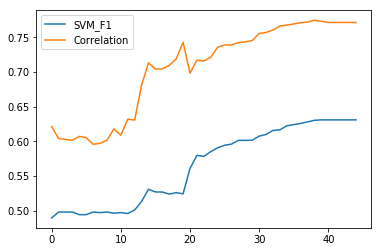

In [35]:
print(cur_f1_scores)
print(two_prediction_corr)
import matplotlib.pyplot as plt
plt.plot(range(len(cur_f1_scores)), cur_f1_scores, label='SVM_F1')
plt.plot(range(len(two_prediction_corr)), two_prediction_corr, label='Correlation')
plt.legend()


In [21]:
num_methods = np.shape(L)[1]

agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
agree_inlier_indexes = np.sum(L,axis=1)==0
print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]
# print('Number of disagreed points = {}'.format(len(disagree_indexes)))
# print('Number of disagreed points (true outliers) = {}'.format(sum(y[disagree_indexes] == 1)))
# print('Number of disagreed points (true inliers) = {}'.format(sum(y[disagree_indexes] == 0)))

#     all_inlier_indexes = np.where(agree_inlier_indexes)[0]
all_inlier_indexes = np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers)
if len(prediction_high_conf_inliers) >0:
    all_inlier_indexes = np.intersect1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)

#     if(len(np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 0 and
#       (len(np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 2000)):
#         all_outlier_indexes = np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     else:
all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     if(len(all_outlier_indexes) > 1000):
#         all_outlier_indexes = np.random.RandomState(1).permutation(all_outlier_indexes)[:1000]

#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
all_inlier_indexes = np.setdiff1d(all_inlier_indexes, prediction_classifier_disagree)

self_agree_index_list = []
if((len(all_outlier_indexes) == 0) or (len(all_inlier_indexes)/ len(all_outlier_indexes) > 1000)):
    for i in range(0, len(index_range)):
        if(index_range[i,1]-index_range[i,0] <= 6):
            continue
        temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
        self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
    self_agree_index_list = [int(i) for i in self_agree_index_list]
#     self_agree_index_list = np.random.RandomState(1).permutation(self_agree_index_list)[:500]
all_outlier_indexes = np.union1d(all_outlier_indexes, self_agree_index_list)
all_outlier_indexes = np.setdiff1d(all_outlier_indexes, prediction_classifier_disagree)
print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))


from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
data_indexes = np.array([int(i) for i in data_indexes])
labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
transformer = RobustScaler().fit(scores_for_training)
scores_transformed = transformer.transform(scores_for_training)
training_data = scores_transformed[data_indexes]
print('Training data shape: ', np.shape(training_data))
print('Training data F-1', metrics.f1_score(y[data_indexes], labels))

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
#     clf = SVC(gamma='auto', probability=True, random_state=0)
#     clf.fit(training_data, labels)
clf = LogisticRegression(random_state=0, penalty='l2', max_iter=100).fit(training_data, labels) 
clf_predictions = clf.predict(scores_transformed)
clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
print("F-1 score from LR:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba > 0.1])))


transformer = RobustScaler().fit(X)
X_transformed = transformer.transform(X)
X_training_data = X_transformed[data_indexes]
print(np.shape(X_training_data))
print(np.shape(labels))

clf_X = SVC(gamma='auto', probability=True, random_state=0)
clf_X.fit(X_training_data, labels)
clf_predictions_X = clf_X.predict(X_transformed)
clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]
print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
cur_f1_scores.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))

agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]

prediction_result_list.append(clf_predict_proba)
classifier_result_list.append(clf_predict_proba_X)

prediction_list.append(np.array([int(i) for i in clf_predictions]))

prediction_high_conf_outliers = np.intersect1d(np.where(prediction_result_list[-1] > 0.99)[0],
                                               np.where(classifier_result_list[-1] > 0.99)[0])
print('length of prediction_high_conf_outliers:' , len(prediction_high_conf_outliers))
prediction_high_conf_inliers = np.intersect1d(np.where(prediction_result_list[-1] < 0.01)[0],
                                               np.where(classifier_result_list[-1] < 0.01)[0])
print('length of prediction high conf inliers: ', len(prediction_high_conf_inliers))

temp_prediction = np.array([int(i) for i in prediction_result_list[-1] > 0.1])
temp_classifier = np.array([int(i) for i in classifier_result_list[-1] > 0.5])
prediction_classifier_disagree = np.where(temp_prediction != temp_classifier)[0]
print('length of prediction-classifier disagree: {}'.format(len(prediction_classifier_disagree)))
print('length of prediction-classifier disagree in training: {}'.format(len(np.where(temp_prediction[data_indexes] != temp_classifier[data_indexes])[0])))
print(np.corrcoef(clf_predict_proba,clf_predict_proba_X))

All agree, Number of outliers = 55
All agree, Number of inliers = 3788
num of inliers = 3787
num of outliers = 57
num of outliers = 57
Training data shape:  (3844, 26)
Training data F-1 0.48684210526315785
F-1 score from LR: 0.42352941176470593
(3844, 10)
(3844,)
F-1 score from SVM: 0.49792531120331945
length of prediction_high_conf_outliers: 57
length of prediction high conf inliers:  4585
length of prediction-classifier disagree: 397
length of prediction-classifier disagree in training: 0
[[1.         0.60564063]
 [0.60564063 1.        ]]


In [79]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler().fit(scores_for_training)
scores_transformed = transformer.transform(scores_for_training)
from sklearn.feature_selection import SelectKBest, mutual_info_classif
clf = SelectKBest(mutual_info_classif, k=26).fit(scores_transformed, clf_predictions_X)
print(clf.scores_)

[0.060394   0.09231781 0.1129055  0.12807603 0.14594223 0.13592194
 0.13450412 0.1398666  0.13111137 0.13618559 0.16265347 0.18082909
 0.20060729 0.20009989 0.21899055 0.21076635 0.21494993 0.22526172
 0.23348437 0.23114429 0.31017955 0.30621549 0.30651975 0.29919923
 0.29861265 0.28209968]


In [ ]:
high_confidence_threshold = 0.99
low_confidence_threshold = 0.01
max_iter = 100
min_max_diff = []
N_size = 6

proba_list = []

L_original = L.copy()
scores_for_training_original = scores_for_training.copy()

index_range_origin = np.array([[0, 60], [60, 120], [120, 150], [150, 156]])
coef_index_range_origin = np.array([[0, 10], [10, 20], [20, 25], [25, 26]])
# index_range_origin = np.array([[0, 120], [120, 240], [240, 270], [270, 276]])
# coef_index_range_origin = np.array([[0, 20], [20, 40], [40, 45], [45, 46]])
remain_params_tracking_origin = np.array(range(0,np.max(coef_index_range_origin)))

counter = 0
last_training_outlier_indexes = []
last_training_inlier_indexes = []

for i_range in range(0, 100):
    index_range = index_range_origin.copy()
    coef_index_range = coef_index_range_origin.copy()
#     coef_remain_index = range(156)
    remain_params_tracking = remain_params_tracking_origin.copy()
    
    print("##################################################################")
    print('L shape', np.shape(L))
    num_methods = np.shape(L)[1]

    agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
    print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    agree_inlier_indexes = np.sum(L,axis=1)==0
    print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]

#     all_inlier_indexes = np.where(agree_inlier_indexes)[0]
    all_inlier_indexes = np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers)
    if len(prediction_high_conf_inliers) >0:
        all_inlier_indexes = np.intersect1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
    print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)

#     if(len(np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 0 and
#       (len(np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 2000)):
#         all_outlier_indexes = np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     else:
    all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     if(len(all_outlier_indexes) > 1000):
#         all_outlier_indexes = np.random.RandomState(1).permutation(all_outlier_indexes)[:1000]
        
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    all_inlier_indexes = np.setdiff1d(all_inlier_indexes, prediction_classifier_disagree)
    
    self_agree_index_list = []
    if((len(all_outlier_indexes) == 0) or (len(all_inlier_indexes)/ len(all_outlier_indexes) > 1000)):
        for i in range(0, len(index_range)):
            if(index_range[i,1]-index_range[i,0] <= 6):
                continue
            temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
            self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
        self_agree_index_list = [int(i) for i in self_agree_index_list]
#     self_agree_index_list = np.random.RandomState(1).permutation(self_agree_index_list)[:500]
    all_outlier_indexes = np.union1d(all_outlier_indexes, self_agree_index_list)
    all_outlier_indexes = np.setdiff1d(all_outlier_indexes, prediction_classifier_disagree)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    
#     if((len(all_outlier_indexes) == len(last_training_outlier_indexes)) and 
#        (len(all_inlier_indexes) == len(last_training_inlier_indexes)) and
#        (sum(all_outlier_indexes == last_training_outlier_indexes) == len(last_training_outlier_indexes)) and
#        sum(all_inlier_indexes == last_training_inlier_indexes) == len(last_training_inlier_indexes)
#       ):
    counter = counter+1
#     else:
#         counter = 0
    last_training_outlier_indexes = all_outlier_indexes
    last_training_inlier_indexes = all_inlier_indexes
    
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
    data_indexes = np.array([int(i) for i in data_indexes])
    labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
    transformer = RobustScaler().fit(scores_for_training_original)
    scores_transformed = transformer.transform(scores_for_training_original)
    training_data = scores_transformed[data_indexes]
    print('Training data shape: ', np.shape(training_data))

    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
#     clf = SVC(gamma='auto', probability=True, random_state=0)
#     clf.fit(training_data, labels)
    clf = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(training_data, labels) 
    clf_predictions = clf.predict(scores_transformed)
    clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
    print("F-1 score from LR:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba > 0.5])))
    
    transformer = RobustScaler().fit(X)
    X_transformed = transformer.transform(X)
    X_training_data = X_transformed[data_indexes]
    print(np.shape(X_training_data))
    print(np.shape(labels))

    clf_X = SVC(gamma='auto', probability=True, random_state=0)
    clf_X.fit(X_training_data, labels)
    clf_predictions_X = clf_X.predict(X_transformed)
    clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
    cur_f1_scores.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
        
    agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
    agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]
        
    prediction_result_list.append(clf_predict_proba)
    classifier_result_list.append(clf_predict_proba_X)
    
    prediction_list.append(np.array([int(i) for i in clf_predictions]))
    
    prediction_high_conf_outliers = np.intersect1d(np.where(prediction_result_list[-1] > high_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] > high_confidence_threshold)[0])
    print('length of prediction_high_conf_outliers:' , len(prediction_high_conf_outliers))
    prediction_high_conf_inliers = np.intersect1d(np.where(prediction_result_list[-1] < low_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] < low_confidence_threshold)[0])
    print('length of prediction high conf inliers: ', len(prediction_high_conf_inliers))
    
    temp_prediction = np.array([int(i) for i in prediction_result_list[-1] > 0.5])
    temp_classifier = np.array([int(i) for i in classifier_result_list[-1] > 0.5])
    prediction_classifier_disagree = np.where(temp_prediction != temp_classifier)[0]
    
    if(len(prediction_high_conf_outliers) > 0 and len(prediction_high_conf_inliers) > 0):
        new_data_indexes = np.concatenate((prediction_high_conf_outliers, prediction_high_conf_inliers), axis = 0)
        new_data_indexes = np.array([int(i) for i in new_data_indexes])
        new_labels = np.concatenate((np.ones(len(prediction_high_conf_outliers)), np.zeros(len(prediction_high_conf_inliers))), axis = 0)
        clf_prune_2 = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(scores_transformed[new_data_indexes], new_labels) 
        print('Coef from both LR and SVM: ', clf_prune_2.coef_[0])
        combined_coef = clf_prune_2.coef_[0]  
    else:
        print('Coef from normal training: ', clf.coef_[0])
        combined_coef = clf.coef_[0]
        print('Combined Coef: ',  combined_coef)

    if(np.max(coef_index_range) >= 2):
        cur_clf_coef = combined_coef 
        proba_list.append(generate_coef_proba(cur_clf_coef))
        combined_proba = get_kf_results(np.stack(proba_list))
        print('Combined_proba', combined_proba)
        cur_threshold = min(combined_proba) #max(max(0, np.mean(combined_proba)-np.std(combined_proba)),
        
        if(counter < 0):
            remain_indexes_after_cond = (generate_decision_on_proba(combined_proba) == 1)
            print('Remain_indexes: ', remain_indexes_after_cond)
            remain_params_tracking = remain_params_tracking[remain_indexes_after_cond]
            print(remain_params_tracking)

            remain_indexes_after_cond_expanded = []
            for i in range(0, len(coef_index_range)): #
                s_e_range = coef_index_range[i,1]-coef_index_range[i,0]
                s1, e1 = coef_index_range[i,0], coef_index_range[i,1]
                s2, e2 = index_range[i,0], index_range[i,1]
                saved_indexes = np.where(remain_indexes_after_cond[s1:e1] == 1)[0]
                for j in range(N_size):
                    remain_indexes_after_cond_expanded.extend(np.array(saved_indexes) + j * s_e_range + s2)

            new_coef_index_range_seq = []
            for i in range(0, len(coef_index_range)): #
                s, e = coef_index_range[i,0], coef_index_range[i,1]
                new_coef_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

            coef_index_range = []
            index_range = []
            cur_sum = 0
            for i in range(0, len(new_coef_index_range_seq)):
                coef_index_range.append([cur_sum, cur_sum + new_coef_index_range_seq[i]])
                index_range.append([cur_sum * 6, 6 * (cur_sum + new_coef_index_range_seq[i])])
                cur_sum += new_coef_index_range_seq[i]

            coef_index_range = np.array(coef_index_range)
            index_range = np.array(index_range)
            print(coef_index_range)
            print(index_range)

            L=L_original[:,remain_indexes_after_cond_expanded]
            scores_for_training = scores_for_training_original[:, remain_indexes_after_cond]
        else:
            remain_indexes_after_cond = ((combined_proba > cur_threshold) == 1)
            print('Remain_indexes: ', remain_indexes_after_cond)
            remain_params_tracking = remain_params_tracking[remain_indexes_after_cond]
            print(remain_params_tracking)

            remain_indexes_after_cond_expanded = []
            for i in range(0, len(coef_index_range)): #
                s_e_range = coef_index_range[i,1]-coef_index_range[i,0]
                s1, e1 = coef_index_range[i,0], coef_index_range[i,1]
                s2, e2 = index_range[i,0], index_range[i,1]
                saved_indexes = np.where(remain_indexes_after_cond[s1:e1] == 1)[0]
                for j in range(N_size):
                    remain_indexes_after_cond_expanded.extend(np.array(saved_indexes) + j * s_e_range + s2)

            new_coef_index_range_seq = []
            for i in range(0, len(coef_index_range)): #
                s, e = coef_index_range[i,0], coef_index_range[i,1]
                new_coef_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

            coef_index_range = []
            index_range = []
            cur_sum = 0
            for i in range(0, len(new_coef_index_range_seq)):
                coef_index_range.append([cur_sum, cur_sum + new_coef_index_range_seq[i]])
                index_range.append([cur_sum * 6, 6 * (cur_sum + new_coef_index_range_seq[i])])
                cur_sum += new_coef_index_range_seq[i]

            coef_index_range = np.array(coef_index_range)
            index_range = np.array(index_range)
            print(coef_index_range)
            print(index_range)

            L=L_original[:,remain_indexes_after_cond_expanded]
            scores_for_training = scores_for_training_original[:, remain_indexes_after_cond]

            L_original = L.copy()
            scores_for_training_original = scores_for_training.copy()
            index_range_origin = index_range.copy()
            coef_index_range_origin = coef_index_range.copy()
            remain_params_tracking_origin = remain_params_tracking.copy()
            proba_list_new = []
            for proba in proba_list:
                proba_list_new.append(proba[remain_indexes_after_cond])
            proba_list = proba_list_new
            counter = 0


##################################################################
L shape (567498, 156)
All agree, Number of outliers = 7
All agree, Number of inliers = 405653
num of inliers = 405653
num of outliers = 7
num of outliers = 5600
Training data shape:  (411253, 26)
F-1 score from LR: 0.0009445606403962393
(411253, 3)
(411253,)
F-1 score from SVM: 0.21107398568019095
length of prediction_high_conf_outliers: 170
length of prediction high conf inliers:  3894
Coef from both LR and SVM:  [-8.06574632e-08  2.49365658e-09  1.05287318e-08  7.71208138e-08
  4.21006595e-08 -2.21786356e-09 -1.20514981e-09  1.75776514e-09
  3.15789174e-09  6.55909865e-09 -6.38151274e-17 -2.63715523e-17
 -4.90913279e-17  6.09186439e-17  8.92000784e-17  9.54526254e-17
  9.69215749e-17  8.49276263e-17  7.38015761e-17  7.04956356e-16
  6.93680770e-16  6.93680770e-16  7.15344285e-16  7.15344285e-16
  7.15344285e-16 -8.65472102e-17]
[0.         1.         1.         1.         1.         0.02067345
 0.11845923 1.         1

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.0008850168274988532
(2680, 3)
(2680,)
F-1 score from SVM: 0.2969778374748153
length of prediction_high_conf_outliers: 171
length of prediction high conf inliers:  24792


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [-1.41283806e-06  9.07420514e-07  4.54446176e-07  5.94137406e-07
 -4.37098189e-07  1.47352261e-08  2.36097508e-07 -1.43089145e-07
  6.72821556e-08  4.27216259e-13  7.35639956e-13  8.96802554e-13
  8.52242339e-13  8.46466377e-13  7.40566833e-13  6.26168497e-13
  5.62140431e-13  4.53219622e-13  4.59417795e-13 -9.46106087e-14
 -9.46106087e-14 -2.24744870e-13 -2.24744870e-13 -2.24744870e-13
  1.11621311e-13]
[0.         1.         1.         1.         0.02335328 1.
 1.         0.13088751 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         0.9632164  0.87763031 0.5409125  0.32218491 0.73498493
 0.99791623]
Combined_proba [0.48780488 0.97560976 0.97560976 0.97560976 0.02147645 0.54558987
 0.97560976 0.55165244 0.97560976 0.73574968 0.90257087 0.83013553
 0.94915644 0.97560976 0.97560976 0.97560976 0.97560976 0.97174715
 0.97560976 0.95766654 0.91591722 0.75166464 0.64496825 0.84633411
 0.63187879]
Remain_inde

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.0008738691105628011
(2674, 3)
(2674,)
F-1 score from SVM: 0.30063226595961656
length of prediction_high_conf_outliers: 1785
length of prediction high conf inliers:  33006


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [-4.48311181e-02  2.48362930e-02  2.70928732e-02  1.05711529e-02
 -3.15223091e-02 -1.44477778e-02  7.43777005e-03  2.16708160e-02
  1.02697791e-06  1.94611021e-06  2.15731048e-06  2.13600531e-06
  2.16615063e-06  2.23752288e-06  2.21048754e-06  2.25465291e-06
  2.32332430e-06  2.33847689e-06  9.34996585e-07  9.34996585e-07
  9.35768720e-07  9.35768720e-07  9.35768720e-07  4.48330228e-07]
[0.         1.         1.         1.         0.02655676 0.14517961
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 0.76902134 0.57580744 0.97808283 0.90402888 1.         0.34964336]
Combined_proba [0.32786885 0.98360656 0.98360656 0.98360656 0.37541508 0.70333758
 0.69865164 0.98360656 0.82238913 0.93451485 0.8858288  0.96582646
 0.98360656 0.98360656 0.98360656 0.98360656 0.98101038 0.98360656
 0.89581565 0.80440582 0.82590011 0.72990616 0.89671637 0.53934259]
Remain_indexes:  [False  True  True  True  T

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.012787479721347457
(19100, 3)
(19100,)
F-1 score from SVM: 0.30623268698060946
length of prediction_high_conf_outliers: 179
length of prediction high conf inliers:  0
Coef from normal training:  [5.92863570e-09 3.86670629e-07 8.04747936e-07 3.27730791e-07
 2.67458034e-07 2.06103209e-07 9.86661573e-09 1.85653852e-07
 3.51601044e-07 4.29260551e-07 4.16009472e-07 4.09538877e-07
 4.08654048e-07 3.89528106e-07 3.88266152e-07 3.96967484e-07
 3.97335516e-07 1.27272777e-07 1.27272777e-07 1.34676841e-07
 1.34676841e-07 1.34676841e-07 9.79731337e-08]
Combined Coef:  [5.92863570e-09 3.86670629e-07 8.04747936e-07 3.27730791e-07
 2.67458034e-07 2.06103209e-07 9.86661573e-09 1.85653852e-07
 3.51601044e-07 4.29260551e-07 4.16009472e-07 4.09538877e-07
 4.08654048e-07 3.89528106e-07 3.88266152e-07 3.96967484e-07
 3.97335516e-07 1.27272777e-07 1.27272777e-07 1.34676841e-07
 1.34676841e-07 1.34676841e-07 9.79731337e-08]
[0.         1.         1.         1.         1.         1.
 0.03

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.016831351532406634
(225489, 3)
(225489,)
F-1 score from SVM: 0.32176380702903296
length of prediction_high_conf_outliers: 6032
length of prediction high conf inliers:  0
Coef from normal training:  [3.55762821e-06 4.83972658e-02 8.70159830e-02 5.06692922e-02
 3.87039282e-02 2.43293307e-02 4.28432352e-02 8.02009184e-02
 1.00343311e-01 9.76132870e-02 8.17539207e-02 7.82873626e-02
 6.65477176e-02 5.22056857e-02 4.29609159e-02 4.15179503e-02
 4.14397067e-02 5.42386362e-02 5.42386362e-02 5.49546140e-02
 5.49546140e-02 5.49546140e-02]
Combined Coef:  [3.55762821e-06 4.83972658e-02 8.70159830e-02 5.06692922e-02
 3.87039282e-02 2.43293307e-02 4.28432352e-02 8.02009184e-02
 1.00343311e-01 9.76132870e-02 8.17539207e-02 7.82873626e-02
 6.65477176e-02 5.22056857e-02 4.29609159e-02 4.15179503e-02
 4.14397067e-02 5.42386362e-02 5.42386362e-02 5.49546140e-02
 5.49546140e-02 5.49546140e-02]
[0.         0.99725731 1.         1.         0.17871066 0.03433636
 0.8370554  1.         1

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.0017988874108114644
(308797, 3)
(308797,)
F-1 score from SVM: 0.24666703854521116
length of prediction_high_conf_outliers: 7378
length of prediction high conf inliers:  207487


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [3.25847559e-05 5.23283145e-02 2.21203545e-01 2.17291461e-01
 1.93363364e-01 2.38868074e-01 6.97424732e-01 1.45901883e+00
 1.39304400e+00 1.26971629e+00 1.48220825e+00 1.57245305e+00
 1.63852804e+00 1.69069396e+00 1.75605540e+00 1.78283137e+00
 2.15519529e+00 2.15519529e+00 2.52058481e+00 2.52058481e+00
 2.52058481e+00]
[0.         0.03948839 0.69087643 0.44732402 0.19950254 0.87063812
 0.97059651 1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.        ]
Combined_proba [0.82599294 0.83297329 0.6340318  0.6233412  0.55615313 0.78310558
 0.90560056 0.96698682 0.94244262 0.98277202 0.99173554 0.99173554
 0.99173554 0.98365831 0.93264612 0.8944469  0.88335135 0.79874435
 0.91052134 0.83127383 0.93614011]
Remain_indexes:  [ True  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True]
[ 3  4  6  7  9 10 11 12 13 14 15

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.0040447620331670485
(211555, 3)
(211555,)
F-1 score from SVM: 0.22811452153727108
length of prediction_high_conf_outliers: 8028
length of prediction high conf inliers:  497997


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [ 8.46573995e-07  3.45503505e-03 -6.74646797e-04  2.02030832e-04
  1.91318739e-04  3.57391533e-03  4.55405582e-03  4.71552308e-03
  4.38118144e-03  4.62819123e-03  4.39802664e-03  3.95869282e-03
  3.81204281e-03  3.97806564e-03  4.10304515e-03 -7.65294483e-04
 -7.65294483e-04 -1.09782981e-03 -1.09782981e-03 -1.09782981e-03]
[0.98597856 1.         0.90255658 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.73213553 0.48554925 0.04523228
 0.22228973 0.        ]
Combined_proba [0.84868594 0.85666502 0.67212043 0.67676798 0.81387074 0.91899055
 0.97166954 0.95060678 0.9852157  0.9929078  0.9929078  0.9929078
 0.98597628 0.94219986 0.90941897 0.8619023  0.75431951 0.7877853
 0.74489311 0.80335428]
Remain_indexes:  [ True  True False  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True]
[ 3  4  7  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.0008401373871727258
(465243, 3)
(465243,)
F-1 score from SVM: 0.24007818014007276
length of prediction_high_conf_outliers: 322
length of prediction high conf inliers:  0
Coef from normal training:  [ 9.49041510e-06  5.42302904e-04  3.28644106e-04  3.47990626e-04
  3.86500750e-04  5.45228304e-04  5.75178836e-04  5.44620413e-04
  5.61962262e-04  5.48165142e-04  5.09072710e-04  4.99524764e-04
  5.18833690e-04  5.31032315e-04  2.23246409e-07  2.23246409e-07
 -2.29106407e-05 -2.29106407e-05 -2.29106407e-05]
Combined Coef:  [ 9.49041510e-06  5.42302904e-04  3.28644106e-04  3.47990626e-04
  3.86500750e-04  5.45228304e-04  5.75178836e-04  5.44620413e-04
  5.61962262e-04  5.48165142e-04  5.09072710e-04  4.99524764e-04
  5.18833690e-04  5.31032315e-04  2.23246409e-07  2.23246409e-07
 -2.29106407e-05 -2.29106407e-05 -2.29106407e-05]
[0.93233893 1.         0.99624212 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.77

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.002272380079437825
(278059, 3)
(278059,)
F-1 score from SVM: 0.3353556802669498
length of prediction_high_conf_outliers: 5326
length of prediction high conf inliers:  247148


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [9.41622928e-08 1.10616131e-03 7.22373455e-04 7.17472744e-04
 8.44516003e-04 1.28181092e-03 1.33166609e-03 1.25667566e-03
 1.23794321e-03 1.21245551e-03 1.13932101e-03 1.11812621e-03
 1.14093140e-03 1.14739478e-03 2.69405932e-04 2.69405932e-04
 2.51052552e-04 2.51052552e-04]
[0.         1.         1.         0.95873404 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.57372415 0.81807592 0.06090233 0.27950275]
Combined_proba [0.76415191 0.88834126 0.74778524 0.85044451 0.93689319 0.97793042
 0.96152241 0.98848295 0.99447514 0.99447514 0.99447514 0.98907545
 0.95497337 0.92943688 0.82042859 0.73631163 0.62619015 0.6567017 ]
Remain_indexes:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False  True]
[ 3  4  7  9 10 11 12 13 14 15 16 17 18 19 20 21 24]
[[ 0  4]
 [ 4 14]
 [14 17]
 [17 17]]
[[  0  24]
 [ 24  84]
 [ 84 102]
 [102 102]]
##############################

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.005112123034624967
(249210, 3)
(249210,)
F-1 score from SVM: 0.305428926647327
length of prediction_high_conf_outliers: 6114
length of prediction high conf inliers:  511995


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [-4.86021480e-10  3.58247349e-03 -7.35883222e-04  5.47791371e-04
  5.13221053e-03  5.85153858e-03  5.85445158e-03  5.20299321e-03
  5.52589321e-03  4.97113578e-03  4.15324009e-03  3.78470773e-03
  3.97079112e-03  4.14307102e-03 -3.14590731e-03 -3.14590731e-03
 -4.11200408e-03]
[0.86033891 1.         0.6222358  0.98002696 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.07068095 0.31338818 0.        ]
Combined_proba [0.77372276 0.89945158 0.73529276 0.86333828 0.94317247 0.9801264
 0.96535103 0.98962892 0.99502488 0.99502488 0.99502488 0.99016247
 0.95945363 0.93645808 0.74582684 0.6942297  0.59135825]
Remain_indexes:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False]
[ 3  4  7  9 10 11 12 13 14 15 16 17 18 19 20 21]
[[ 0  4]
 [ 4 14]
 [14 16]
 [16 16]]
[[ 0 24]
 [24 84]
 [84 96]
 [96 96]]
##################################################################
L

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.0008647250319730264
(466884, 3)
(466884,)
F-1 score from SVM: 0.317946505608283
length of prediction_high_conf_outliers: 264
length of prediction high conf inliers:  0
Coef from normal training:  [ 1.50681723e-07  5.80646629e-04  3.58190003e-04  3.60391697e-04
  4.35422136e-04  5.91793885e-04  6.13336051e-04  5.71583795e-04
  5.84418739e-04  5.60818608e-04  5.10541038e-04  4.92837686e-04
  5.10089323e-04  5.21441199e-04 -4.25340341e-05 -4.25340341e-05]
Combined Coef:  [ 1.50681723e-07  5.80646629e-04  3.58190003e-04  3.60391697e-04
  4.35422136e-04  5.91793885e-04  6.13336051e-04  5.71583795e-04
  5.84418739e-04  5.60818608e-04  5.10541038e-04  4.92837686e-04
  5.10089323e-04  5.21441199e-04 -4.25340341e-05 -4.25340341e-05]
[0.35282277 1.         0.67458958 0.90110271 0.99456757 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.         0.08283896]
Combined_proba [0.73563226 0.90855099 0.72979926 0.86675588 0.94782361 0.98192491

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.0038429244978363366
(289574, 3)
(289574,)
F-1 score from SVM: 0.27779871843196385
length of prediction_high_conf_outliers: 6174
length of prediction high conf inliers:  442375


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [9.52473332e-07 1.18152166e-04 7.95152450e-05 6.83343566e-05
 8.30242413e-05 1.20502709e-04 1.25369563e-04 1.19055755e-04
 1.20905405e-04 1.18499517e-04 1.11147248e-04 1.09550073e-04
 1.12387642e-04 1.13597386e-04 1.12949604e-05]
[0.         1.         0.73043043 0.39894354 0.93848009 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.09825869]
Combined_proba [0.67458394 0.91614012 0.72985164 0.82793328 0.94704822 0.98342492
 0.97110189 0.99135027 0.99585062 0.99585062 0.99585062 0.99179525
 0.96618332 0.94700446 0.6301924 ]
Remain_indexes:  [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False]
[ 3  4  7  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  4]
 [ 4 14]
 [14 14]
 [14 14]]
[[ 0 24]
 [24 84]
 [84 84]
 [84 84]]
##################################################################
L shape (567498, 84)
All agree, Number of outliers = 49
All agree, Number of inliers = 466462
num of inliers =

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.000817052363444116
(427751, 3)
(427751,)
F-1 score from SVM: 0.27706766917293235
length of prediction_high_conf_outliers: 254
length of prediction high conf inliers:  0
Coef from normal training:  [2.91826174e-06 3.11228175e-04 1.65676454e-04 2.02690068e-04
 2.19066519e-04 3.24271372e-04 3.43546338e-04 3.26741424e-04
 3.32330719e-04 3.25308584e-04 3.03569794e-04 2.98613714e-04
 3.08765987e-04 3.14548963e-04]
Combined Coef:  [2.91826174e-06 3.11228175e-04 1.65676454e-04 2.02690068e-04
 2.19066519e-04 3.24271372e-04 3.43546338e-04 3.26741424e-04
 3.32330719e-04 3.25308584e-04 3.03569794e-04 2.98613714e-04
 3.08765987e-04 3.14548963e-04]
[0.         1.         0.11590429 0.44961043 0.78702012 1.
 1.         1.         1.         1.         1.         0.96955555
 1.         1.        ]
Combined_proba [0.62289168 0.92256616 0.68280586 0.79894302 0.93478553 0.98469504
 0.97331631 0.99201308 0.99616858 0.99616858 0.99616858 0.99009106
 0.96877464 0.95106542]
Remain_indexe

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.00360191294872571
(276984, 3)
(276984,)
F-1 score from SVM: 0.29174638780761364
length of prediction_high_conf_outliers: 6831
length of prediction high conf inliers:  391053


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [ 3.57436597e-08 -2.68765568e-02  2.95079739e-02  2.77676661e-01
  2.57169814e-01  2.34844032e-01  1.79118020e-01  1.95619968e-01
  1.42881859e-01  7.66600211e-02  4.12644262e-02  4.73108953e-02
  5.62313721e-02]
[0.13837662 0.         0.50828435 1.         1.         1.
 1.         1.         1.         1.         0.8445202  0.99153365
 1.        ]
Combined_proba [0.86675196 0.63420758 0.77825557 0.93942713 0.98578436 0.9752155
 0.99258154 0.99644128 0.99644128 0.99644128 0.97973014 0.97039449
 0.95454831]
Remain_indexes:  [ True False  True  True  True  True  True  True  True  True  True  True
  True]
[ 4  9 10 11 12 13 14 15 16 17 18 19]
[[ 0  2]
 [ 2 12]
 [12 12]
 [12 12]]
[[ 0 12]
 [12 72]
 [72 72]
 [72 72]]
##################################################################
L shape (567498, 72)
All agree, Number of outliers = 60
All agree, Number of inliers = 480062
num of inliers = 380941
num of outliers = 6831
num of outliers = 6831
Training data shap

/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [ 5.49510735e-07  3.05886249e-03  2.38478457e-01  9.76490868e-02
  8.71220931e-02  5.15462901e-02  1.18201864e-01  6.72697060e-02
  2.32406532e-03 -2.46843363e-02  4.74739248e-03  3.59712170e-02]
[0.16769529 0.9002185  1.         1.         1.         1.
 1.         1.         0.57606153 0.         1.         1.        ]
Combined_proba [0.82030301 0.78635942 0.9434519  0.98672892 0.97686231 0.99307446
 0.99667774 0.99667774 0.96850907 0.9146318  0.97236164 0.95756836]
Remain_indexes:  [ True False  True  True  True  True  True  True  True  True  True  True]
[ 4 10 11 12 13 14 15 16 17 18 19]
[[ 0  1]
 [ 1 11]
 [11 11]
 [11 11]]
[[ 0  6]
 [ 6 66]
 [66 66]
 [66 66]]
##################################################################
L shape (567498, 66)
All agree, Number of outliers = 60
All agree, Number of inliers = 498163
num of inliers = 487280
num of outliers = 7167
num of outliers = 7167
Training data shape:  (494447, 11)


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


F-1 score from LR: 0.005500855174964175
(494447, 3)
(494447,)
F-1 score from SVM: 0.29757738896366087
length of prediction_high_conf_outliers: 7182
length of prediction high conf inliers:  511894


/home/yizhouyan/ENV3/lib/python3.5/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Coef from both LR and SVM:  [ 4.09718085e-05  3.63018409e-01  4.95673442e-01  2.54719550e-01
 -5.54643091e-02 -1.17481605e-01  1.73302600e-01  1.64365159e-02
  5.27097861e-01  1.17861668e+00  1.75101678e+00]
[0.64901098 1.         1.         1.         0.20184778 0.
 1.         0.94879918 1.         1.         1.        ]
Combined_proba [0.80963061 0.94697515 0.98755578 0.97830391 0.94377685 0.93457944
 0.99688474 0.96728104 0.91995069 0.97408365 0.96021207]
Remain_indexes:  [False  True  True  True  True  True  True  True  True  True  True]
[10 11 12 13 14 15 16 17 18 19]
[[ 0  0]
 [ 0 10]
 [10 10]
 [10 10]]
[[ 0  0]
 [ 0 60]
 [60 60]
 [60 60]]
##################################################################
L shape (567498, 60)
All agree, Number of outliers = 4169
All agree, Number of inliers = 525426
num of inliers = 505660
num of outliers = 7300
num of outliers = 7257
Training data shape:  (512917, 10)
F-1 score from LR: 0.010241073046945805
(512917, 3)
(512917,)
F-1 score from S

In [30]:
high_confidence_threshold = 0.99
low_confidence_threshold = 0.01
max_iter = 100
remain_params_tracking = np.array(range(0,np.max(coef_index_range)))
print(remain_params_tracking)
min_max_diff = []
N_size = 6

for i_range in range(0, 30):
    print("##################################################################")
    print('L shape', np.shape(L))
    num_methods = np.shape(L)[1]

#     agree_outlier_indexes = (np.sum(L,axis=1)==np.shape(L)[1])
#     print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
#     agree_inlier_indexes = (np.sum(L,axis=1)==0)
#     print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

#     all_inlier_indexes = np.union1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
#     print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))

#     disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]

    ########################################################################

    agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
    print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    agree_inlier_indexes = np.sum(L,axis=1)==0
    print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]
    # print('Number of disagreed points = {}'.format(len(disagree_indexes)))
    # print('Number of disagreed points (true outliers) = {}'.format(sum(y[disagree_indexes] == 1)))
    # print('Number of disagreed points (true inliers) = {}'.format(sum(y[disagree_indexes] == 0)))

#     all_inlier_indexes = np.where(agree_inlier_indexes)[0]
    all_inlier_indexes = np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers)
    if len(prediction_high_conf_inliers) >0:
        all_inlier_indexes = np.intersect1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
    print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)

#     if(len(np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 0 and
#       (len(np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)) > 2000)):
#         all_outlier_indexes = np.intersect1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     else:
    all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
#     if(len(all_outlier_indexes) > 1000):
#         all_outlier_indexes = np.random.RandomState(1).permutation(all_outlier_indexes)[:1000]
        
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    all_inlier_indexes = np.setdiff1d(all_inlier_indexes, prediction_classifier_disagree)
    
    self_agree_index_list = []
    if((len(all_outlier_indexes) == 0) or (len(all_inlier_indexes)/ len(all_outlier_indexes) > 1000)):
        for i in range(0, len(index_range)):
            if(index_range[i,1]-index_range[i,0] <= 6):
                continue
            temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
            self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
        self_agree_index_list = [int(i) for i in self_agree_index_list]
#     self_agree_index_list = np.random.RandomState(1).permutation(self_agree_index_list)[:500]
    all_outlier_indexes = np.union1d(all_outlier_indexes, self_agree_index_list)
    all_outlier_indexes = np.setdiff1d(all_outlier_indexes, prediction_classifier_disagree)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import StandardScaler
    data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
    data_indexes = np.array([int(i) for i in data_indexes])
    labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
    transformer = RobustScaler().fit(scores_for_training)
    scores_transformed = transformer.transform(scores_for_training)
    training_data = scores_transformed[data_indexes]
    print('Training data shape: ', np.shape(training_data))

    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import SVC
#     clf = SVC(gamma='auto', probability=True, random_state=0)
#     clf.fit(training_data, labels)
    clf = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(training_data, labels) 
    clf_predictions = clf.predict(scores_transformed)
    clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
    print("F-1 score from LR:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba > 0.5])))
    
    transformer = RobustScaler().fit(X)
    X_transformed = transformer.transform(X)
    X_training_data = X_transformed[data_indexes]
    print(np.shape(X_training_data))
    print(np.shape(labels))

    clf_X = SVC(gamma='auto', probability=True, random_state=0)
    clf_X.fit(X_training_data, labels)
    clf_predictions_X = clf_X.predict(X_transformed)
    clf_predict_proba_X = clf_X.predict_proba(X_transformed)[:,1]
    print("F-1 score from SVM:",metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
    cur_f1_scores.append(metrics.f1_score(y, np.array([int(i) for i in clf_predict_proba_X > 0.5])))
        
    agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
    agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]
        
    prediction_result_list.append(clf_predict_proba)
    classifier_result_list.append(clf_predict_proba_X)
    
    prediction_list.append(np.array([int(i) for i in clf_predictions]))
    
    prediction_high_conf_outliers = np.intersect1d(np.where(prediction_result_list[-1] > high_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] > high_confidence_threshold)[0])
    print('length of prediction_high_conf_outliers:' , len(prediction_high_conf_outliers))
    prediction_high_conf_inliers = np.intersect1d(np.where(prediction_result_list[-1] < low_confidence_threshold)[0],
                                                   np.where(classifier_result_list[-1] < low_confidence_threshold)[0])
    print('length of prediction high conf inliers: ', len(prediction_high_conf_inliers))
    
    temp_prediction = np.array([int(i) for i in prediction_result_list[-1] > 0.5])
    temp_classifier = np.array([int(i) for i in classifier_result_list[-1] > 0.5])
    prediction_classifier_disagree = np.where(temp_prediction != temp_classifier)[0]
    
    if np.max(coef_index_range) >= 2:
        if(len(prediction_high_conf_outliers) > 0 and len(prediction_high_conf_inliers) > 0):
            new_data_indexes = np.concatenate((prediction_high_conf_outliers, prediction_high_conf_inliers), axis = 0)
            new_data_indexes = np.array([int(i) for i in new_data_indexes])
            new_labels = np.concatenate((np.ones(len(prediction_high_conf_outliers)), np.zeros(len(prediction_high_conf_inliers))), axis = 0)
            clf_prune_2 = LogisticRegression(random_state=0, penalty='l2', max_iter=max_iter).fit(scores_transformed[new_data_indexes], new_labels) 
            print('Coef from both LR and SVM: ', clf_prune_2.coef_[0])
            combined_coef = clf_prune_2.coef_[0]  
        else:
            print('Coef from normal training: ', clf.coef_[0])
            combined_coef = clf.coef_[0]
            print('Combined Coef: ',  combined_coef)

        if(np.max(coef_index_range) >= 2 and len(set(combined_coef)) > 1):
            cur_clf_coef = combined_coef 
            remain_indexes_after_cond = (generate_coef_decisions(cur_clf_coef) == 1)
            print('Remain_indexes: ', remain_indexes_after_cond)
            remain_params_tracking = remain_params_tracking[remain_indexes_after_cond]
            print(remain_params_tracking)
            
            remain_indexes_after_cond_expanded = []
            for i in range(0, len(coef_index_range)): #
                s_e_range = coef_index_range[i,1]-coef_index_range[i,0]
                s1, e1 = coef_index_range[i,0], coef_index_range[i,1]
                s2, e2 = index_range[i,0], index_range[i,1]
                saved_indexes = np.where(remain_indexes_after_cond[s1:e1] == 1)[0]
                for j in range(N_size):
                    remain_indexes_after_cond_expanded.extend(np.array(saved_indexes) + j * s_e_range + s2)

            new_coef_index_range_seq = []
            for i in range(0, len(coef_index_range)): #
                s, e = coef_index_range[i,0], coef_index_range[i,1]
                new_coef_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

            coef_index_range = []
            index_range = []
            cur_sum = 0
            for i in range(0, len(new_coef_index_range_seq)):
                coef_index_range.append([cur_sum, cur_sum + new_coef_index_range_seq[i]])
                index_range.append([cur_sum * 6, 6 * (cur_sum + new_coef_index_range_seq[i])])
                cur_sum += new_coef_index_range_seq[i]

            coef_index_range = np.array(coef_index_range)
            index_range = np.array(index_range)
            print(coef_index_range)
            print(index_range)

            L=L[:,remain_indexes_after_cond_expanded]
            scores_for_training = scores_for_training[:, remain_indexes_after_cond]

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
##################################################################
L shape (5473, 156)
All agree, Number of outliers = 55
All agree, Number of inliers = 3788
num of inliers = 3788
num of outliers = 55
num of outliers = 55
Training data shape:  (3843, 26)
F-1 score from LR: 0.38451612903225807
(3843, 10)
(3843,)
F-1 score from SVM: 0.48945147679324896
length of prediction_high_conf_outliers: 57
length of prediction high conf inliers:  4596
Coef from both LR and SVM:  [0.14236451 0.15635406 0.10511819 0.11718949 0.11599183 0.12917098
 0.12295575 0.11890787 0.12193623 0.12599594 0.17927003 0.14618996
 0.12512068 0.12150168 0.11431485 0.11153864 0.10734778 0.10519833
 0.10321618 0.10088406 0.09577959 0.1006787  0.09917587 0.11325712
 0.1017805  0.29550274]
[4.16204204e-04 1.62114735e-03 4.20385015e-06 2.44485323e-05
 2.09711867e-05 1.01459720e-04 4.95470065e-05 3.03323764e-05
 4.38756555e-05 7.06967025e-05 1.1

F-1 score from SVM: 0.511240632805995
length of prediction_high_conf_outliers: 270
length of prediction high conf inliers:  4600
##################################################################
L shape (5473, 6)
All agree, Number of outliers = 300
All agree, Number of inliers = 4673
num of inliers = 4576
num of outliers = 300
num of outliers = 299
Training data shape:  (4875, 1)
F-1 score from LR: 0.5061378659112371
(4875, 10)
(4875,)
F-1 score from SVM: 0.511240632805995
length of prediction_high_conf_outliers: 270
length of prediction high conf inliers:  4600
##################################################################
L shape (5473, 6)
All agree, Number of outliers = 300
All agree, Number of inliers = 4673
num of inliers = 4576
num of outliers = 300
num of outliers = 299
Training data shape:  (4875, 1)
F-1 score from LR: 0.5061378659112371
(4875, 10)
(4875,)
F-1 score from SVM: 0.511240632805995
length of prediction_high_conf_outliers: 270
length of prediction high conf inli

In [228]:
keep = 

In [230]:
keep == 1

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False])

In [231]:
# compute weights
coef = combined_coef
print('Current Weights: ', coef)
np.array(range(0,26))[]

Current Weights:  [0.25209058 0.25209058 0.25209058 0.25209058 0.25209058 0.25209058
 0.25209058 0.25209058 0.25209058 0.25209058 0.25209058 0.25209058
 0.25209058 0.25209058 0.25209058 0.25209058 0.25209058 0.25209058
 0.25209058 0.25209058 0.25209058 0.25209058 0.25209058 0.25209058
 0.25209058 0.25209058]


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18])

In [41]:
import matplotlib.pyplot as plt
plt.plot(range(len(cur_f1_scores)), cur_f1_scores, label='best-f1')
# plt.plot(range(len(svm_diffs)), svm_diffs, label='svm_diffs')
plt.plot(range(len(lr_svm_diffs)), lr_svm_diffs, label='lr_svm_diffs')
# new_result = 0.1 * np.array(lr_svm_diffs) + 0.9 * np.array(high_conf_outlier_portion)
# plt.plot(range(len(high_conf_outlier_portion)), high_conf_outlier_portion, label='high_conf_outlier_portion')

plt.legend()

In [42]:
for i in range(0, len(smoothed_lr_svm_diffs)-1):
    if((smoothed_lr_svm_diffs[i+1] < smoothed_lr_svm_diffs[i]) and (smoothed_lr_svm_diffs[i+1] > 0)):
        break
print(i + 1)
print(high_conf_outlier_portion[i + 1])
print(cur_f1_scores[i + 1])
print(np.max(cur_f1_scores))

NameError: name 'smoothed_lr_svm_diffs' is not defined

In [ ]:
for i in range(len(high_conf_outlier_portion)):
    print(i, high_conf_outlier_portion[i])

In [70]:
def smooth_list(L, factor = 2):
    new_list = []
    for i in range(0, len(L)):
        all_sum = 0
        count = 0
        for j in range(max(0, i-factor), i):
            all_sum += L[j]
            count += 1
        all_sum += L[i]
        count += 1
        for j in range(i + 1, min(len(L), i + 1 + factor)):
            all_sum += L[j]
            count += 1
        new_list.append(all_sum/count)
    return new_list

In [71]:
smoothed_lr_svm_diffs = smooth_list(lr_svm_diffs, factor = 1)

In [241]:
high_conf_outlier_portion

[0.12075112907059662,
 0.19633943427620631,
 0.2374613739006418,
 0.2702638459710007,
 0.2926075588305206,
 0.30995959115759447,
 0.3208937485143808,
 0.324459234608985,
 0.3265985262657476,
 0.3304017114333254,
 0.33586879011171855,
 0.34181126693605896,
 0.3456144521036368,
 0.3487045400522938,
 0.3534585215117661,
 0.3577371048252912,
 0.36058949370097454,
 0.36344188257665794,
 0.3658188733063941,
 0.37152365105776086,
 0.3762776325172332,
 0.37699072973615405,
 0.37556453529831235,
 0.37152365105776086,
 0.3750891371523651,
 0.37532683622533874,
 0.34347516044687426,
 0.34941763727121466]

In [156]:
min_max_diff = (min_max_diff-min(min_max_diff))/(max(min_max_diff)-min(min_max_diff))

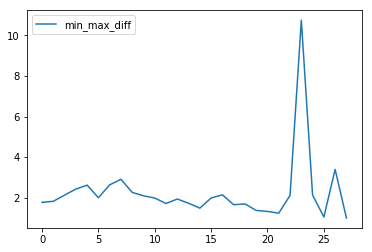

In [171]:
import matplotlib.pyplot as plt
plt.plot(range(len(cur_f1_scores)), min_max_diff, label='min_max_diff')
plt.legend()

In [225]:
print(cur_f1_scores)
print(high_conf_outlier_portion)
# print(min_max_diff)
# print(( np.array(lr_svm_diffs))[:-1])

[0.3997050147492625, 0.47187293183322304, 0.48916797488226066, 0.4958627030340177, 0.5050746268656716, 0.5080858571008527, 0.5106631609699094, 0.5132382892057027, 0.5130737943056363, 0.5159235668789809, 0.513840830449827, 0.5163511187607573, 0.5164051355206847, 0.5213189312109152, 0.520656479909451, 0.5221313786298281, 0.519831223628692, 0.5204941044357103, 0.5205020920502091, 0.5192200557103064, 0.5204872646733112, 0.51974592653963, 0.5192943770672547, 0.5177637014596529, 0.517062517062517, 0.5172320217096337, 0.5186385737439221, 0.5199150292087095]
[0.12075112907059662, 0.19633943427620631, 0.2374613739006418, 0.2702638459710007, 0.2926075588305206, 0.30995959115759447, 0.3208937485143808, 0.324459234608985, 0.3265985262657476, 0.3304017114333254, 0.33586879011171855, 0.34181126693605896, 0.3456144521036368, 0.3487045400522938, 0.3534585215117661, 0.3577371048252912, 0.36058949370097454, 0.36344188257665794, 0.3658188733063941, 0.37152365105776086, 0.3762776325172332, 0.3769907297361

In [1122]:
query_index = 0
for query_index in range(np.shape(prediction_result_list)[0]):
    prediction = np.array(prediction_result_list)[query_index,:]
    classify = np.array(classifier_result_list)[query_index,:]
    prediction = np.array([int(i) for i in prediction>0.5])
    classify = np.array([int(i) for i in classify>0.5])
    print('number of difference: ', sum(prediction!=classify))
    diff = np.where(prediction != classify)[0]
    print(metrics.f1_score(y[diff], classify[diff]))
    print(metrics.f1_score(y[diff], prediction[diff]))
    
    same = np.where(prediction == classify)[0]
    print(metrics.f1_score(y[same], classify[same]))
    print(metrics.f1_score(y[same], prediction[same]))
    same = np.intersect1d(np.intersect1d(np.where(prediction == classify)[0], 
                          np.union1d(np.where(np.array(classifier_result_list)[query_index,:] > 0.99)[0], 
                                    np.where(np.array(classifier_result_list)[query_index,:] < 0.01)[0])
                         ),
                          np.union1d(np.where(np.array(prediction_result_list)[query_index,:] > 0.99)[0], 
                                    np.where(np.array(prediction_result_list)[query_index,:] < 0.01)[0])
                         )
    print(len(same))
    print(sum(classify[same]))
    print(metrics.f1_score(y[same], classify[same]))
    print(metrics.f1_score(y[same], prediction[same]))

number of difference:  284
0.43511450381679384
0.3398058252427185
0.5432780847145489
0.5432780847145489
4167
359
0.687603305785124
0.687603305785124


In [1068]:
classifier_result_list

[array([0.00022781, 0.00043399, 0.0012116 , ..., 0.00124072, 0.00250151,
        0.18181332]),
 array([1.65645778e-04, 2.85762514e-04, 6.78681483e-04, ...,
        9.10293632e-04, 1.24575154e-03, 9.37642671e-01]),
 array([1.10471336e-04, 2.30912512e-04, 6.12271583e-04, ...,
        9.70832357e-04, 1.34142865e-03, 9.22294895e-01]),
 array([1.18120320e-04, 1.34857469e-04, 5.02687133e-04, ...,
        7.41587123e-04, 1.22642603e-03, 9.70676185e-01]),
 array([1.45045644e-04, 1.46358133e-04, 3.52544136e-04, ...,
        1.90195636e-03, 1.56679354e-03, 9.75049665e-01]),
 array([1.62525249e-04, 1.65351948e-04, 4.43056035e-04, ...,
        2.07967560e-03, 1.64262618e-03, 9.79657404e-01])]

### iterative train LR

In [922]:
breakcond = 0
for i in range(0, 26):
    print('L shape', np.shape(L))
    num_methods = np.shape(L)[1]

    # agree_outlier_indexes = (np.sum(L,axis=1)==np.shape(L)[1])
    # print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    # agree_inlier_indexes = (np.sum(L,axis=1)==0)
    # print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    # all_inlier_indexes = np.union1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
    # print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
    # all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], prediction_high_conf_outliers)
    # print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))

    # disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]

    ########################################################################

    agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
    print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    agree_inlier_indexes = np.sum(L,axis=1)==0
    print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]
    # print('Number of disagreed points = {}'.format(len(disagree_indexes)))
    # print('Number of disagreed points (true outliers) = {}'.format(sum(y[disagree_indexes] == 1)))
    # print('Number of disagreed points (true inliers) = {}'.format(sum(y[disagree_indexes] == 0)))

    self_agree_index_list = []
    for i in range(0, len(index_range)):
        if(index_range[i,1]-index_range[i,0] < 1):
            continue
        temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
        self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
    self_agree_index_list = [int(i) for i in self_agree_index_list]
    # print(sum(y[self_agree_index_list])/len(self_agree_index_list))
    # print(sum(y[self_agree_index_list]))
    # print(len(self_agree_index_list))

#     all_inlier_indexes = np.where(agree_inlier_indexes)[0]
    all_inlier_indexes = np.union1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
    print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)
    all_outlier_indexes = np.union1d(np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list), prediction_high_conf_outliers)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))

    ####################################################################
#     agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
#     print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
#     agree_inlier_indexes = np.sum(L,axis=1)==0
#     print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

#     disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==np.shape(L)[1])==0)[0]
#     # print('Number of disagreed points = {}'.format(len(disagree_indexes)))
#     # print('Number of disagreed points (true outliers) = {}'.format(sum(y[disagree_indexes] == 1)))
#     # print('Number of disagreed points (true inliers) = {}'.format(sum(y[disagree_indexes] == 0)))

#     self_agree_index_list = []
#     for i in range(0, len(index_range)):
#         if(index_range[i,1]-index_range[i,0] < 1):
#             continue
#         temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
#         self_agree_index_list = np.union1d(self_agree_index_list, temp_index)

#     if(np.shape(prediction_result_list)[0] >= 1):
#         temp_prediction_result = np.array(prediction_result_list).T
#         temp_index = disagree_indexes[np.where(np.sum(temp_prediction_result[disagree_indexes], axis = 1)==np.shape(prediction_result_list)[0])[0]]
#         self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
#     self_agree_index_list = [int(i) for i in self_agree_index_list]
#     # print(sum(y[self_agree_index_list])/len(self_agree_index_list))
#     # print(sum(y[self_agree_index_list]))
#     # print(len(self_agree_index_list))

#     all_inlier_indexes = np.union1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
#     print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list), prediction_high_conf_outliers)
#     print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    
    
    from sklearn.preprocessing import RobustScaler
    data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
    data_indexes = np.array([int(i) for i in data_indexes])
    labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
    transformer = RobustScaler().fit(scores)
    scores_transformed = transformer.transform(scores)
    training_data = scores_transformed[data_indexes]
    print(np.shape(training_data))
    print(np.shape(labels))

    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0, penalty='l2').fit(training_data, labels)
    clf_predictions = clf.predict(scores_transformed)
    clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
    print("F-1 score:",metrics.f1_score(y, clf_predictions))
    cur_f1_scores.append(metrics.f1_score(y, clf_predictions))

    # from sklearn.svm import LinearSVC
    # clf = LinearSVC()
    # clf.fit(training_data, labels)
    # clf_predictions = clf.predict(scores_transformed)
    # clf_predict_proba = clf.decision_function(scores_transformed)
    # print("F-1 score:",metrics.f1_score(y, clf_predictions))
    # print('F-1 score for disagreed:', metrics.f1_score(y[disagree_indexes], clf_predictions[disagree_indexes]))
    # cur_f1_scores.append(metrics.f1_score(y, clf_predictions))


    #     print('F-1 score for disagreed:', metrics.f1_score(y[disagree_indexes], clf_predictions[disagree_indexes]))
    #     print('F-1 score for agreed inliers:', metrics.f1_score(y[agree_inlier_indexes], clf_predictions[agree_inlier_indexes], pos_label=0))
    #     print('F-1 score or agreed outliers:', metrics.f1_score(y[agree_outlier_indexes], clf_predictions[agree_outlier_indexes]))

    agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
    agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]
    minmax_diff = max(clf.coef_[0])/min(clf.coef_[0])
    print('max/min = ', minmax_diff)
    if(minmax_diff > 0 and minmax_diff < 10):
        break
        
#     print(clf.coef_[0])
#     print(np.std(scores_transformed, 0)*clf.coef_[0])
    prediction_result_list.append(clf_predict_proba)
    prediction_list.append(np.array([int(i) for i in clf_predictions]))

    cutoff = #max(0, np.sort(clf.coef_[0])[0])
    print(cutoff)
    cur_clf_coef = clf.coef_[0] #* np.std(scores_transformed, 0)
    remain_indexes_after_cond = (cur_clf_coef > cutoff) #np.logical_and(cur_clf_coef > cutoff, abs(cur_clf_coef) > 0.01) # # 
    if sum(remain_indexes_after_cond) == len(remain_indexes_after_cond):
        if(breakcond == 1):
            break
        breakcond = 1
    new_index_range_seq = []
    for i in range(0, len(index_range)): #
        s, e = index_range[i,0], index_range[i,1]
        new_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

    index_range = []
    cur_sum = 0
    for i in range(0, len(new_index_range_seq)):
        index_range.append([cur_sum, cur_sum + new_index_range_seq[i]])
        cur_sum += new_index_range_seq[i]

    index_range = np.array(index_range)
    print(index_range)

    L=L[:,remain_indexes_after_cond]
    scores = scores[:, remain_indexes_after_cond]
    
    prediction_high_conf_outliers = np.where(prediction_result_list[-1] > 0.99)[0]
    print(len(prediction_high_conf_outliers))
    prediction_high_conf_inliers = np.where(prediction_result_list[-1] < 0.01)[0]
    print(len(prediction_high_conf_inliers))
    # coef_remain_index = np.array(coef_remain_index)[np.where(clf.coef_[0] > cutoff)[0]]
    # print('remain_coef_range: ', coef_remain_index)

L shape (5473, 156)
All agree, Number of outliers = 55
All agree, Number of inliers = 3788
num of inliers = 3788
num of outliers = 362
(4150, 156)
(4150,)
F-1 score: 0.5108359133126935
max/min =  -1.074120537432934
0
[[ 0 36]
 [36 66]
 [66 84]
 [84 90]]
400
3876
L shape (5473, 90)
All agree, Number of outliers = 58
All agree, Number of inliers = 3807
num of inliers = 4000
num of outliers = 440
(4440, 90)
(4440,)
F-1 score: 0.532448377581121
max/min =  -2.345950438514712
0
[[ 0 30]
 [30 48]
 [48 54]
 [54 60]]
451
3887
L shape (5473, 60)
All agree, Number of outliers = 58
All agree, Number of inliers = 3842
num of inliers = 4041
num of outliers = 501
(4542, 60)
(4542,)
F-1 score: 0.5511811023622047
max/min =  -2.8474950545048823
0
[[ 0 30]
 [30 36]
 [36 42]
 [42 48]]
508
3909
L shape (5473, 48)
All agree, Number of outliers = 58
All agree, Number of inliers = 3877
num of inliers = 4096
num of outliers = 546
(4642, 48)
(4642,)
F-1 score: 0.5501066098081023
max/min =  -14.184708256880233
0

In [227]:
print(clf.n_iter_)

[11]


In [1046]:
others = np.setdiff1d(np.array(range(5473)), data_indexes)
print(metrics.f1_score(y[data_indexes], prediction_list[0][data_indexes]))
print(metrics.f1_score(y[others], prediction_list[0][others]))

0.5960264900662251
0.31088082901554404


In [479]:
print(prediction_result_list[0][others][0:30])
print(y[others][0:30])
print(np.sum(L, axis = 1)[others][0:30])

[0.02546559 0.09015333 0.28049589 0.12241808 0.44261866 0.64009336
 0.10406313 0.0774474  0.85665126 0.45597751 0.45579484 0.74259613
 0.86102329 0.47317641 0.24905887 0.81722536 0.98371082 0.96484526
 0.09020024 0.03232177 0.10672986 0.53612269 0.31817522 0.00380425
 0.16862244 0.01750938 0.78584606 0.51391231 0.34875351 0.16824163]
[0 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 1 1 1]
[ 1  2  7  2  8  9  1  2  8  2  1 10 10  2  3 10  5  5  2  2  1  3  2  1
  5  1 15 13  2  1]


In [455]:
others_predictions =([int(i) for i in prediction_result_list[0][others]>0.1])
metrics.f1_score(y[others], others_predictions)

0.39506172839506176

In [160]:
temp = np.intersect1d(all_inlier_indexes, np.where(prediction_result_list[-1] > 0.5)[0])

In [148]:
prediction_result_list[-1][temp]

array([0.88370321, 0.56152584, 0.61750205, 0.56582256, 0.68257264,
       0.51605153, 0.63529795, 0.51128205])

In [670]:
prediction_high_conf_inliers = np.where(prediction_result_list[-1] < 0.001)[0]
# print(prediction_high_conf_inliers)
metrics.f1_score(y[prediction_high_conf_inliers], prediction_list[0][prediction_high_conf_inliers])

print(disagree_indexes)
cur_indexes = np.setdiff1d(np.intersect1d(np.where(prediction_result_list[0] > 0.99)[0],disagree_indexes), self_agree_index_list)
print(len(cur_indexes))
metrics.f1_score(y[cur_indexes], prediction_list[0][cur_indexes])

/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [170]:
np.shape(classifier_result_list)

(13, 5473)

In [171]:
np.shape(prediction_result_list)

(13, 5473)

In [172]:
# result_list = np.concatenate((prediction_result_list, classifier_result_list), axis = 0)
result_list=np.array(classifier_result_list)
# result_list = []
# for i in range(0,6):
#     result_list.append(np.array(prediction_result_list)[i,:])
#     result_list.append(np.array(classifier_result_list)[i,:])
# result_list = np.array(result_list)
# np.shape(result_list)

In [370]:
disagree_indexes = []
for i in range(np.shape(result_list)[1]):
    for j in range(np.shape(result_list)[0]-1):
        if((result_list[j][i] > 0.5) != ((result_list[j+1][i] > 0.5))):
            disagree_indexes.append(i)
            break
disagree_indexes = np.array(disagree_indexes)
print(len(disagree_indexes))
agree_indexes = np.setdiff1d(range(np.shape(result_list)[1]), disagree_indexes)
print(len(agree_indexes))

for j in range(np.shape(result_list)[0]):
    predictions = np.array([int(i) for i in result_list[j]>0.5])
    print(metrics.f1_score(y[agree_indexes], predictions[agree_indexes]))
    
for j in range(np.shape(result_list)[0]):
    predictions = np.array([int(i) for i in result_list[j]>0.5])
    print(metrics.f1_score(y[disagree_indexes], predictions[disagree_indexes]))

new_labels = np.zeros(np.shape(result_list)[1])
new_labels[agree_indexes] = np.array([int(i) for i in result_list[0,:] > 0.5])[agree_indexes]
new_labels[disagree_indexes] = y[disagree_indexes]

print(metrics.f1_score(y, new_labels))


151
5322
0.5638554216867471
0.5638554216867471
0.5638554216867471
0.5638554216867471
0.5638554216867471
0.5638554216867471
0.0
0.1983471074380165
0.34848484848484856
0.6101694915254238
0.7729468599033816
0.7766990291262136
0.6146202980837473


In [173]:
disagree_indexes = []
for i in range(np.shape(result_list)[1]):
    for j in range(np.shape(result_list)[0]-1):
        if((result_list[j][i] > 0.5) != ((result_list[j+1][i] > 0.5))):
            disagree_indexes.append(i)
            break
print(len(disagree_indexes))

kf_final_results = []
for i in range(np.shape(result_list)[1]):
    kf_final_results.append(filter_update_list(0.1, list(result_list[:,i])))

kf_final_results = np.array(kf_final_results)
predictions = np.array([int(i) for i in kf_final_results>0.5])
metrics.f1_score(y, predictions)

182


0.5893854748603351

In [178]:
final = 13
weights = []
for i in range(final + 1):
    weights.append(np.exp(-0.8 * (final-i)))
print(weights)
weights = weights/sum(weights)
print(weights)

[3.0432483008403625e-05, 6.772873649085378e-05, 0.0001507330750954765, 0.00033546262790251185, 0.0007465858083766792, 0.001661557273173934, 0.003697863716482929, 0.008229747049020023, 0.01831563888873418, 0.04076220397836621, 0.09071795328941247, 0.20189651799465538, 0.44932896411722156, 1.0]
[1.67585161e-05 3.72967635e-05 8.30054736e-05 1.84732079e-04
 4.11128802e-04 9.14983976e-04 2.03633429e-03 4.53194530e-03
 1.00860298e-02 2.24468720e-02 4.99564324e-02 1.11180085e-01
 2.47435830e-01 5.50678566e-01]


In [179]:
sum_results = np.zeros(np.shape(result_list)[1])
for i in range(13):
    sum_results += weights[i] * result_list[i,:]
print(sum_results)
predictions = np.array([int(i) for i in sum_results > 0.5])
metrics.f1_score(y, predictions)

[9.77840891e-06 3.66067915e-06 7.29587547e-06 ... 1.92738230e-05
 3.72854654e-05 4.48199386e-01]


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [362]:
final_result = sum_results
sorted_sum = np.sort(final_result)
final_f1 = 0
for i in range(10, np.shape(result_list)[1]):
    threshold = sorted_sum[i]
    predictions = np.array([int(i) for i in final_result > threshold])
    cur_f1 = metrics.f1_score(y, predictions)
    if cur_f1 > final_f1:
        final_f1 = cur_f1
        print(final_f1)

0.18598472268349386
0.18601561202458064
0.18604651162790695
0.1860774214985878
0.18610834164174145
0.18613927206248962
0.18617021276595747
0.1862011637572735
0.1862321250415697
0.18626309662398138
0.18629407850964735
0.18632507070370985
0.18635607321131448
0.18638708603761026
0.18641810918774968
0.1864491426668886
0.1864801864801865
0.18651124063280597
0.18654230512991338
0.18657337997667833
0.1866044651782739
0.1866355607398767
0.18666666666666665
0.18669778296382727
0.1867289096365455
0.18676004669001167
0.18679119412941964
0.18682235195996663
0.18685352018685356
0.1868846988152845
0.18691588785046725
0.18694708729761308
0.18697829716193656
0.18700951744865585
0.18704074816299263
0.18707198931017205
0.18710324089542266
0.1871345029239766
0.18716577540106952
0.1871970583319405
0.18722835172183216
0.18725965557599064
0.18729096989966557
0.18732229469811004
0.18735362997658078
0.18738497574033794
0.18741633199464527
0.18744769874476988
0.1874790759959826
0.18751046375355768
0.1875418620

0.1999642920906981
0.19999999999999998
0.20003572066440434
0.20007145409074673
0.20010720028586743
0.20014295925661185
0.2001787310098302
0.20021451555237754
0.20025031289111392
0.20028612303290413
0.2003219459846181
0.2003577817531306
0.20039363034532115
0.20042949176807442
0.20046536602827994
0.20050125313283207
0.20053715308863024
0.20057306590257878
0.20060899158158693
0.20064493013256895
0.20068088156244399
0.2007168458781362
0.20075282308657463
0.20078881319469344
0.20082481620943157
0.20086083213773312
0.20089686098654708
0.20093290276282738
0.2009689574735331
0.20100502512562812
0.20104110572608147
0.20107719928186712
0.2011133057999641
0.2011494252873563
0.20118555775103286
0.20122170319798777
0.20125786163522014
0.201294033069734
0.20133021750853855
0.20136641495864796
0.20140262542708148
0.2014388489208633
0.20147508544702283
0.20151133501259447
0.2015475976246176
0.2015838732901368
0.20162016201620164
0.20165646380986674
0.20169277867819196
0.20172910662824206
0.20176544766

0.21746741879011866
0.21750972762645918
0.21755205292858532
0.21759439470611133
0.21763675296865873
0.2176791277258567
0.2177215189873418
0.21776392676275808
0.21780635106175728
0.21784879189399844
0.21789124926914832
0.2179337231968811
0.21797621368687853
0.21801872074882994
0.2180612443924322
0.21810378462738975
0.21814634146341463
0.2181889149102264
0.2182315049775522
0.2182741116751269
0.21831673501269283
0.218359375
0.21840203164680602
0.2184447049628761
0.21848739495798322
0.21853010164190773
0.21857282502443792
0.21861556511536956
0.21865832192450618
0.2187010954616588
0.21874388573664644
0.21878669275929552
0.2188295165394402
0.2188723570869225
0.21891521441159195
0.21895808852330592
0.21900097943192948
0.21904388714733544
0.21908681167940428
0.21912975303802432
0.21917271123309157
0.2192156862745098
0.21925867817219064
0.21930168693605334
0.21934471257602514
0.2193877551020408
0.21943081452404317
0.2194738908519827
0.2195169840958178
0.21956009426551457
0.21960322137104696
0.2

0.2383596753524135
0.2384105960264901
0.23846153846153847
0.238512502671511
0.23856348867037194
0.23861449647209748
0.2386655260906758
0.23871657754010694
0.2387676508344031
0.2388187459875883
0.2388698630136986
0.23892100192678226
0.23897216274089933
0.2390233454701221
0.2390745501285347
0.23912577673023358
0.23917702528932702
0.2392282958199357
0.2392795883361921
0.2393309028522411
0.23938223938223935
0.23943359794035612
0.23948497854077255
0.23953638119768192
0.2395878059252898
0.23963925273781403
0.23969072164948454
0.23974221267454351
0.23979372582724537
0.23984526112185686
0.23989681857265693
0.23994839819393682
0.24
0.24005162400516242
0.24010327022375214
0.24015493867010973
0.24020662935858808
0.24025834230355217
0.2403100775193798
0.24036183502046093
0.24041361482119772
0.24046541693600518
0.24051724137931038
0.24056908816555295
0.24062095730918498
0.24067284882467113
0.24072476272648838
0.24077669902912627
0.24082865774708676
0.24088063889488456
0.24093264248704663
0.24098466

0.26313298627543774
0.26319526627218937
0.26325757575757575
0.26331991475254557
0.2633822832780673
0.2634446813551291
0.26350710900473934
0.26356956624792605
0.26363205310573734
0.2636945695992412
0.26375711574952565
0.26381969157769863
0.26388229710488853
0.2639449323522431
0.2640075973409307
0.26407029209213967
0.2641330166270784
0.26419577096697555
0.2642499403768185
0.2643129770992366
0.264376043903603
0.26443914081145586
0.26450226784435427
0.26456542502387775
0.2646286123716265
0.2646918299092212
0.2647550776583035
0.2648183556405354
0.26488166387759987
0.2649450023912004
0.2650083712030615
0.26507177033492824
0.2651351998085667
0.2651986596457635
0.2652621498683266
0.2653256704980843
0.26538922155688627
0.2654528030666028
0.2655164150491253
0.26558005752636626
0.26564373052025897
0.26570743405275776
0.26577116814583834
0.2658349328214971
0.2658987281017518
0.2659625540086413
0.26602641056422566
0.26609029779058596
0.26615421570982467
0.2662181643440653
0.26628214371545306
0.2663

0.2934322033898305
0.2935099337748345
0.2935877053524112
0.2936655181553141
0.29374337221633084
0.2938212675682843
0.2938992042440318
0.2939771822764659
0.29405520169851385
0.29413326254313776
0.2942113648433351
0.29428950863213815
0.2943676939426142
0.2944459208078661
0.2945241892610313
0.29460249933528315
0.2946808510638298
0.29475924447991486
0.2948376796168175
0.29491615650785197
0.29499467518636846
0.2950732356857523
0.29515183803942463
0.295230482280842
0.2953091684434968
0.2953878965609171
0.29546666666666666
0.2955454787943451
0.29562433297758806
0.29570322925006676
0.29578216764548854
0.2958611481975968
0.29594017094017094
0.29601923590702645
0.296098343132015
0.2961774926490243
0.29625668449197856
0.2963359186948382
0.29641519529159976
0.2964945143162965
0.2965738758029978
0.2966532797858099
0.2967327262988752
0.2968122153763729
0.2968917470525188
0.2969713213615653
0.29705093833780166
0.29713059801555375
0.2972103004291845
0.29729004561309363
0.29736983360171765
0.2974496644

0.3321342925659473
0.3322338830584708
0.3323335332933413
0.33243324332433244
0.33253301320528206
0.33263284299009305
0.33273273273273274
0.33283268248723336
0.3329326923076923
0.3330327622482717
0.3331328923631991
0.3332330827067669
0.33333333333333337
0.3334336442973217
0.333534015653221
0.3336344474555856
0.3337349397590362
0.33383549261825857
0.33393610608800484
0.3340367802230932
0.3341375150784077
0.334238310708899
0.3343391671695836
0.33444008451554486
0.33454106280193235
0.3346421020839625
0.33474320241691835
0.33484436385614985
0.3349455864570738
0.3350468702751738
0.33514821536600115
0.3352496217851739
0.3353510895883777
0.3354526188313654
0.33555420956995763
0.3356558618600424
0.33575757575757575
0.3358593513185814
0.335961188599151
0.3360630876554444
0.33616504854368934
0.3362670713201821
0.33636915604128725
0.3364713027634376
0.33657351154313486
0.3366757824369493
0.33677811550151976
0.3368805107935543
0.33698296836982966
0.337085488287192
0.33718807060255634
0.337290715372

0.3827851644506648
0.38291914595729787
0.38305322128851543
0.3831873905429072
0.38332165381920114
0.3834560112162636
0.38359046283309955
0.38372500876885296
0.383859649122807
0.383994383994384
0.38412921348314605
0.3842641376887952
0.38439915671117353
0.38453427065026363
0.38466947960618847
0.3847780126849894
0.3849136411702503
0.38504936530324396
0.3851851851851852
0.38532110091743116
0.3854571126014825
0.38559322033898313
0.3857294242317202
0.3858657243816254
0.38600212089077407
0.3861386138613861
0.386275203395826
0.38641188959660294
0.38654867256637165
0.386685552407932
0.38682252922422955
0.3869132290184922
0.3870508715759516
0.38718861209964417
0.38732645069419724
0.3874643874643875
0.3876024225151407
0.38774055595153245
0.3878787878787879
0.38801711840228253
0.38815554762754195
0.3882940756602427
0.38843270260621204
0.3885714285714286
0.38871025366202216
0.3888491779842745
0.3889882016446193
0.3891273247496424
0.3892665474060823
0.38940586972083036
0.3895452918009309
0.389684813

0.45324347093513057
0.4534344711335862
0.45362563237774034
0.4538169548713623
0.4540084388185654
0.45420008442380755
0.4543918918918919
0.45458386142796786
0.4547759932375317
0.454968287526427
0.45516074450084604
0.45535336436732965
0.4555461473327688
0.4557390936044049
0.4558573853989814
0.45605095541401275
0.4562446898895497
0.4564385890352741
0.45663265306122447
0.45682688217779666
0.4570212765957447
0.45721583652618136
0.45741056218057924
0.45760545377077116
0.45780051150895146
0.4579957356076759
0.4581911262798635
0.45838668373879643
0.4585824081981213
0.45877829987184965
0.45897435897435895
0.4591705857203933
0.4593669803250642
0.45956354300385116
0.4597602739726028
0.45995717344753745
0.4601542416452442
0.46035147878268323
0.460548885077187
0.4607464607464608
0.4609442060085837
0.4611421210820094
0.46134020618556704
0.46147223417993977
0.46167097329888024
0.4620689655172414
0.4622682190599397
0.4624676445211389
0.46266724212343546
0.46286701208980996
0.4630669546436285
0.4632670

0.5528455284552846
0.5529685681024447
0.5532906231799651
0.5536130536130537
0.553935860058309
0.5542590431738623
0.5545826036193812
0.5549065420560748
0.5552308591466978
0.5555555555555556
0.5558806319485079
0.5562060889929742
0.556338028169014
0.5566647093364652
0.5569917743830788
0.5573192239858906
0.5576470588235294
0.5579752795762213
0.5583038869257951
0.5586328815556865
0.5589622641509434
0.5592920353982301
0.5596221959858323
0.5599527466036621
0.5602836879432624
0.560615020697812
0.5609467455621302
0.5612788632326821
0.561611374407583
0.5618649133293485
0.562200956937799
0.5625374027528426
0.562874251497006
0.5632115038945477
0.5635491606714629
0.5638872225554888
0.5642256902761105
0.5645645645645646
0.5649038461538463
0.5652435357787132
0.565583634175692
0.5659241420830825
0.5660832830416416
0.5664251207729469
0.5667673716012085
0.5671100362756953
0.5674531155474895
0.5677966101694916
0.5681405208964264
0.5683060109289617
0.56865127582017
0.5689969604863221
0.5693430656934306
0.

In [298]:
print(result_list[:, disagree_indexes[0:10]])
print(np.array(kf_final_results)[disagree_indexes[0:10]])
print(y[disagree_indexes[0:10]])

[[0.05897855 0.13639677 0.1047345  0.1047345  0.03393291 0.03461023
  0.28589728 0.19985044 0.068563   0.22703522]
 [0.04920814 0.34734176 0.08591236 0.08591236 0.03983111 0.0190931
  0.84340958 0.16253437 0.11602947 0.68815897]
 [0.06474265 0.80856865 0.20794167 0.20794167 0.15123069 0.04110886
  0.88969001 0.38799463 0.27582538 0.96504887]
 [0.13696665 0.99034665 0.67490854 0.67490854 0.64481484 0.27631153
  0.94400612 0.93191529 0.33388876 0.99999122]
 [0.55682176 0.99999986 0.97344206 0.97344206 0.97820084 0.98207504
  0.98279235 0.99545659 0.5485493  0.99999998]
 [0.43674965 0.99999999 0.99999037 0.99999037 0.99232843 0.97568343
  0.97067126 0.99512725 0.53959333 0.99999999]]
[0.21544916 0.70787664 0.50362471 0.50362471 0.46947749 0.38493921
 0.81263911 0.60708737 0.31114863 0.80665029]
[0 1 1 1 1 0 1 0 0 1]


In [77]:
def filter_update_list(R, value_list):
    P = 2
    prediction = 0
    for new_value in value_list:
        K = P / (P + R)
        prediction = prediction + K * (new_value - prediction)
        P = (1 - K) * P
    return prediction

In [281]:
result = []
result_list = result_list[0:6,:]
for j in range(1, 6):
    kf_final_results = []
    for i in range(np.shape(result_list)[1]):
        kf_final_results.append(filter_update_list(0.1, list(result_list[:j,i])))
    kf_final_results = np.array(kf_final_results)
    predictions = np.array([int(i) for i in kf_final_results>0.5])
    result.append(metrics.f1_score(y, predictions))
print(result)

[0.5238805970149255, 0.5277161862527716, 0.5358711566617862, 0.5447924253459577, 0.5496402877697842]


In [962]:
definite_inliers = np.where(np.max(prediction_result_list, axis = 0) < 0.5)[0]
definite_outliers = np.where(np.min(prediction_result_list, axis = 0) > 0.5)[0]

kf_final_results = []
for i in range(np.shape(prediction_result_list)[1]):
    kf_final_results.append(filter_update_list(0.1, list(prediction_result_list[:,i])))
kf_final_results = np.array(kf_final_results)

print('Number of definite inliers: ', len(definite_inliers), sum(kf_final_results[definite_inliers] < 0.5))
print('Number of definite outliers: ', len(definite_outliers), sum(kf_final_results[definite_outliers] > 0.5))

# compute upper bound of KF (if all unsure points are correctly classified)
ideal_predictions = np.zeros((5473))
other_index = np.setdiff1d(range(5473), np.union1d(definite_inliers, definite_outliers))
ideal_predictions[other_index]  = y[other_index]
ideal_predictions[definite_outliers] = 1
metrics.f1_score(y, ideal_predictions)

Number of definite inliers:  4611 4611
Number of definite outliers:  718 718


0.5814648729446935

In [933]:
metrics.f1_score(y, np.array([int(i) for i in np.max(prediction_result_list, axis=0) > 0.5]))

0.5471167369901547

In [928]:
diff = np.max(prediction_result_list[0:6,:], axis= 0)-np.min(prediction_result_list[0:6,:], axis= 0)

In [929]:
prediction_result_list[0:6,(diff > 0.5)]

array([[0.73635127, 0.22041315, 0.26245019, 0.08860593, 0.15643282,
        0.08860593, 0.11559841, 0.08860593, 0.18865282, 0.29647056,
        0.24121649, 0.31324514, 0.26283802, 0.26245019, 0.26245019,
        0.3638856 , 0.29647056, 0.11559841, 0.29647056, 0.15643282,
        0.26245019, 0.24121649, 0.26283802, 0.26283802, 0.13807442,
        0.13807442, 0.26245019, 0.26245019, 0.08860593, 0.42588565,
        0.26245019, 0.26283802, 0.26283802, 0.11135822, 0.26245019,
        0.29647056, 0.24121649, 0.26283802, 0.29647056, 0.29647056,
        0.26245019, 0.26283802],
       [0.46094281, 0.66071351, 0.46210253, 0.53753793, 0.46436948,
        0.53753793, 0.63110333, 0.53753793, 0.74422459, 0.49020966,
        0.50603041, 0.64177248, 0.47560128, 0.46210253, 0.46210253,
        0.8309298 , 0.49020966, 0.63110333, 0.49020966, 0.46436948,
        0.46210253, 0.50603041, 0.47560128, 0.47560128, 0.5320883 ,
        0.5320883 , 0.46210253, 0.46210253, 0.53753793, 0.83389458,
        0.46210

In [934]:
kf_final_results = []
for i in range(np.shape(prediction_result_list)[1]):
    kf_final_results.append(filter_update_list(0.1, list(prediction_result_list[:6,i])))

print(np.array(kf_final_results)[(diff > 0.4)])
print(y[(diff > 0.4)])

[0.6487191  0.52181983 0.60300223 0.37235965 0.31958812 0.62969434
 0.65167592 0.64982476 0.63149724 0.71360303 0.64982476 0.70723148
 0.64982476 0.76199569 0.7507356  0.53693104 0.66750831 0.83985609
 0.3553015  0.66574747 0.65786512 0.51837613 0.77553389 0.76789859
 0.67538263 0.86425427 0.65581066 0.65167592 0.65167592 0.72790623
 0.65812582 0.46840968 0.76308054 0.82281385 0.66750831 0.70723148
 0.66750831 0.63149724 0.5274681  0.65167592 0.65786512 0.65581066
 0.65581066 0.81636217 0.64902665 0.66665546 0.64902665 0.65167592
 0.65167592 0.62452867 0.64982476 0.39047746 0.33852316 0.83139836
 0.63551554 0.43451361 0.38812871 0.50519529 0.61586713 0.64619127
 0.52809992 0.48133154 0.65167592 0.65581066 0.36023844 0.65581066
 0.85448117 0.39790922 0.74818212 0.49006211 0.65167592 0.66750831
 0.65786512 0.65581066 0.66750831 0.66750831 0.65167592 0.86449789
 0.65581066]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 

In [326]:
cur_f1_scores

[0.5206536541080345,
 0.5209090909090909,
 0.520828590940132,
 0.5209281164695178,
 0.5209281164695178,
 0.521203830369357,
 0.5213226909920182,
 0.5209662716499543,
 0.5218585488670177,
 0.5213009619789281,
 0.5228005527406726,
 0.5222016651248844,
 0.5216184971098267,
 0.5217190388170055]

In [1032]:
result = []
for j in range(1, 23-8):
    kf_final_results = []
    for i in range(np.shape(prediction_result_list)[1]):
        cur_prediction_result_list = prediction_result_list[:23-8,i][::-1]
        kf_final_results.append(filter_update_list(0.1, list(cur_prediction_result_list[:j])))
    kf_final_results = np.array(kf_final_results)
    predictions = np.array([int(i) for i in kf_final_results>0.5])
    result.append(metrics.f1_score(y, predictions))
print(result)

[0.5718954248366013, 0.5718954248366013, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027, 0.5742251223491027]


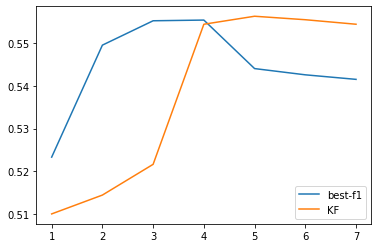

In [524]:
import matplotlib.pyplot as plt
plt.plot(range(1, 8), cur_f1_scores[1:8], label='best-f1')
plt.plot(range(1, 8), result, label='KF')
plt.legend()

In [297]:
print(max(cur_f1_scores))
print(max(result))

0.8381742738589212
0.831275720164609


In [104]:
def train_LR(L, scores):
    print('L shape', np.shape(L))
    num_methods = np.shape(L)[1]

    agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
#     print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    agree_inlier_indexes = np.sum(L,axis=1)==0
#     print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]
    self_agree_index_list = []
    for i in range(0, len(index_range)):
        if(index_range[i,1]-index_range[i,0] < 1):
            continue
        temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
        self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
    self_agree_index_list = [int(i) for i in self_agree_index_list]
    
    all_inlier_indexes = np.where(agree_inlier_indexes)[0]
#     print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
    all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)
#     print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))
    
    from sklearn.preprocessing import RobustScaler
    data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
    data_indexes = np.array([int(i) for i in data_indexes])
    labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
    transformer = RobustScaler().fit(scores)
    scores_transformed = transformer.transform(scores)
    training_data = scores_transformed[data_indexes]

    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0, penalty='l2').fit(training_data, labels)
    clf_predictions = clf.predict(scores_transformed)
    print("F-1 score:",metrics.f1_score(y, clf_predictions))
    
    agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
    agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]
    return metrics.f1_score(y, clf_predictions), clf.predict_proba(scores_transformed)[:,1]
    

In [105]:
train_LR(L, scores)

L shape (5473, 26)
F-1 score: 0.5339547270306259


(0.5339547270306259,
 array([2.85098071e-03, 1.24246216e-04, 4.15808259e-05, ...,
        2.74592296e-04, 1.33453116e-04, 9.03708973e-01]))

In [118]:
num_method = 4
random = np.random.RandomState(1234)
cur_f1_scores = []
prediction_result_list = []

for i in range(0, 200):
    cur_num_method = random.randint(1, num_method+1)
    cur_method_list = random.permutation(range(4))[:cur_num_method]
    print(cur_method_list)
    all_indexes = []
    for method in cur_method_list:
        s, e = index_range[method]
        print(random.randint(1,e-s+1))
        all_indexes.extend(range(s,e))
    print(len(all_indexes))
#         all_indexes.extend(random.permutation(range(s,e))[:random.randint(1,e-s+1)])
    all_indexes = np.sort(all_indexes)
    f1, prediction = train_LR(L[:,all_indexes], scores[:,all_indexes])
    cur_f1_scores.append(f1)
    prediction_result_list.append(prediction)
    
# print(np.shape(prediction_result_list))
# print(cur_f1_scores)

[0 1 2 3]
5
9
2
1
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[2 0 3 1]
4
7
1
9
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[2]
2
5
L shape (5473, 5)
F-1 score: 0.422282120395328
[0 1 3 2]
3
1
1
4
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[3]
1
1
L shape (5473, 1)
F-1 score: 0.527336860670194
[2 1 0]
4
1
4
25
L shape (5473, 25)
F-1 score: 0.47679324894514763
[2 1 0]
4
4
2
25
L shape (5473, 25)
F-1 score: 0.47679324894514763
[1 2 0]
2
5
1
25
L shape (5473, 25)
F-1 score: 0.47679324894514763
[0]
6
10
L shape (5473, 10)
F-1 score: 0.4952919020715631
[2 3 0 1]
5
1
1
10
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[1]
9
10
L shape (5473, 10)
F-1 score: 0.4148430066603235
[3 1 2]
1
2
3
16
L shape (5473, 16)
F-1 score: 0.4134705332086062
[0 1]
7
8
20
L shape (5473, 20)
F-1 score: 0.4672454617205999
[2]
5
5
L shape (5473, 5)
F-1 score: 0.422282120395328
[1 0 2]
5
3
2
25
L shape (5473, 25)
F-1 score: 0.47679324894514763
[0 1 2 3]
3
10
5
1
26
L shape (5473, 26)
F

[3 0 2 1]
1
5
4
6
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[3]
1
1
L shape (5473, 1)
F-1 score: 0.527336860670194
[2 0]
2
2
15
L shape (5473, 15)
F-1 score: 0.49250936329588013
[0 1 3]
8
4
1
21
L shape (5473, 21)
F-1 score: 0.4807987711213517
[0]
8
10
L shape (5473, 10)
F-1 score: 0.4952919020715631
[3]
1
1
L shape (5473, 1)
F-1 score: 0.527336860670194
[0 3]
9
1
11
L shape (5473, 11)
F-1 score: 0.5
[2 0 1]
2
1
5
25
L shape (5473, 25)
F-1 score: 0.47679324894514763
[2 3 1 0]
3
1
8
3
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[3 2 1]
1
1
6
16
L shape (5473, 16)
F-1 score: 0.4134705332086062
[2 3]
5
1
6
L shape (5473, 6)
F-1 score: 0.4392439243924392
[1 0 3]
7
3
1
21
L shape (5473, 21)
F-1 score: 0.4807987711213517
[3 2 1]
1
4
9
16
L shape (5473, 16)
F-1 score: 0.4134705332086062
[0 1 2 3]
10
6
5
1
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[0 1 3 2]
6
10
1
3
26
L shape (5473, 26)
F-1 score: 0.5339547270306259
[2 0 3]
5
8
1
16
L shape (5473, 16)
F-1 score: 0.

In [119]:
max(cur_f1_scores)

0.5339547270306259

In [111]:
result = []
for j in range(1, 2000):
    kf_final_results = []
    for i in range(np.shape(prediction_result_list)[1]):
        kf_final_results.append(filter_update_list(0.1, list(np.array(prediction_result_list)[:j,i])))
    kf_final_results = np.array(kf_final_results)
    predictions = np.array([int(i) for i in kf_final_results>0.5])
    result.append(metrics.f1_score(y, predictions))
print(result)

1


KeyboardInterrupt: 

In [114]:
np.shape(prediction_result_list)

(2000, 5473)

In [115]:
prediction_result_list = np.array(prediction_result_list)
kf_final_results = []
for i in range(np.shape(prediction_result_list)[1]):
    kf_final_results.append(filter_update_list(0.1, list(prediction_result_list[:,i])))
kf_final_results = np.array(kf_final_results)
predictions = np.array([int(i) for i in kf_final_results>0.5])
metrics.f1_score(y, predictions)

0.48520710059171596

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, 2000), result, label='KF')
plt.legend()

In [ ]:
max(result)

In [750]:
# get obvious errors and remove
remove_inliers = agreed_inlier_indexes[clf_predictions[agreed_inlier_indexes]==1]
all_inlier_indexes = np.setdiff1d(all_inlier_indexes,remove_inliers)
data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
transformer = RobustScaler().fit(scores)
scores_transformed = transformer.transform(scores)
training_data = scores_transformed[data_indexes]
print(np.shape(training_data))
print(np.shape(labels))

(309, 16)
(309,)


In [119]:
# unused_indexes = np.setdiff1d(range(0, 5473), np.union1d(all_inlier_indexes, all_outlier_indexes))
# # unused_indexes = disagree_indexes
# unused_predict_proba = clf.predict_proba(scores_transformed)[unused_indexes]
# threshold = 0.99
# certain_predictions = np.where(np.max(unused_predict_proba, axis = 1) > threshold)[0]
# print(len(certain_predictions))
# print(sum(clf_predictions[unused_indexes][certain_predictions]))
# print(metrics.confusion_matrix(y[unused_indexes][certain_predictions], 
#                                clf_predictions[unused_indexes][certain_predictions]))
# metrics.f1_score(y[unused_indexes][certain_predictions], clf_predictions[unused_indexes][certain_predictions], average=None)


112
52.0
[[55 30]
 [ 5 22]]


array([0.75862069, 0.55696203])

In [12]:
# predictions = clf.predict_proba(scores_transformed)[:,1]
# max_f1 = 0
# best_threshold = 0
# for threshold in range(100, 400, 10):
#     x = np.sort(predictions)[::-1][threshold]
#     clf_predictions = [int(i) for i in (predictions>x)]
#     cur_f1 = metrics.f1_score(y, clf_predictions)
#     if(cur_f1 > max_f1):
#         max_f1 = cur_f1
# print(max_f1)

In [136]:
from snorkel.labeling import MajorityLabelVoter
majority_model = MajorityLabelVoter()
preds_train = majority_model.predict_proba(L=L)
threshold = 0.5
predictions = np.full((len(y)), 0)
predictions[preds_train[:,1] > threshold] = 1
print('F1 for MV:', metrics.f1_score(y, predictions))
print('F1 for MV:', metrics.f1_score(y[disagree_indexes], predictions[disagree_indexes]))
print(sum(predictions[disagree_indexes]))

F1 for MV: 0.8278688524590164
F1 for MV: 0.6666666666666666
43


In [145]:
agreement_indexes = np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==4)==1
predictions = np.array([int(i) for i in np.sum(L[agreement_indexes], axis = 1)==4])
metrics.f1_score(y[agreement_indexes], predictions)

0.5445205479452054

In [190]:
x = np.array(scores)
print(x)
print(np.array(x).argsort(axis=0).argsort(axis=0)[all_predict_inlier][y[all_predict_inlier]==1])
np.max(np.array(x).argsort(axis=0).argsort(axis=0)[all_predict_inlier][y[all_predict_inlier]==1], axis=1)
# print(np.argsort(scores[:,0], axis = -1))

[[ 1.09237809  0.06831342  0.37657298  2.53878933]
 [ 1.05785957  0.04875727  0.37202809  0.75776378]
 [ 1.00117835  0.04275626  0.3724401   1.06894808]
 ...
 [ 1.02377944  0.06086581  0.37517007  1.555354  ]
 [ 1.04662907  0.05618816  0.36757721  1.55595838]
 [ 0.96330172  0.02607994  0.45039024 16.10601786]]
[[4816 4839 4593 4565]
 [4756 4458 4361 4246]
 [4794 4575 4669 4330]
 [4815 4858 4758 4573]
 [4795 4890 4704 4649]
 [3159 4338 4088 4382]
 [4899 4313 4546 3765]
 [2073 2312 3918 3170]
 [4270 4404 4863 4780]
 [4802 4773 3932 4497]
 [3607 4670 4563 4432]
 [3111 4423 4482 4201]
 [3829 4812 4787 4556]
 [4399 4192 4095 4040]
 [3380 4443 4691 4242]
 [2839 4452 4236 4458]
 [3062 4456 4262 4454]
 [3158 3548 4648 4613]
 [4841 4635 4748 4788]
 [4695 4647 4388 4738]
 [3633 4717 4806 4502]
 [4734 4874 4672 4452]
 [3955 4587 4843 4734]
 [4376 3445 3970 3490]
 [4680 1053 3565 3240]
 [3641 4615 4834 4713]
 [2963 4551 4766 4585]
 [2351 2530 3872 3174]
 [3050 4483 4684 4570]
 [4426 4153 4214 3973

array([4839, 4756, 4794, 4858, 4890, 4382, 4899, 3918, 4863, 4802, 4670,
       4482, 4812, 4399, 4691, 4458, 4456, 4648, 4841, 4738, 4806, 4874,
       4843, 4376, 4680, 4834, 4766, 3872, 4684, 4426, 4299, 4485, 4398,
       4576, 4698, 4147, 4629, 4725, 4809, 4849, 4380, 3909, 4685, 4866,
       4789, 4671, 4497, 4878, 3354, 4496, 4625, 3801, 4484, 4714, 4513,
       4183, 4840, 4787, 4672, 3121, 4429, 3994, 3122, 4475, 4258, 4383,
       4528, 3699, 4354, 4644, 4912, 4854, 4790, 4857, 4884, 4702, 4674,
       4570, 4492, 3802, 4701, 4675, 4460, 4374, 4789, 4495, 4392, 4443,
       4828, 4393, 3828, 4825, 4886, 4767, 4639, 4455, 4575, 4478, 4314,
       4379, 3742, 4017, 3443, 4583, 4193, 4763, 4432, 3335, 4560, 4552,
       4476, 4358, 4278, 4703, 4721, 4253, 4282, 4240, 4276, 4192, 4294,
       4544, 4274, 4687, 4290, 4736, 4165, 4758, 4696, 4549, 4518, 4305,
       4286, 4056, 4369, 4306, 4388, 4899, 4851, 4307, 4632, 4219, 4596,
       3755, 4008, 4820, 4521, 4392, 4724, 4861, 44

In [128]:
Ldisagree_indexes

array([False, False, False, ..., False, False,  True])

In [138]:
print(np.argsort(-scores[:,0]))
print(scores[:,0])

[1498  440  339 ... 4691 1394 4017]
[1.09237809 1.05785957 1.00117835 ... 1.02377944 1.04662907 0.96330172]


In [133]:
print(L[disagree_indexes,:][:20,:])
print(y[disagree_indexes][:20])
print(np.argsort(scores, axis=0)[disagree_indexes,:][:20,:])

[[1 1 0 1]
 [0 1 0 0]
 [1 1 0 0]
 [0 0 1 0]
 [0 1 0 0]
 [1 1 0 0]
 [0 1 0 0]
 [1 1 0 0]
 [0 1 0 0]
 [1 1 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [1 0 0 0]
 [0 1 0 0]
 [1 1 1 0]
 [0 1 1 1]
 [1 0 0 0]
 [1 1 1 0]
 [1 1 0 0]]
[0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1]
[[1440 2683  221 4543]
 [4756  784 2816 2368]
 [5391  876 3265 2638]
 [5428 1028  428 1130]
 [4879 5391  917  894]
 [4892 5428 2934  882]
 [3312 4410 2384  509]
 [3854 4390 2766  596]
 [3704  885  481 4924]
 [5363 2330 1978 3367]
 [1701   52  696  696]
 [ 804  510  326  592]
 [2744 1403   50 2582]
 [3204 2088 3242  615]
 [2683 3327 1743  951]
 [2686  591 3353 1175]
 [2830 5167 3180 1296]
 [2998 2422 1700 1017]
 [1947 3280  951 1211]
 [3376 2552 3423 2684]]


In [510]:
result = []
for i in range(1, num_methods):
    num_all_disagree = sum(np.sum(L[disagree_indexes, :],axis=1)==i)
    print('Method disagree, num_method_as_outliers={}, number of points = {}'
          .format(i, num_all_disagree))
    num_disagree_inliers = sum(y[disagree_indexes][np.sum(L[disagree_indexes, :],axis=1)==i]==0)
    print('Method disagree, num_method_as_outliers={}, number of true inliers = {}'
          .format(i, num_disagree_inliers))
    num_disagree_outliers = sum(y[disagree_indexes][np.sum(L[disagree_indexes, :],axis=1)==i]==1)
    print('Method disagree, num_method_as_outliers={}, number of true outiers = {}'
          .format(i, num_disagree_outliers))
    result.append([num_all_disagree, num_disagree_inliers, num_disagree_outliers])

Method disagree, num_method_as_outliers=1, number of points = 41
Method disagree, num_method_as_outliers=1, number of true inliers = 35
Method disagree, num_method_as_outliers=1, number of true outiers = 6
Method disagree, num_method_as_outliers=2, number of points = 31
Method disagree, num_method_as_outliers=2, number of true inliers = 28
Method disagree, num_method_as_outliers=2, number of true outiers = 3
Method disagree, num_method_as_outliers=3, number of points = 26
Method disagree, num_method_as_outliers=3, number of true inliers = 18
Method disagree, num_method_as_outliers=3, number of true outiers = 8
Method disagree, num_method_as_outliers=4, number of points = 51
Method disagree, num_method_as_outliers=4, number of true inliers = 19
Method disagree, num_method_as_outliers=4, number of true outiers = 32
Method disagree, num_method_as_outliers=5, number of points = 54
Method disagree, num_method_as_outliers=5, number of true inliers = 40
Method disagree, num_method_as_outliers

Method disagree, num_method_as_outliers=45, number of true inliers = 6
Method disagree, num_method_as_outliers=45, number of true outiers = 4
Method disagree, num_method_as_outliers=46, number of points = 4
Method disagree, num_method_as_outliers=46, number of true inliers = 1
Method disagree, num_method_as_outliers=46, number of true outiers = 3
Method disagree, num_method_as_outliers=47, number of points = 5
Method disagree, num_method_as_outliers=47, number of true inliers = 4
Method disagree, num_method_as_outliers=47, number of true outiers = 1
Method disagree, num_method_as_outliers=48, number of points = 7
Method disagree, num_method_as_outliers=48, number of true inliers = 4
Method disagree, num_method_as_outliers=48, number of true outiers = 3
Method disagree, num_method_as_outliers=49, number of points = 8
Method disagree, num_method_as_outliers=49, number of true inliers = 4
Method disagree, num_method_as_outliers=49, number of true outiers = 4
Method disagree, num_method_as

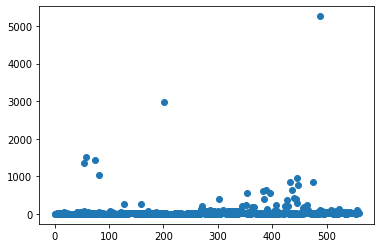

In [117]:
plt.scatter(range(0,len(scores[y==1,3])), scores[y==1,3])

In [911]:
breakcond = 0

for i in range(0, 26):
    print('L shape', np.shape(L))
    num_methods = np.shape(L)[1]
    
    ########################################################################

    agree_outlier_indexes = np.sum(L,axis=1)==np.shape(L)[1]
    print('All agree, Number of outliers = {}'.format(sum(agree_outlier_indexes)))
    agree_inlier_indexes = np.sum(L,axis=1)==0
    print('All agree, Number of inliers = {}'.format(sum(agree_inlier_indexes)))

    disagree_indexes = np.where(np.logical_or(np.sum(L,axis = 1)==0, np.sum(L,axis = 1)==num_methods)==0)[0]
    # print('Number of disagreed points = {}'.format(len(disagree_indexes)))
    # print('Number of disagreed points (true outliers) = {}'.format(sum(y[disagree_indexes] == 1)))
    # print('Number of disagreed points (true inliers) = {}'.format(sum(y[disagree_indexes] == 0)))

    self_agree_index_list = []
    for i in range(0, len(index_range)):
        if(index_range[i,1]-index_range[i,0] < 1):
            continue
        temp_index = disagree_indexes[np.where(np.sum(L[disagree_indexes][:,index_range[i,0]: index_range[i,1]], axis = 1)==(index_range[i,1]-index_range[i,0]))[0]]
        self_agree_index_list = np.union1d(self_agree_index_list, temp_index)
    self_agree_index_list = [int(i) for i in self_agree_index_list]

#     all_inlier_indexes = np.where(agree_inlier_indexes)[0]
    all_inlier_indexes = np.union1d(np.setdiff1d(np.where(agree_inlier_indexes)[0], prediction_high_conf_outliers), prediction_high_conf_inliers)
    print('num of inliers = {}'.format(np.shape(all_inlier_indexes)[0]))
#     all_outlier_indexes = np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list)
    all_outlier_indexes = np.union1d(np.union1d(np.where(agree_outlier_indexes)[0], self_agree_index_list), prediction_high_conf_outliers)
    print('num of outliers = {}'.format(np.shape(all_outlier_indexes)[0]))

    ####################################################################
    
    from sklearn.preprocessing import RobustScaler
    data_indexes = np.concatenate((all_inlier_indexes, all_outlier_indexes), axis = 0)
    data_indexes = np.array([int(i) for i in data_indexes])
    labels = np.concatenate((np.zeros(len(all_inlier_indexes)), np.ones(len(all_outlier_indexes))), axis = 0)
    transformer = RobustScaler().fit(scores_for_training)
    scores_transformed = transformer.transform(scores_for_training)
    training_data = scores_transformed[data_indexes]
    print(np.shape(training_data))
    print(np.shape(labels))

    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(random_state=0, penalty='l2').fit(training_data, labels)
    clf_predictions = clf.predict(scores_transformed)
    clf_predict_proba = clf.predict_proba(scores_transformed)[:,1]
    print("F-1 score:",metrics.f1_score(y, clf_predictions))
    cur_f1_scores.append(metrics.f1_score(y, clf_predictions))

    agreed_outlier_indexes = np.where(np.sum(L,axis=1)==np.shape(L)[1])[0]
    agreed_inlier_indexes = np.where(np.sum(L,axis=1)==0)[0]
#     minmax_diff = max(clf.coef_[0])/min(clf.coef_[0])
#     print('max/min = ', minmax_diff)
#     if(minmax_diff > 0 and minmax_diff < 10):
#         break
        
    print(clf.coef_[0])
#     print(np.std(scores_transformed, 0)*clf.coef_[0])
    prediction_result_list.append(clf_predict_proba)
    prediction_list.append(np.array([int(i) for i in clf_predictions]))

    cutoff = 0 #max(0, np.sort(clf.coef_[0])[0])
    print(cutoff)
    cur_clf_coef = clf.coef_[0] #* np.std(scores_transformed, 0)
    remain_indexes_after_cond =  cur_clf_coef > cutoff #np.logical_and(cur_clf_coef > cutoff, abs(cur_clf_coef) > 0.01) # #
    remain_indexes_after_cond_expanded = []
    for i in range(0, len(coef_index_range)): #
        s_e_range = coef_index_range[i,1]-coef_index_range[i,0]
        s1, e1 = coef_index_range[i,0], coef_index_range[i,1]
        s2, e2 = index_range[i,0], index_range[i,1]
        saved_indexes = np.where(cur_clf_coef[s1:e1] > cutoff)[0]
        print(saved_indexes)
        for j in range(N_size):
            remain_indexes_after_cond_expanded.extend(np.array(saved_indexes) + j * s_e_range + s2)
    
    if sum(remain_indexes_after_cond) == len(remain_indexes_after_cond):
        if(breakcond == 1):
            break
        breakcond = 1
    
    new_coef_index_range_seq = []
    for i in range(0, len(coef_index_range)): #
        s, e = coef_index_range[i,0], coef_index_range[i,1]
        new_coef_index_range_seq.append(sum((remain_indexes_after_cond)[s:e]))

    coef_index_range = []
    index_range = []
    cur_sum = 0
    for i in range(0, len(new_coef_index_range_seq)):
        coef_index_range.append([cur_sum, cur_sum + new_coef_index_range_seq[i]])
        index_range.append([cur_sum * 6, 6 * (cur_sum + new_coef_index_range_seq[i])])
        cur_sum += new_coef_index_range_seq[i]

    coef_index_range = np.array(coef_index_range)
    index_range = np.array(index_range)
    print(coef_index_range)
    print(index_range)

    L=L[:,remain_indexes_after_cond_expanded]
    scores_for_training = scores_for_training[:, remain_indexes_after_cond]
    
    prediction_high_conf_outliers = np.where(prediction_result_list[-1] > 0.99)[0]
    print(len(prediction_high_conf_outliers))
    prediction_high_conf_inliers = np.where(prediction_result_list[-1] < 0.01)[0]
    print(len(prediction_high_conf_inliers))
    # coef_remain_index = np.array(coef_remain_index)[np.where(clf.coef_[0] > cutoff)[0]]
    # print('remain_coef_range: ', coef_remain_index)

L shape (5473, 156)
All agree, Number of outliers = 55
All agree, Number of inliers = 3788
num of inliers = 3788
num of outliers = 362
(4150, 26)
(4150,)
F-1 score: 0.518860662047729
[ 0.2756969   0.06014979  0.29439604  0.29648246  0.20636889  0.0871536
  0.01097172 -0.01679439  0.05334285  0.13574258  0.00687914 -0.05657723
 -0.07584194  0.02252633  0.00581494  0.03069127  0.03884938  0.18490425
  0.30661874  0.45375213 -0.01199057 -0.36638537 -0.11584035  0.32368891
  0.03577571  1.29149479]
0
[0 1 2 3 4 5 6 8 9]
[0 3 4 5 6 7 8 9]
[3 4]
[0]
[[ 0  9]
 [ 9 17]
 [17 19]
 [19 20]]
[[  0  54]
 [ 54 102]
 [102 114]
 [114 120]]
393
3844
L shape (5473, 120)
All agree, Number of outliers = 57
All agree, Number of inliers = 3793
num of inliers = 3983
num of outliers = 431
(4414, 20)
(4414,)
F-1 score: 0.5208955223880598
[ 0.15186768  0.06620574  0.27847413  0.31807438  0.21494111  0.12382872
  0.05226428  0.07120398  0.19148699 -0.09839986 -0.0143421  -0.02946763
 -0.03840814 -0.03438845  0.0

### One-class SVM

In [11]:
import pickle
oneclass_SVM_model = pickle.load(open("oneclass_SVM_model_cover.pickle", "rb" ))
prediction_scores = oneclass_SVM_model['scores']

for i in range(len(mahalanobis_N_range)):
    ocsvm_predictions,ocsvm_scores,f1 = get_predictions(prediction_scores, num_outliers=mahalanobis_N_range[i], method_name='oneclass-SVM')
    all_results.append(ocsvm_predictions)
    all_scores.append(ocsvm_scores)
    f1s.append(f1)
L = np.stack(all_results).T
scores = np.stack(all_scores).T

F1 for oneclass-SVM : 0.0010326578030205242
F1 for oneclass-SVM : 0.0018611576400521124
F1 for oneclass-SVM : 0.05679767788499255
F1 for oneclass-SVM : 0.10714043534278156
F1 for oneclass-SVM : 0.16106853020739403
F1 for oneclass-SVM : 0.15696861591862316


In [30]:
from sklearn.svm import OneClassSVM
clf = OneClassSVM(gamma='auto', verbose=True).fit(X_transformed)
print('model fitted')
prediction_scores = clf.score_samples(X_transformed)

for i in range(len(mahalanobis_N_range)):
    threshold = np.sort(prediction_scores)[::-1][mahalanobis_N_range[i]]
    predictions = np.array(prediction_scores > threshold)
    predictions = np.array([int(i) for i in predictions])
    print('F1 for one-class SVM : {}'.format(metrics.f1_score(y, predictions)))
    
import pickle
oneclass_SVM_model = {'model': clf, 'scores': prediction_scores}
pickle.dump(oneclass_SVM_model, open("oneclass_SVM_model_cover_transformed.pickle", "wb" ))

[LibSVM]